In [12]:
import pertpy as pt
import pickle as pkl
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 
from statsmodels.sandbox.stats.multicomp import multipletests
# works with pertpy 0.4.0 DO NOT UPDATE 

import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 
from statsmodels.sandbox.stats.multicomp import multipletests
import pickle as pkl

In [13]:
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(pt)

import session_info
session_info.show(html=False, dependencies=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

-----
anndata             0.8.0
matplotlib          3.7.1
numpy               1.23.5
pandas              1.5.3
pertpy              0.4.0
scanpy              1.9.3
scipy               1.10.1
seaborn             0.11.2
session_info        1.0.0
statsmodels         0.13.5
-----
PIL                         9.4.0
PyQt5                       NA
adjustText                  NA
appnope                     0.1.3
arrow                       1.2.3
arviz                       0.14.0
asttokens                   NA
backcall                    0.2.0
certifi                     2022.12.07
cffi                        1.15.1
cftime                      1.6.2
charset_normalizer          3.1.0
comm                        0.1.2
custom_inherit              2.4.1
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
decoupler                   1.3.4
ete3                        3.1.2
executing     

In [14]:
def test_association(adata, celltype_label = "Cluster", sample_label="Sample", condition_label = "Efficacy", conditions_compare = ("PR","SD")): 
    """
    Tests association between MCPs and a binary response variable (e.g. response to treatment)
    Input:  adata (AnnData object): AnnData object with MCPs in obs
            celltype_label (str): column name in adata.obs with cell type labels
            sample_label (str): column name in adata.obs with sample labels
            condition_label (str): column name in adata.obs with response variable
            conditions_compare (tuple): tuple of length 2 with the two conditions to compare, must be in in adata.obs[condition_label]
    Note: benjamini-hochberg corrects for the number of cell types, NOT the number of MCPs
    """
    
    pvals = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    tstats = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    pvals_adj = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    
    response = adata.obs.groupby(sample_label)[condition_label].agg(pd.Series.mode)
    res = dict()
    for celltype in adata.obs[celltype_label].unique():
        df = adata.obs[adata.obs[celltype_label]==celltype]

        for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
            mns = df.groupby(sample_label)[mcpnum].mean()
            mns = pd.concat([mns,response],axis=1)
            res = stats.ttest_ind(mns[mns[condition_label]==conditions_compare[0]][mcpnum],mns[mns[condition_label]==conditions_compare[1]][mcpnum])
            pvals.loc[celltype, mcpnum]=res[1]
            tstats.loc[celltype, mcpnum]=res[0]
            #return(res)
            #
    for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
        pvals_adj[mcpnum]=multipletests(pvals[mcpnum], method='fdr_bh')[1]
    return pvals,tstats,pvals_adj

def get_mcp_genes(celltype, results,MCP, threshhold=0.70, focal_celltypes = None):
    """
    Extracts MCP genes for the celltype of interest 
    Input: 
        celltype (str): cell type of interest
        results (results object from dl.MultilevelModeling) : results object
        threshhold (float): number between [0,1]. The fraction of cell types compared against which must have the associated MCP gene
        focal_celltypes (None or list): None (compare against all cell types) or a list of other cell types which you want to compare against 
    """
    comparisons = results.keys()
    comparisons = list(comparisons)
    filtered_keys = [key for key in comparisons if celltype in key]
    if focal_celltypes is not None:
        if celltype in focal_celltypes:
            focal_celltypes = [item for item in focal_celltypes if item != celltype]
        filtered_keys = [key for key in filtered_keys if any(foci in key for foci in focal_celltypes)]
    mcp_dict={}
    for key in filtered_keys:
        if key.startswith(celltype):
            mcp_dict[key.split('_vs_')[1]] = results[key][MCP]['sig_genes_1']
        else:
            mcp_dict[key.split('_vs_')[0]] = results[key][MCP]['sig_genes_2']
    genes_dict_up = {}
    genes_dict_down = {}
    for celltype2 in mcp_dict.keys():
        for gene in mcp_dict[celltype2][MCP+".up"]:
            if gene in genes_dict_up:
                genes_dict_up[gene]+=1
            else:
                genes_dict_up[gene] = 1
        for gene in mcp_dict[celltype2][MCP+".down"]:
            if gene in genes_dict_down:
                genes_dict_down[gene]+=1
            else:
                genes_dict_down[gene] = 1
    up_genes_df =  pd.DataFrame.from_dict(genes_dict_up,orient='index')
    down_genes_df = pd.DataFrame.from_dict(genes_dict_down,orient='index')
    
    min_cell_types = np.floor(len(filtered_keys)*threshhold)
    final_output = {}
    final_output['up_genes'] = list(np.unique(up_genes_df[up_genes_df[0] >= min_cell_types].index.values.tolist()))
    final_output['down_genes'] = list(np.unique(down_genes_df[down_genes_df[0]>=min_cell_types].index.values.tolist()))
    return(final_output)

def plot_split_violins(adata, mcp = "mcp_0", split="Efficacy", celltype_key = "Cluster"):
    df = sc.get.obs_df(adata, [celltype_key,mcp, split])
  

    p2 = sns.violinplot(data=df, x=celltype_key,y=mcp,hue=split, split=True)
    p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


In [4]:
### IMPORT FROM THE BS SOLVER
adata=sc.read_h5ad("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.h5ad")

with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.pkl", 'rb') as file:
    a = pkl.load(file)
file.close()


In [15]:
def mcp_pairsplot(adata, celltype_key = "Cluster", color = "Efficacy", mcp = "mcp_0", sample_key = "Sample"):
    """
    Plotting utility for MCPs using seaborn pairplot
    input:
        adata: anndata object
        celltype_key: column name in adata.obs for cell type
        color: column name in adata.obs for color
        mcp: column name in adata.obs for MCP
        sample_key: column name in adata.obs for sample
    """
    mean_mcps = adata.obs.groupby([sample_key,celltype_key])[mcp].mean()
    mean_mcps = mean_mcps.reset_index()
    mcp_pivot = pd.pivot(mean_mcps[[sample_key,celltype_key,mcp]],index=sample_key,columns = celltype_key )[mcp]
    mcp_pivot = pd.concat([mcp_pivot,adata.obs.groupby([sample_key]).agg(pd.Series.mode)[color]],axis=1)
    sns.pairplot(mcp_pivot, corner=True, hue=color)
    

In [16]:
a['pvals_adj'] = test_association(adata)[2]# interested in MCP_4, MCP_8

In [17]:
a['pvals_adj']

mcp_0     mcp_1     mcp_2     mcp_3     mcp_4     mcp_5  \
t_Bmem-CD27       0.133935  0.996494  0.840276  0.835061  0.021844  0.735016   
t_CD4_Tcm-LMNA    0.133935  0.990698  0.576729  0.835061  0.021844  0.726261   
t_CD4_Treg-FOXP3  0.133935  0.990698  0.840276  0.835061  0.031923  0.873899   
t_CD8_MAIT-KLRB1  0.133935  0.990698  0.576729  0.835061  0.021844  0.726261   
t_CD8_Tem-GZMK    0.133935  0.990698  0.576729  0.835061  0.031923  0.802207   
t_CD8_Trm-ZNF683  0.133935  0.996494  0.576729  0.835061  0.031923  0.726261   
t_Tn-LEF1         0.133935  0.990698  0.576729  0.835061  0.021844  0.726261   
t_mono-FCN1       0.133935  0.990698  0.576729  0.835061  0.079806  0.802207   
t_pB-IGHG1        0.133935  0.990698  0.990550  0.835061  0.021844  0.726261   

                     mcp_6     mcp_7     mcp_8     mcp_9  
t_Bmem-CD27       0.744986  0.321793  0.057626  0.964654  
t_CD4_Tcm-LMNA    0.744986  0.279277  0.063592  0.964654  
t_CD4_Treg-FOXP3  0.764904  0.279277  0.511023  0.964654  
t_CD8_MAIT-KLRB1  0.894425  0.279277  0.428104  0.964654  
t_CD8_Tem-GZMK    0.914792  0.279277  0.145698  0.964654  
t_CD8_Trm-ZNF683  0.744986  0.279277  0.078418  0.964654  
t_Tn-LEF1         0.744986  0.321793  0.078792  0.964654  
t_mono-FCN1       0.744986  0.279277  0.229512  0.964654  
t_pB-IGHG1        0.744986  0.279277  0.078418  0.964654

In [18]:
with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023_MCPgenes_fixed.pkl", 'rb') as file:
    dlg_results = pkl.load(file)
file.close()

with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023_ct_subs_various.pkl", 'rb') as file:
    ct_subs = pkl.load(file)
file.close()



In [9]:
dlg_results['all_results'].keys()

dict_keys(['t_Bmem-CD27_vs_t_CD4_Tcm-LMNA', 't_Bmem-CD27_vs_t_CD4_Treg-FOXP3', 't_Bmem-CD27_vs_t_CD8_MAIT-KLRB1', 't_Bmem-CD27_vs_t_CD8_Tem-GZMK', 't_Bmem-CD27_vs_t_CD8_Trm-ZNF683', 't_Bmem-CD27_vs_t_Tn-LEF1', 't_Bmem-CD27_vs_t_mono-FCN1', 't_Bmem-CD27_vs_t_pB-IGHG1', 't_CD4_Tcm-LMNA_vs_t_CD4_Treg-FOXP3', 't_CD4_Tcm-LMNA_vs_t_CD8_MAIT-KLRB1', 't_CD4_Tcm-LMNA_vs_t_CD8_Tem-GZMK', 't_CD4_Tcm-LMNA_vs_t_CD8_Trm-ZNF683', 't_CD4_Tcm-LMNA_vs_t_Tn-LEF1', 't_CD4_Tcm-LMNA_vs_t_mono-FCN1', 't_CD4_Tcm-LMNA_vs_t_pB-IGHG1', 't_CD4_Treg-FOXP3_vs_t_CD8_MAIT-KLRB1', 't_CD4_Treg-FOXP3_vs_t_CD8_Tem-GZMK', 't_CD4_Treg-FOXP3_vs_t_CD8_Trm-ZNF683', 't_CD4_Treg-FOXP3_vs_t_Tn-LEF1', 't_CD4_Treg-FOXP3_vs_t_mono-FCN1', 't_CD4_Treg-FOXP3_vs_t_pB-IGHG1', 't_CD8_MAIT-KLRB1_vs_t_CD8_Tem-GZMK', 't_CD8_MAIT-KLRB1_vs_t_CD8_Trm-ZNF683', 't_CD8_MAIT-KLRB1_vs_t_Tn-LEF1', 't_CD8_MAIT-KLRB1_vs_t_mono-FCN1', 't_CD8_MAIT-KLRB1_vs_t_pB-IGHG1', 't_CD8_Tem-GZMK_vs_t_CD8_Trm-ZNF683', 't_CD8_Tem-GZMK_vs_t_Tn-LEF1', 't_CD8_Tem-GZMK_

In [10]:
# for loadings, take the top 50 genes of each top/bottom? numbers are arbitrary so that probably makes sense
# for MCP genes use the function you already made
# for high/low split use everything with significance above some level 



In [19]:
#sc.get.rank_genes_groups_df(ct_subs['ct_subs_method2'][celltype], group = "high"+1+" "+celltype)

def get_genes_fixed(ct_subs, mcp="mcp_4", fraction = 0.1):
    """
    Same function as get_genes, but manually add a flag to the .raw saying it's been logarythmized,
    set as raw again, then run (needed due to transfer from Seurat)
    Input:
        ct_subs: dictionary of celltype anndata objects
        mcp: MCP of interest
        fraction: fraction of cells to be considered "high" or "low" for the MCP
    """
    genes=dict()
    for ct in ct_subs.keys():
        mini = ct_subs[ct]
        mini = mini.raw.to_adata()
        mini.uns['log1p']= {'base': None}
        mini.raw = mini
        # this is actually normalized and logged
        #mini.obs[mcp]
        mini.obs['extrema'] =pd.qcut(mini.obs[mcp],[0,0 + fraction,1-fraction,1.0], labels = ["low "+mcp+" "+ct,"no","high"+mcp+" "+ct])
        sc.tl.rank_genes_groups(mini,"extrema", groups = ["high"+mcp+" "+ct],reference="low "+mcp+" "+ct)
        genes[ct] = mini#.uns['rank_genes_groups']
    return genes

In [20]:
def get_genes_fixed_all_mcps(ct_subs, fraction = 0.1):
    """
    Calls get_genes_fixed for all cell types, 
    returns a dictionary of data frames of gene lists.
    Input: dictionary of cell type subsets, fraction of genes to return
    """
    rank_dfs = {}
    _, ct_sub = next(iter(ct_subs.items()))
    mcps = [col for col in ct_sub.obs.columns if col.startswith("mcp_")]

    for mcp in mcps:
        rank_dfs[mcp] = {}
        ct_ranked = get_genes_fixed(ct_subs, mcp = mcp, fraction = fraction)
        for celltype in ct_ranked.keys():
            rank_dfs[mcp][celltype] = sc.get.rank_genes_groups_df(ct_ranked[celltype], group=None)
            #print(celltype)
            #print(rank_dfs[mcp][celltype])
    return rank_dfs

In [22]:
rank_dfs = get_genes_fixed_all_mcps(ct_subs['ct_subs_method2'])

In [23]:
genes_loadings = {}
genes_dlg = {}
genes_hilo = {}
for celltype in ct_subs['ct_subs_loadings'].keys():
    dset = ct_subs['ct_subs_loadings'][celltype]
    mcps = ["mcp_"+str(n) for n in range(0,10)]
    genes_loadings[celltype] = dict()
    genes_dlg[celltype] = dict()
    genes_hilo[celltype] = dict()
    for n in range(0,10):
        #loadings
        contribs = pd.DataFrame(index = dset.var_names, data = dset.varm['MCPs'][:,n], columns= ["comp"])
        x_lowest = list(contribs.sort_values(by='comp').head(50).index.values)
        x_highest= list(contribs.sort_values(by='comp', ascending=False).head(50).index.values)
        genes_loadings[celltype][mcps[n]+"_up"] = x_highest
        genes_loadings[celltype][mcps[n]+"_down"] = x_lowest
        #dlg
        mcpgenes = get_mcp_genes(celltype, dlg_results['all_results'],"MCP"+str(n+1), threshhold=0.70, focal_celltypes = None)
        genes_dlg[celltype][mcps[n]+"_up"] = mcpgenes['up_genes']
        genes_dlg[celltype][mcps[n]+"_down"] = mcpgenes['down_genes']
        #extrema high-low split
        eg = rank_dfs["mcp_"+str(n)][celltype].sort_values(by="pvals_adj").head(100)
        # keep only if pval_adj <0.01
        eg = eg[eg['pvals_adj']<0.05]
        genes_hilo[celltype][mcps[n]+"_up"] = eg[eg['logfoldchanges']>0]['names'].tolist()
        genes_hilo[celltype][mcps[n]+"_down"] = eg[eg['logfoldchanges']<0]['names'].tolist()
        
        

In [24]:
things = 0 
n_up=0
n_up_list = []
n_down=0
n_down_list= []
for ct in genes_dlg.keys():
    for n in range(0,10):
        n_up += len(genes_dlg[ct]['mcp_'+str(n)+'_up'])
        n_up_list.append(len(genes_dlg[ct]['mcp_'+str(n)+'_up']))
        n_down +=  len(genes_dlg[ct]['mcp_'+str(n)+'_down'])
        n_down_list.append(len(genes_dlg[ct]['mcp_'+str(n)+'_down']))
        things +=1
        
## take the top and bottom 50 to match dialogue? or take the top 60 and the bottom 40 to match

In [27]:
genes_dlg['t_Bmem-CD27']['mcp_4_up']

['AHNAK',
 'CRIP1',
 'DDX3X',
 'DDX5',
 'FOSB',
 'HLA-B',
 'HSP90AB1',
 'HSPA1A',
 'IGHA1',
 'MT-ATP8',
 'MT-ND1',
 'MT-ND5',
 'MT-ND6',
 'NEU1',
 'NFKBIA',
 'ODC1',
 'SLC38A2',
 'TMSB10',
 'TNF']

(array([10.,  9., 18., 15., 16., 15.,  4.,  1.,  1.,  1.]),
 array([  0. ,  17.5,  35. ,  52.5,  70. ,  87.5, 105. , 122.5, 140. ,
        157.5, 175. ]),
 <BarContainer object of 10 artists>)

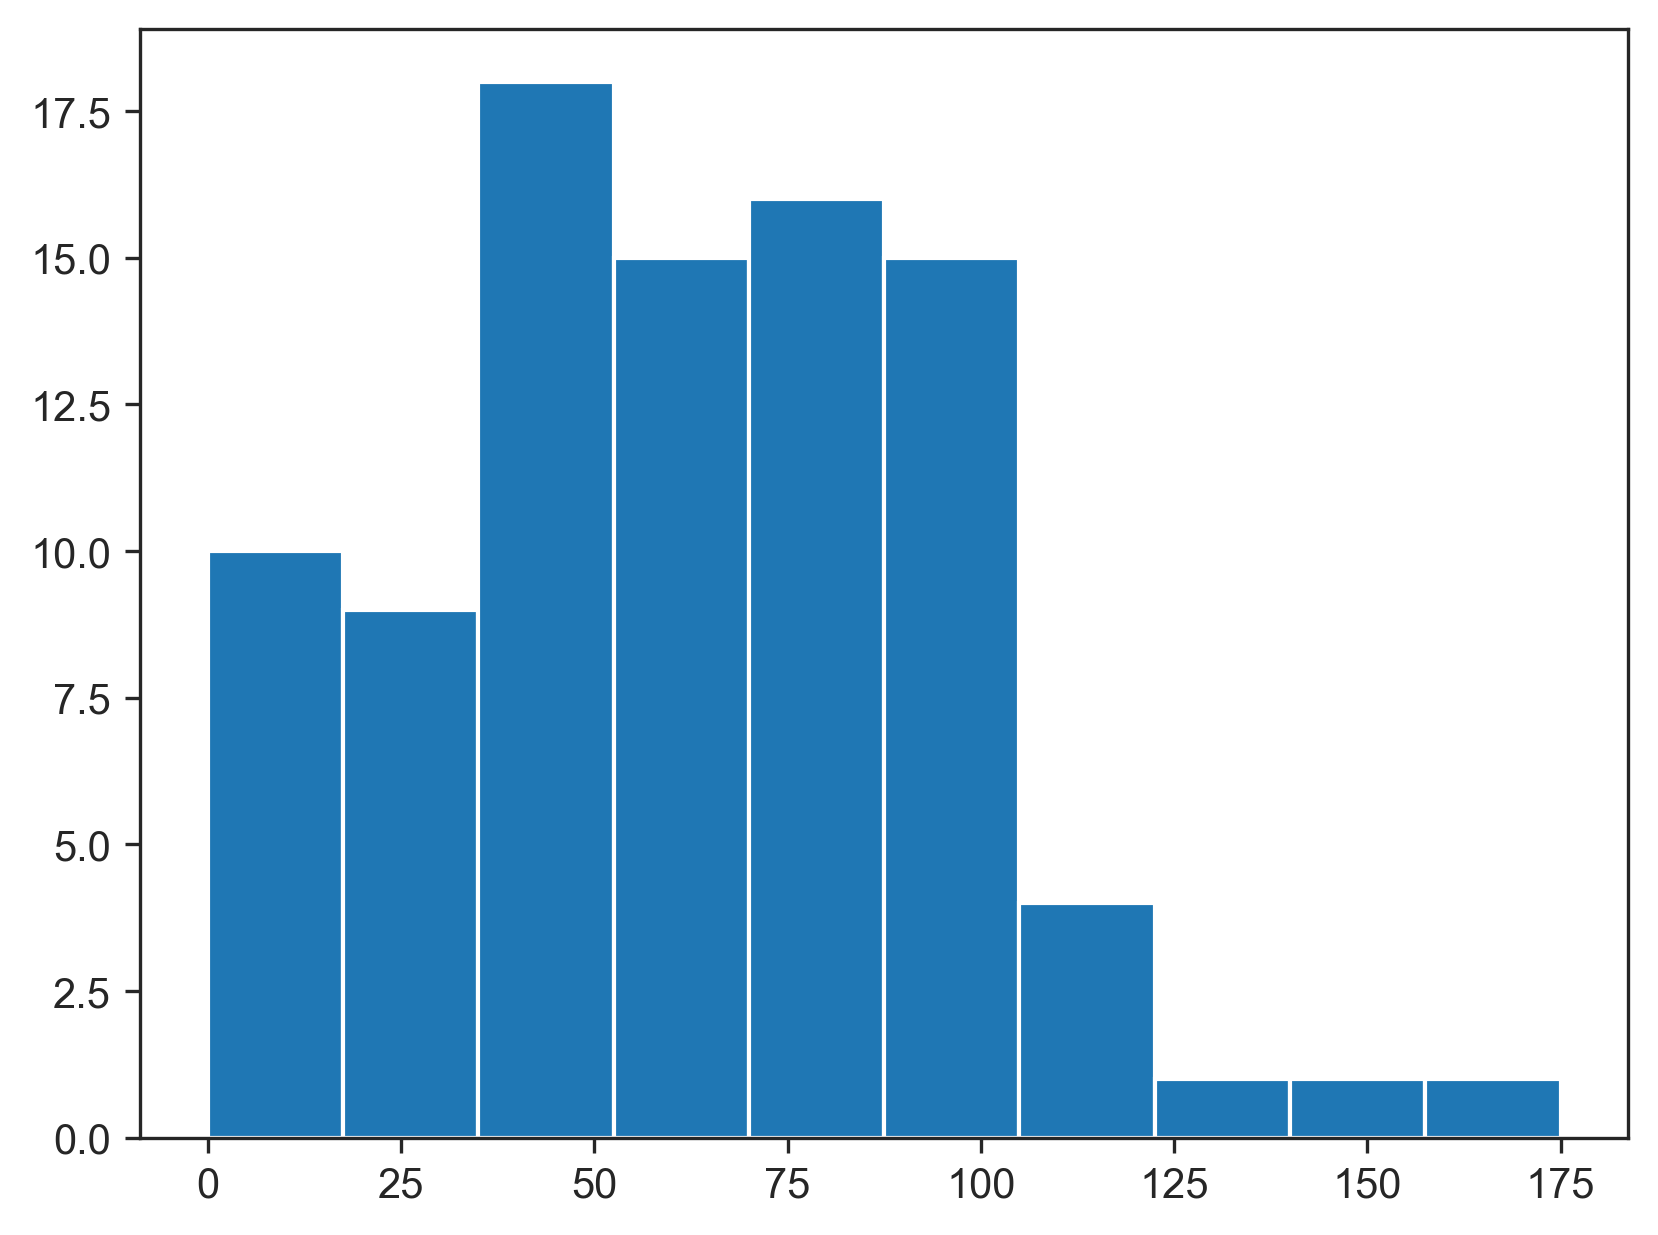

In [17]:
plt.hist(n_up_list)

(array([18., 19.,  8., 13.,  6.,  5., 12.,  7.,  1.,  1.]),
 array([  2. ,  13.7,  25.4,  37.1,  48.8,  60.5,  72.2,  83.9,  95.6,
        107.3, 119. ]),
 <BarContainer object of 10 artists>)

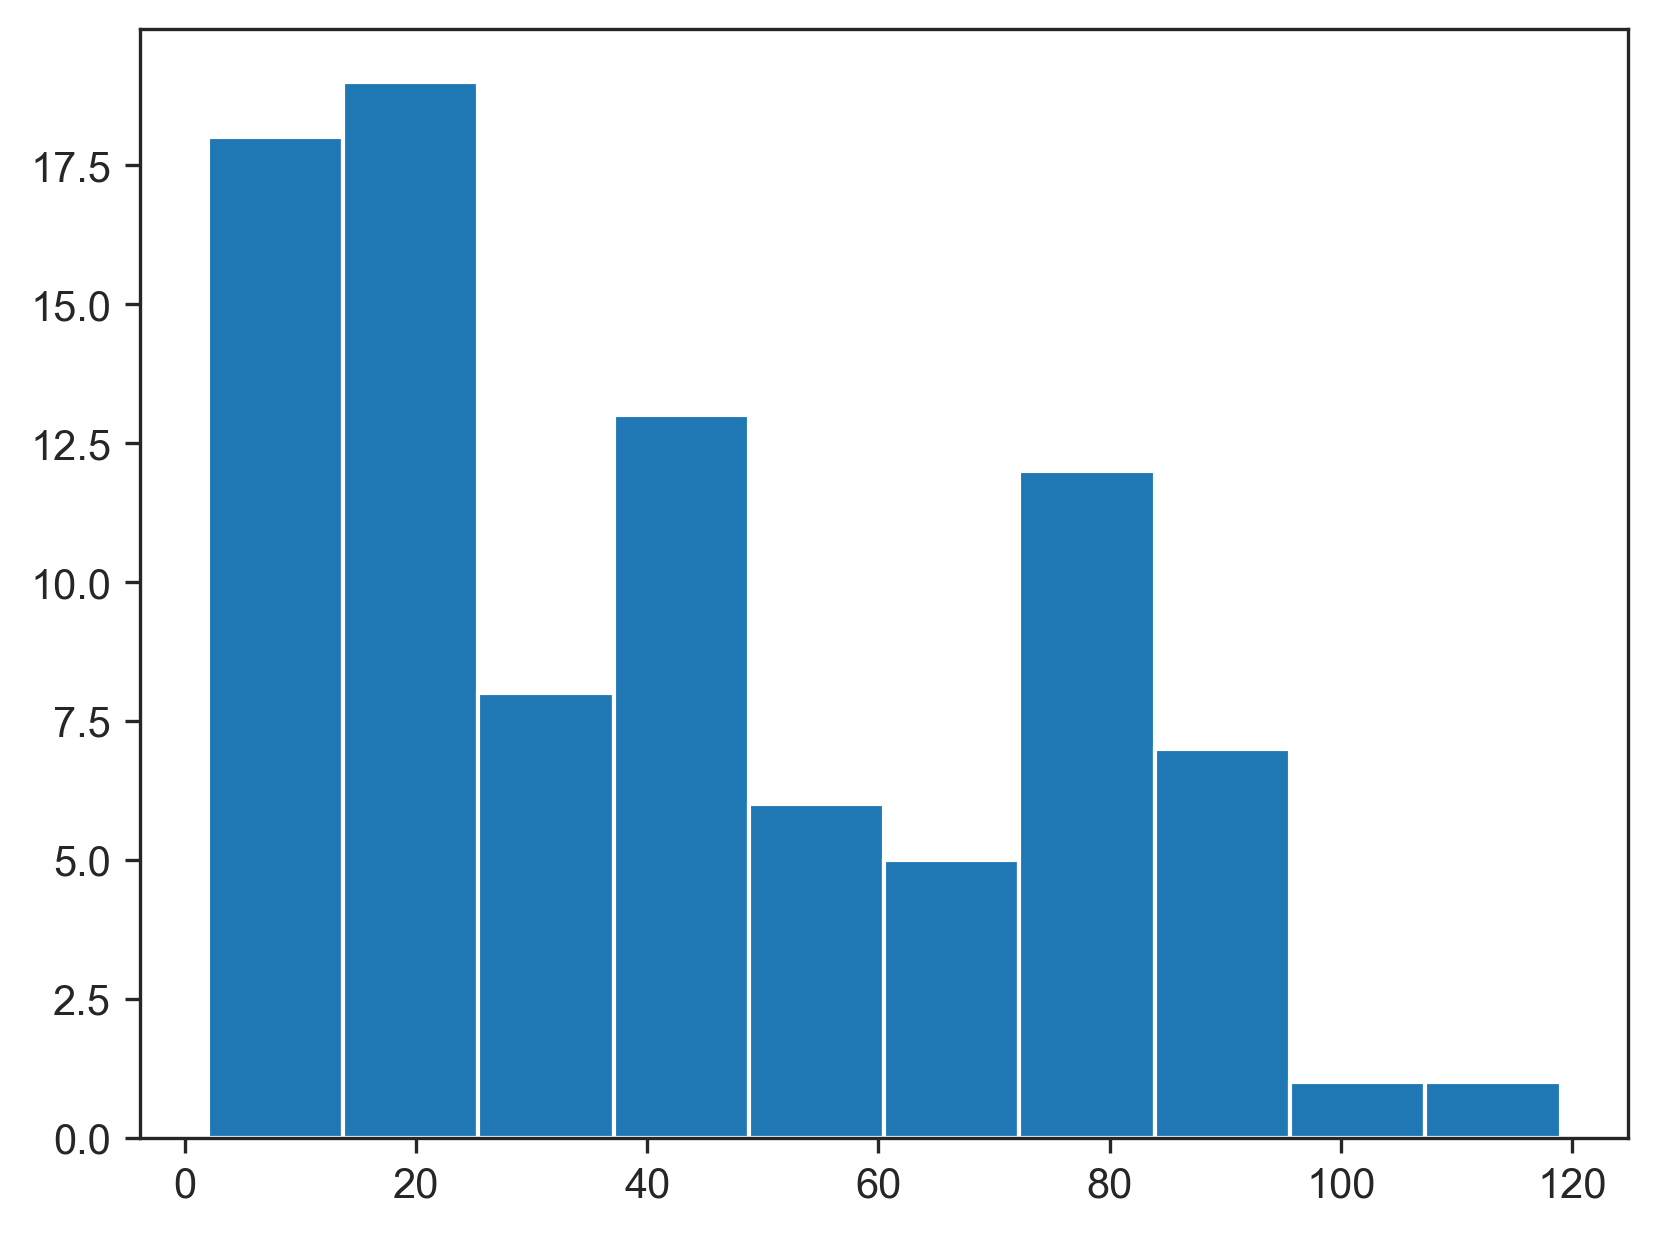

In [18]:
plt.hist(n_down_list)

In [19]:
stats.kstest(n_up_list, 'norm')

KstestResult(statistic=0.9777461065359446, pvalue=3.6946253999030515e-149, statistic_location=4, statistic_sign=-1)

In [20]:
stats.kstest(n_down_list, 'norm')

KstestResult(statistic=0.9772498680518208, pvalue=2.6889503480979066e-148, statistic_location=2, statistic_sign=-1)

In [21]:
## Going to take 2 approaches for the high/low split
## want everything with the appropriate p_adj 

In [188]:
shared = [x for x in genes_dlg['t_Bmem-CD27']['mcp_0_down'] if x in genes_hilo['t_Bmem-CD27']['mcp_0_down']]
unique = np.unique(genes_dlg['t_Bmem-CD27']['mcp_0_down'] + genes_hilo['t_Bmem-CD27']['mcp_0_down'])
jaccard = len(shared)/len(unique)

# either calculate the overall jaccard as bags
# or calculate the individual jaccards and average 

def calc_jaccard(genes_1,genes_2, mcp, sign ):
    def get_shared(celltype, MCP=mcp, genes_1 = genes_1, genes_2 = genes_2,sign=sign):
        return([x for x in genes_1[celltype][MCP+"_"+sign] if x in genes_2[celltype][MCP+"_"+sign]])
    def get_unique(celltype, MCP=mcp, genes_1 = genes_1, genes_2 = genes_2, sign=sign):
        return(np.unique(genes_1[celltype][MCP+"_"+sign] + genes_2[celltype][MCP+"_"+sign]))
    # for each cell type 
    jaccard = dict()
    for celltype in genes_1: 
        jaccard[celltype] = len(get_shared(celltype, mcp, genes_1, genes_2, sign))/len(get_unique(celltype, mcp, genes_1, genes_2,sign))
    return(pd.DataFrame.from_dict(jaccard, orient = "index", columns = [mcp+"_"+sign]))
    #return(pd.DataFrame.from_dict(jaccard))

In [189]:
def full_jaccard_mat(genes_1, genes_2):
    df= calc_jaccard(genes_1, genes_2, "mcp_0", sign="up")
    j = calc_jaccard(genes_1, genes_2, "mcp_0", sign="down")
    df = pd.concat([df, j], axis=1)
    for n in range(1,10):
        j = calc_jaccard(genes_1, genes_2, "mcp_"+str(n), sign="up")
        df = pd.concat([df, j],axis=1)
        j = calc_jaccard(genes_1, genes_2, "mcp_"+str(n), sign="down")
        df = pd.concat([df, j],axis=1)
    return(df)

In [190]:
dlg_v_hilo = full_jaccard_mat(genes_dlg,genes_hilo)

In [195]:
dlg_v_hilo


mcp_0_up  mcp_0_down  mcp_1_up  mcp_1_down  mcp_2_up  \
t_Bmem-CD27       0.541604    0.574138  1.026316    0.422857  0.933735   
t_CD4_Tcm-LMNA    0.231214    0.172043  0.290323    0.000000  0.437500   
t_CD4_Treg-FOXP3  0.244604    0.158416  0.244444    0.000000  0.288462   
t_CD8_MAIT-KLRB1  0.131455    0.063158  0.108108    0.169492  0.094340   
t_CD8_Tem-GZMK    0.129870    0.119403  0.215686    0.000000  0.166667   
t_CD8_Trm-ZNF683  0.255319    0.271739  0.330275    0.053333  0.453488   
t_Tn-LEF1         0.076336    0.080247  0.353846    0.000000  0.393617   
t_mono-FCN1       0.066667    0.222222  0.196721    0.260417  0.058140   
t_pB-IGHG1        0.016529    0.129032  0.333333    0.000000  0.000000   

                  mcp_2_down  mcp_3_up  mcp_3_down  mcp_4_up  mcp_4_down  \
t_Bmem-CD27         0.504931  1.111688    0.453333  0.585657    0.559006   
t_CD4_Tcm-LMNA      0.134021  0.360465    0.185714  0.196721    0.093333   
t_CD4_Treg-FOXP3    0.150000  0.157895    0.132075  0.236641    0.025000   
t_CD8_MAIT-KLRB1    0.466102  0.204082    0.235294  0.102190    0.036697   
t_CD8_Tem-GZMK      0.188235  0.360825    0.035088  0.152672    0.175676   
t_CD8_Trm-ZNF683    0.425000  0.314815    0.152778  0.269841    0.033898   
t_Tn-LEF1           0.000000  0.337209    0.302326  0.314286    0.546512   
t_mono-FCN1         0.035714  0.286885    0.119565  0.084211    0.263889   
t_pB-IGHG1          0.000000  0.386792    0.000000  0.053571    0.016667   

                  mcp_5_up  mcp_5_down  mcp_6_up  mcp_6_down  mcp_7_up  \
t_Bmem-CD27       0.304444    0.517375  0.464052    0.668675  0.580000   
t_CD4_Tcm-LMNA    0.072917    0.065574  0.064935    0.518519  0.275510   
t_CD4_Treg-FOXP3  0.041667    0.177215  0.151515    0.383929  0.200000   
t_CD8_MAIT-KLRB1  0.009259    0.093750  0.282258    0.018182  0.049383   
t_CD8_Tem-GZMK    0.035088    0.177215  0.020202    0.040816  0.283019   
t_CD8_Trm-ZNF683  0.269231    0.197531  0.166667    0.293578  0.329897   
t_Tn-LEF1         0.054422    0.139535  0.123288    0.021277  0.000000   
t_mono-FCN1       0.081967    0.000000  0.170000    0.076271  0.013699   
t_pB-IGHG1        0.000000    0.120000  0.056000    0.045455  0.000000   

                  mcp_7_down  mcp_8_up  mcp_8_down  mcp_9_up  mcp_9_down  
t_Bmem-CD27         1.095395  0.324376    0.658635  0.722101    0.882845  
t_CD4_Tcm-LMNA      0.066667  0.095890    0.060606  0.026549    0.509091  
t_CD4_Treg-FOXP3    0.000000  0.201923    0.000000  0.008000    0.047619  
t_CD8_MAIT-KLRB1    0.163265  0.008333    0.266667  0.000000    0.588235  
t_CD8_Tem-GZMK      0.010000  0.147368    0.042254  0.110294    0.500000  
t_CD8_Trm-ZNF683    0.028986  0.181034    0.013514  0.032520    0.551020  
t_Tn-LEF1           0.443182  0.113636    0.547368  0.477477    0.608696  
t_mono-FCN1         0.000000  0.095745    0.250000  0.058824    0.211111  
t_pB-IGHG1          0.051020  0.125000    0.000000  0.059524    0.285714

In [192]:
dlg_vs_loading = full_jaccard_mat(genes_dlg,genes_loadings)

In [193]:
dlg_vs_loading.mean()

mcp_0_up      0.004353
mcp_0_down    0.016539
mcp_1_up      0.031629
mcp_1_down    0.004738
mcp_2_up      0.016246
mcp_2_down    0.009758
mcp_3_up      0.018447
mcp_3_down    0.007824
mcp_4_up      0.010897
mcp_4_down    0.018452
mcp_5_up      0.002947
mcp_5_down    0.006282
mcp_6_up      0.010273
mcp_6_down    0.021886
mcp_7_up      0.003545
mcp_7_down    0.001287
mcp_8_up      0.016981
mcp_8_down    0.013609
mcp_9_up      0.009399
mcp_9_down    0.009629
dtype: float64

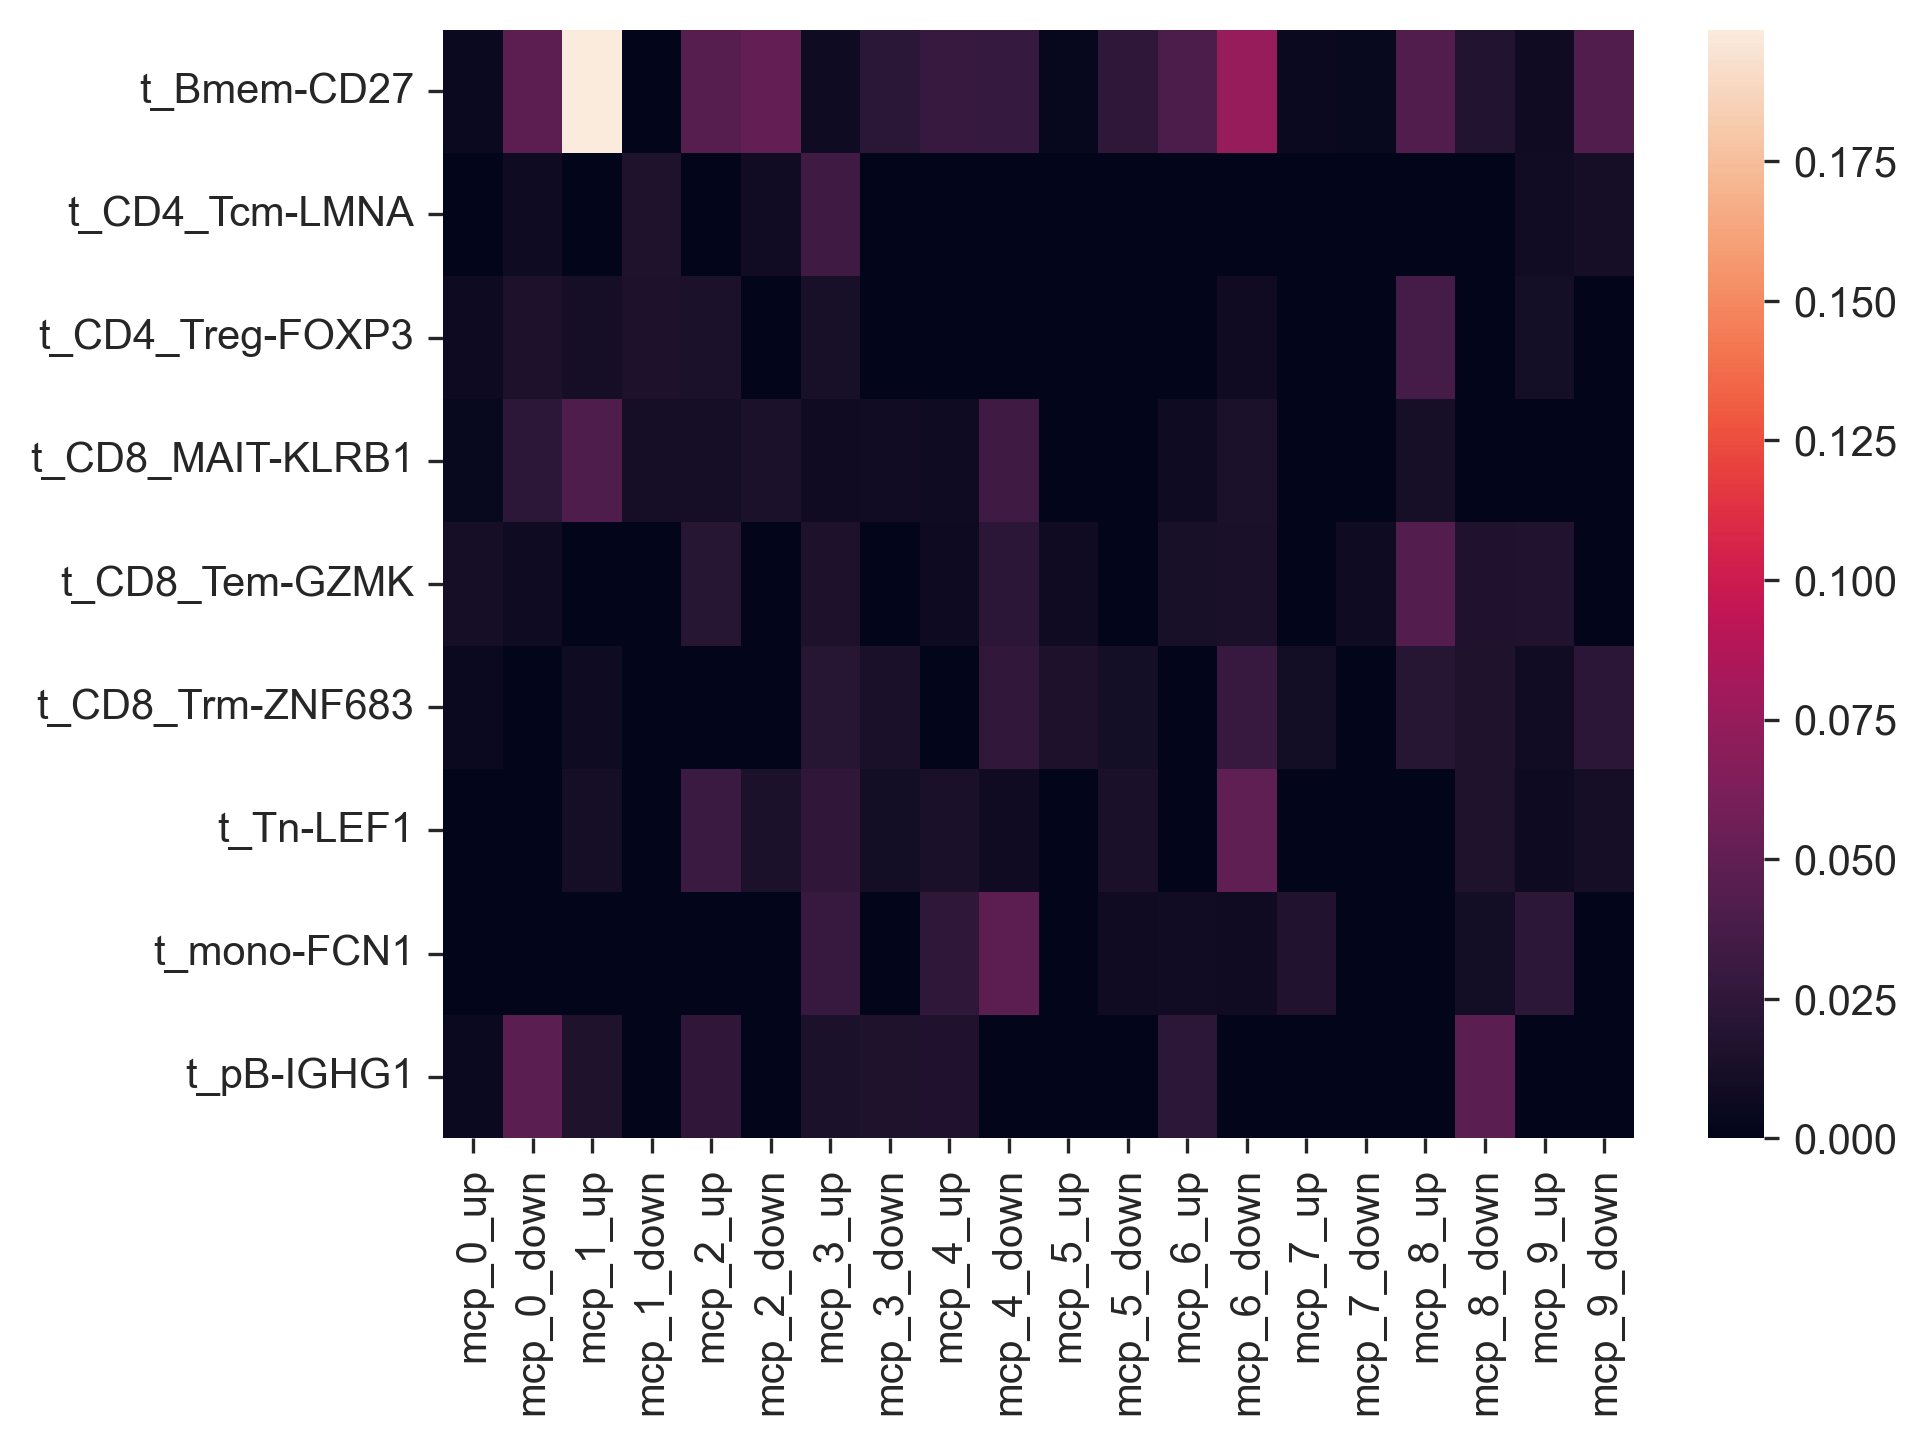

<Axes: >

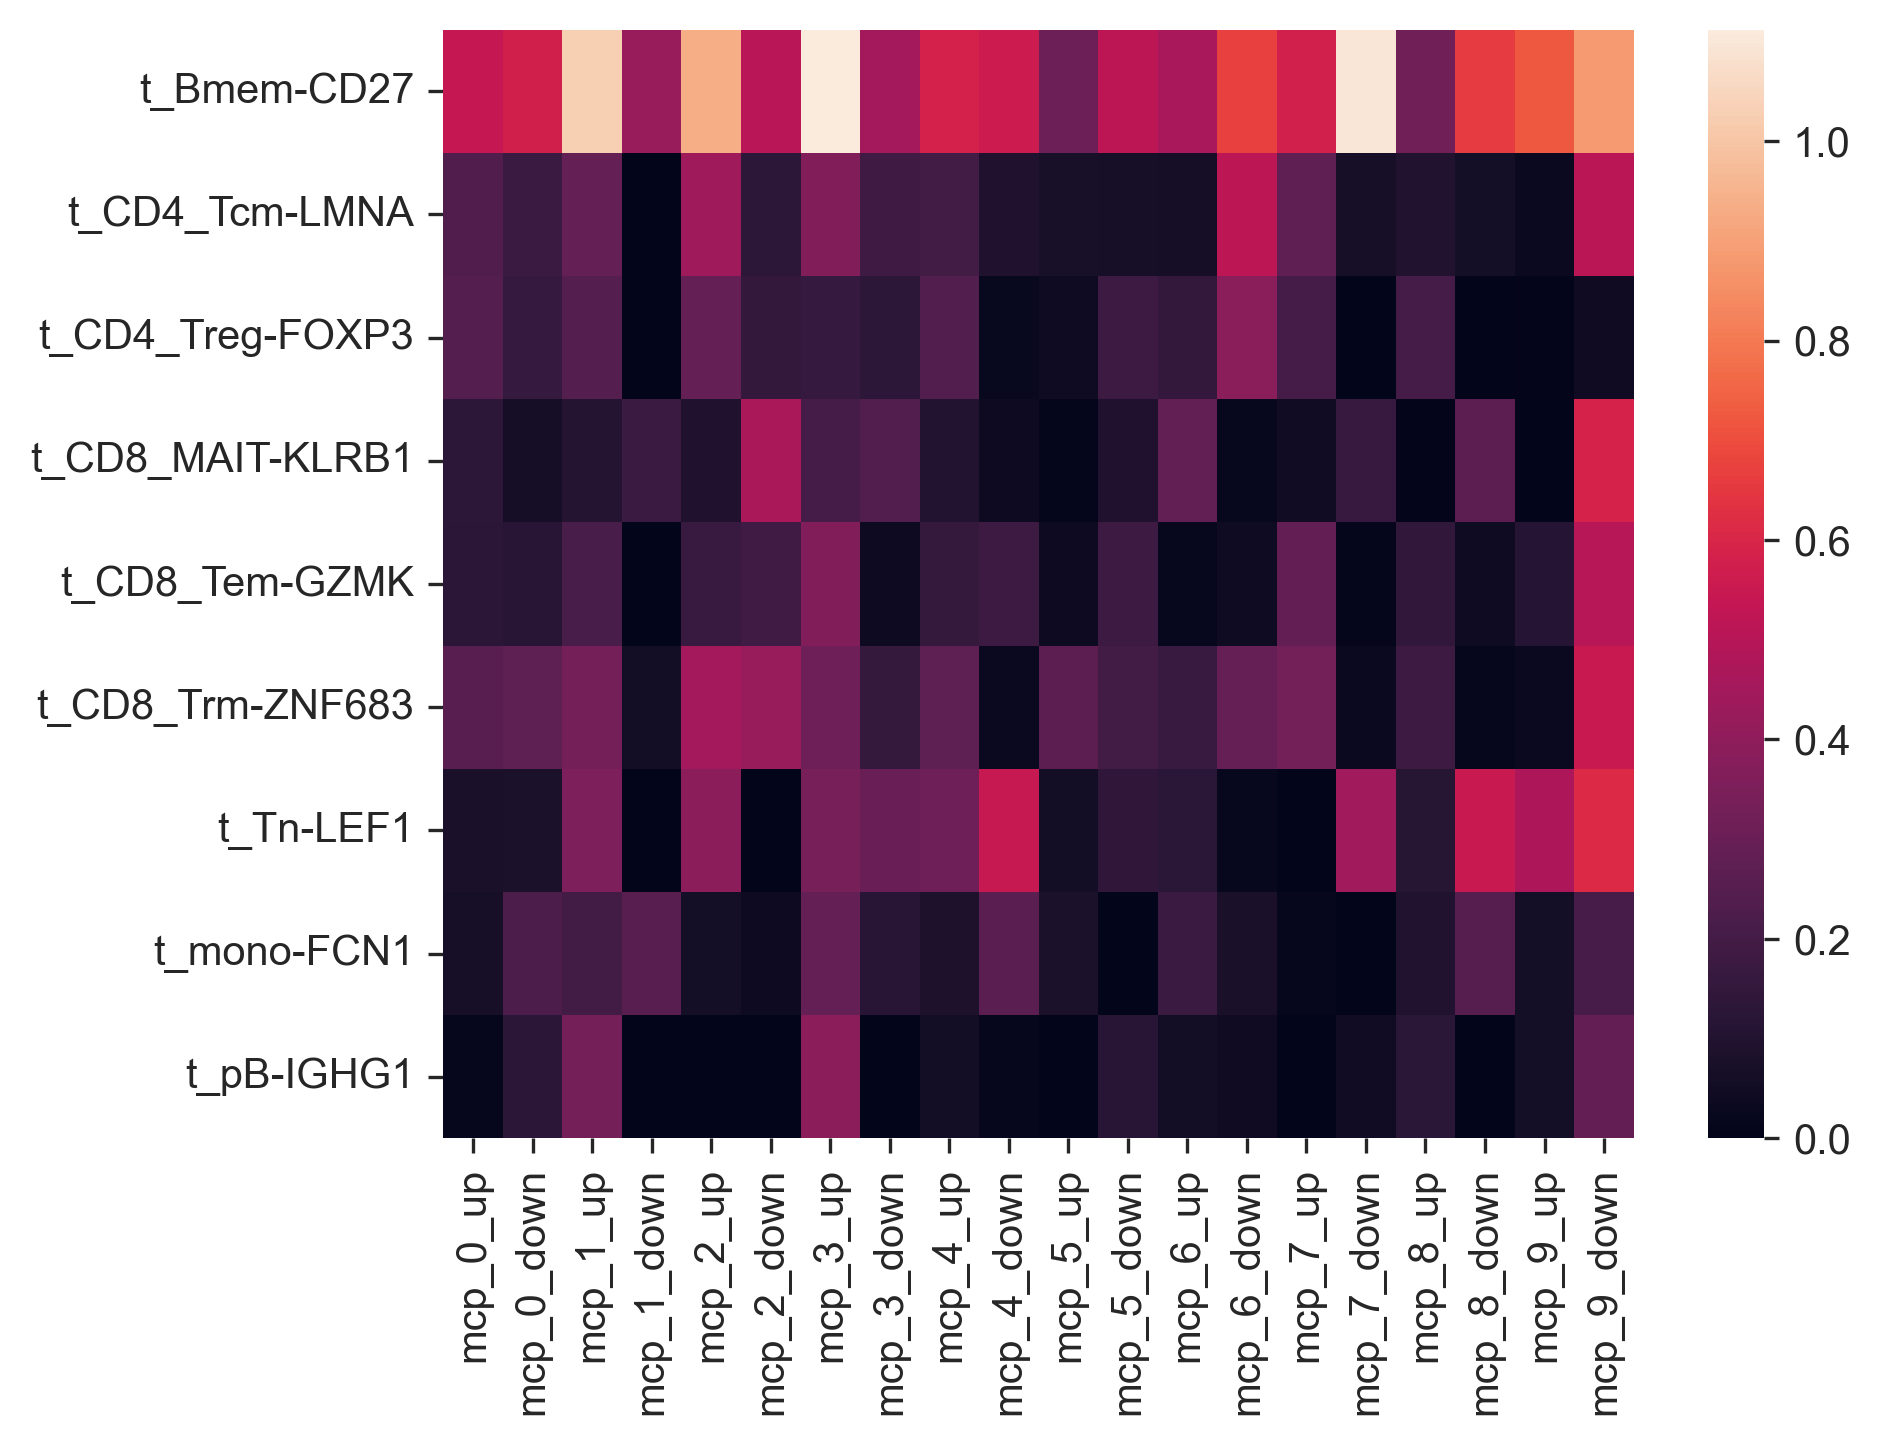

In [197]:
dlg_vs_loading = dlg_vs_loading.apply(pd.to_numeric, errors='coerce')

sns.heatmap(dlg_vs_loading, annot=False)
plt.show()
dlg_vs_hilo = dlg_v_hilo.apply(pd.to_numeric, errors='coerce')

sns.heatmap(dlg_vs_hilo, annot=False)

# combine these two heatmaps into a single image 
# https://stackoverflow.com/questions/46615554/combine-two-heatmaps-in-seaborn




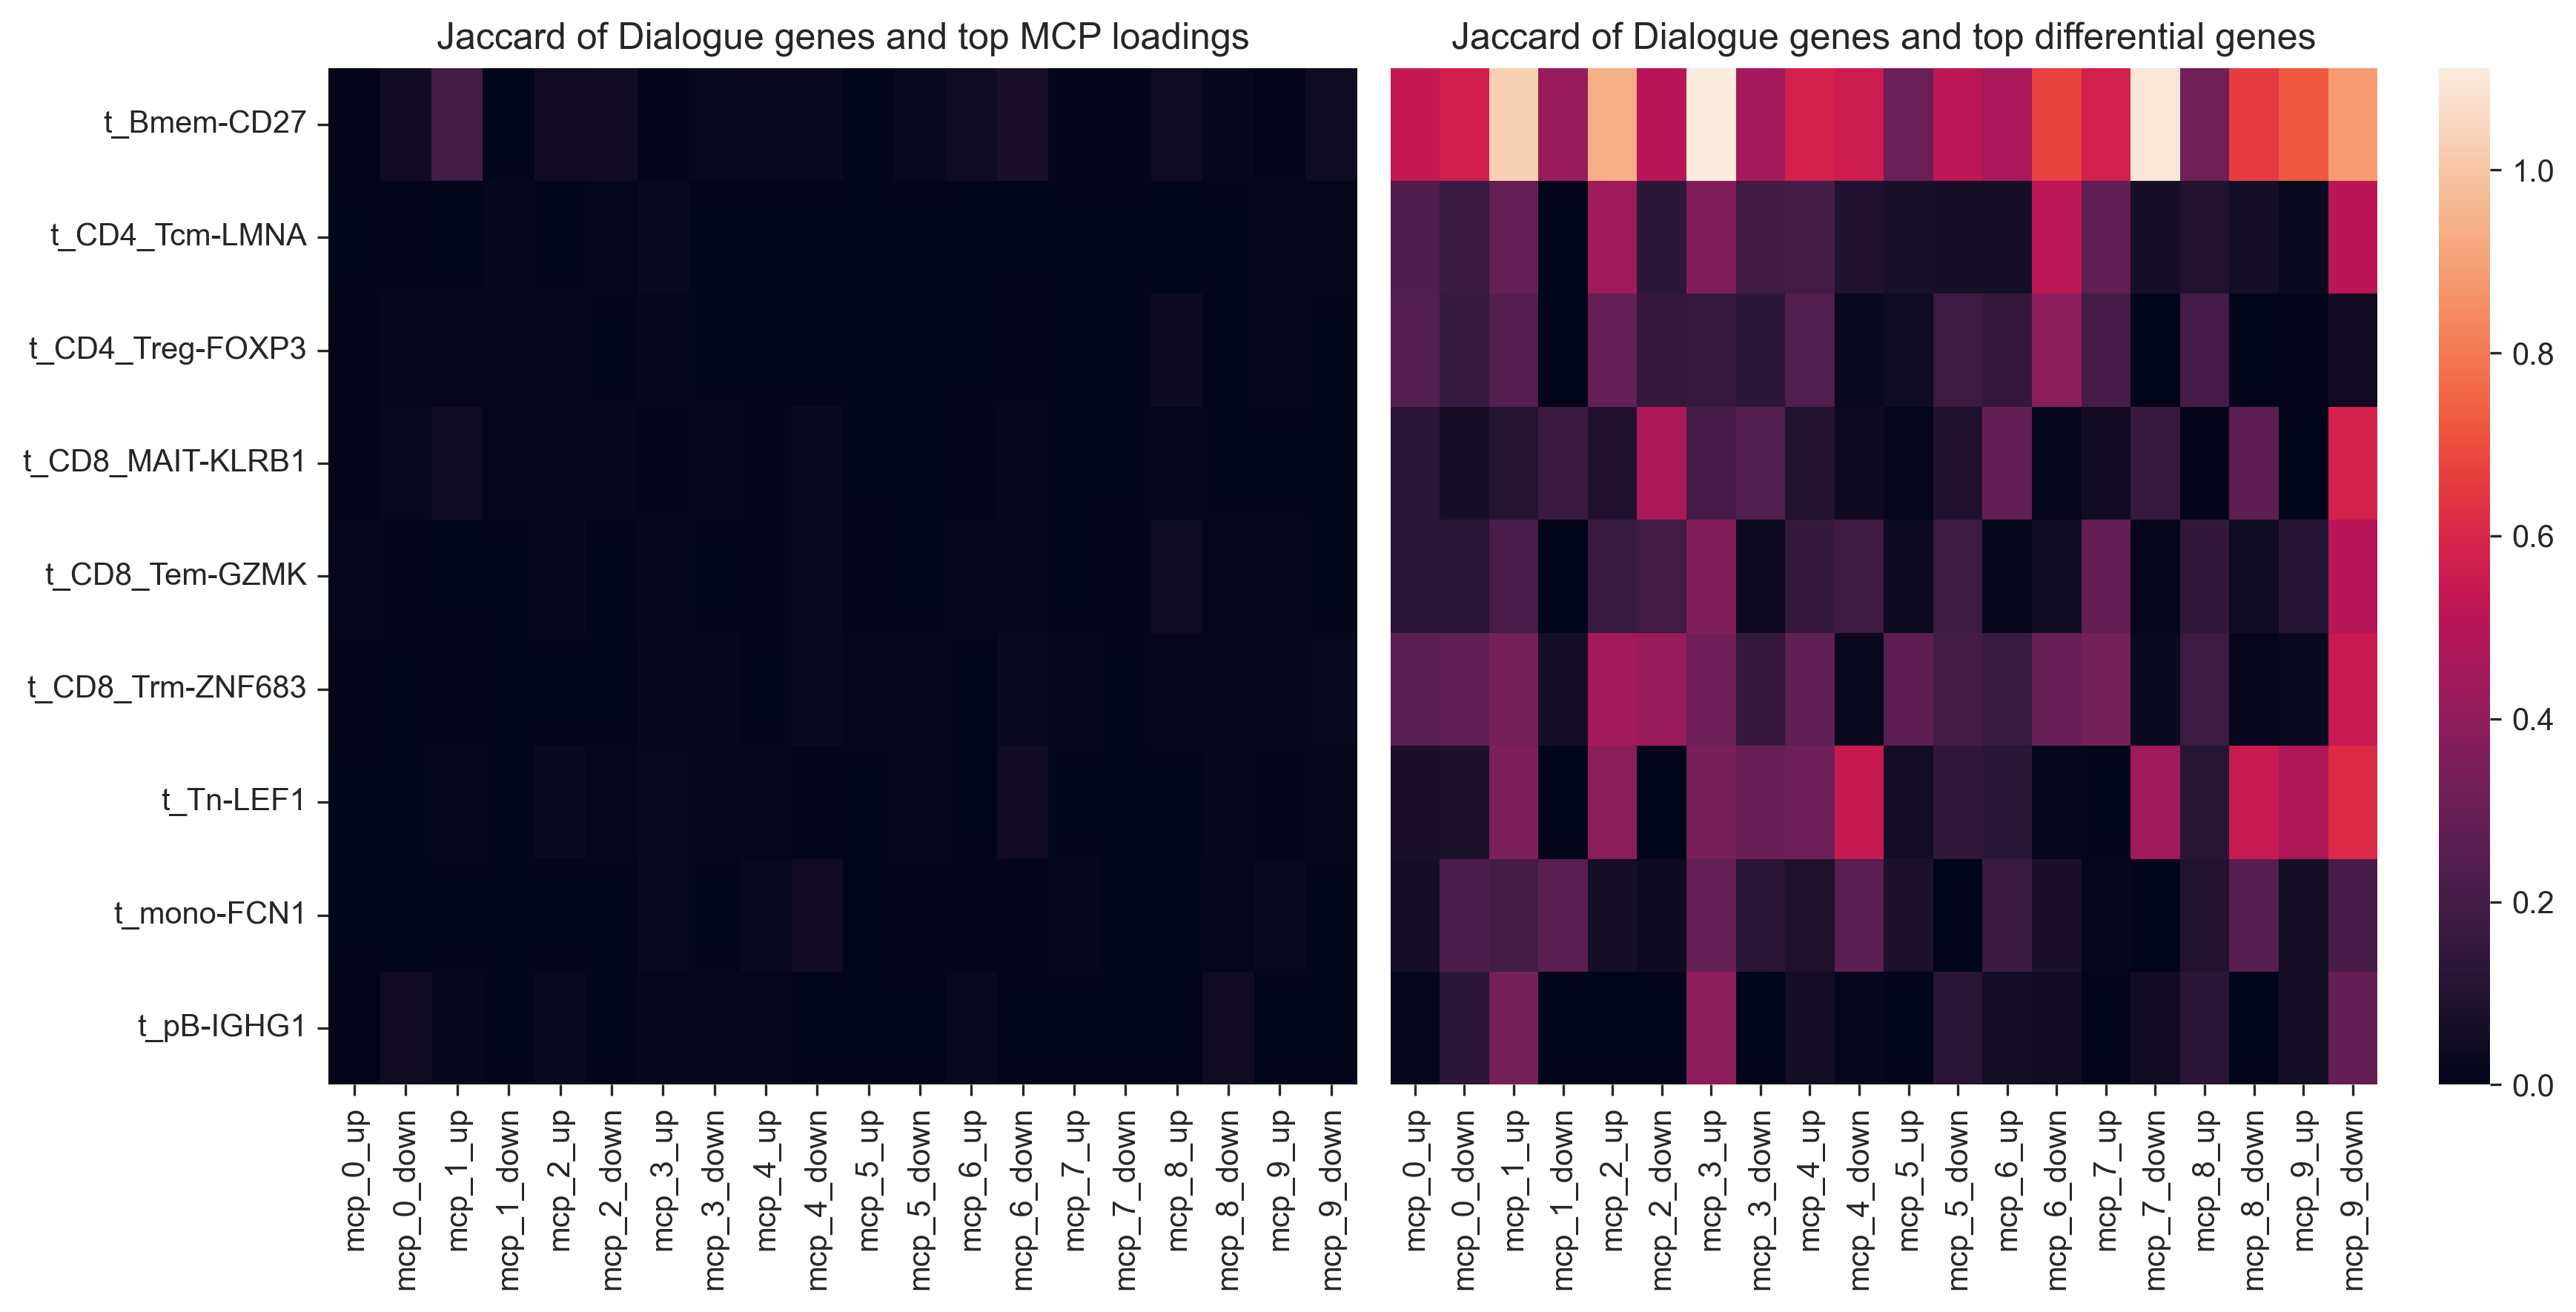

In [211]:
from matplotlib.gridspec import GridSpec

dlg_vs_loading = dlg_vs_loading.apply(pd.to_numeric, errors='coerce')

# Convert values to numeric in dlg_vs_hilo DataFrame
dlg_vs_hilo = dlg_vs_hilo.apply(pd.to_numeric, errors='coerce')

# Calculate the overall vmin and vmax for both DataFrames
overall_min = min(dlg_vs_loading.values.min(), dlg_vs_hilo.values.min())
overall_max = max(dlg_vs_loading.values.max(), dlg_vs_hilo.values.max())

# Create a figure using gridspec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1.2])  # Adjust the width ratio as needed

# Plot the first heatmap without colorbar
ax1 = plt.subplot(gs[0])
sns.heatmap(dlg_vs_loading, annot=False, vmin=overall_min, vmax=overall_max, ax=ax1, cbar=False)
ax1.set_title('Jaccard of Dialogue genes and top MCP loadings')

# Plot the second heatmap with colorbar
ax2 = plt.subplot(gs[1])
sns.heatmap(dlg_vs_hilo, annot=False, vmin=overall_min, vmax=overall_max, ax=ax2, cbar=True)
ax2.set_title('Jaccard of Dialogue genes and top differential genes')
ax2.set_yticks([])  # Hide x-axis labels for the right heatmap

# Adjust layout and display
plt.tight_layout()
#plt.show()

plt.savefig('output/heatmap_jaccards.pdf', bbox_inches='tight')

In [29]:
# okay so now instead, for the DLG genes what are the p_adj values/are any significant 

rank_dfs

{'mcp_0': {'t_Bmem-CD27':          names     scores  logfoldchanges          pvals      pvals_adj
  0        RPS3A  17.951508        1.010445   3.000787e-65   5.118188e-62
  1      MT-ND4L  15.673340        1.006396   4.003282e-51   3.859338e-48
  2         CD24  15.446774        2.013997   1.067121e-49   9.100492e-47
  3       MT-ND3  14.926862        1.050913   5.640496e-47   4.312645e-44
  4        RPL13  14.037509        0.711547   4.659906e-42   2.719055e-39
  ...        ...        ...             ...            ...            ...
  22168     LY6E -23.229532       -2.551643  2.747005e-101   1.522733e-97
  22169     IFI6 -23.427755       -3.671692   4.367183e-98   1.936671e-94
  22170   IFITM1 -25.208467       -2.654533  1.292133e-116  9.550154e-113
  22171    ISG15 -26.357944       -3.686972  8.065190e-120  8.941473e-116
  22172      MX1 -28.836092       -3.562901  1.850450e-140  4.103002e-136
  
  [22173 rows x 5 columns],
  't_CD4_Tcm-LMNA':          names     scores  logfoldcha

In [30]:
### so what do I want to know
# For each MCP
# for each cell type
# what fraction of the DLG genes have significant p-values?
dvh = dlg_v_hilo
dvh = dvh*0
for n in range(0,10):
    for celltype in genes_dlg:
        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] > 0 ]
        x= set(genes_dlg[celltype]["mcp_"+str(n)+"_"+"up"]) & set(siggenes['names'])
        if len(genes_dlg[celltype]["mcp_"+str(n)+"_up"]) > 0:
            dvh.loc[celltype,"mcp_"+str(n)+"_up" ] = len(x)/len(genes_dlg[celltype]["mcp_"+str(n)+"_up"])
        else: 
            dvh.loc[celltype,"mcp_"+str(n)+"_up" ] = 'NA'
        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] < 0 ]
        x= set(genes_dlg[celltype]["mcp_"+str(n)+"_"+"down"]) & set(siggenes['names'])
        if len(genes_dlg[celltype]["mcp_"+str(n)+"_down"]) > 0:
            dvh.loc[celltype,"mcp_"+str(n)+"_down" ] = len(x)/len(genes_dlg[celltype]["mcp_"+str(n)+"_down"])
        else: 
            dvh.loc[celltype,"mcp_"+str(n)+"_down" ] = 'NA'

In [31]:
dvh

mcp_0_up  mcp_0_down  mcp_1_up  mcp_1_down  mcp_2_up  \
t_Bmem-CD27       0.368421    0.369748  0.968750    0.333333  0.416667   
t_CD4_Tcm-LMNA    0.407143    0.341463  0.939394    0.000000  0.841270   
t_CD4_Treg-FOXP3  1.000000    0.809524  0.925000    0.705882  0.556818   
t_CD8_MAIT-KLRB1  0.120000    0.012658  0.377358    0.512821  0.333333   
t_CD8_Tem-GZMK    0.454545    0.434783  0.923077    0.500000  0.509804   
t_CD8_Trm-ZNF683  0.858407    0.864198  0.887500    0.750000  0.907895   
t_Tn-LEF1         0.350427    0.282828  1.000000    0.000000  0.883721   
t_mono-FCN1       0.065934    0.202899  0.394737    0.351648  0.053333   
t_pB-IGHG1        0.191304    0.469880  0.812500    0.000000  0.718750   

                  mcp_2_down  mcp_3_up  mcp_3_down  mcp_4_up  mcp_4_down  \
t_Bmem-CD27         0.414634  0.989691    0.000000  0.894737    0.166667   
t_CD4_Tcm-LMNA      0.467742  0.881579    0.916667  0.877551    0.933333   
t_CD4_Treg-FOXP3    1.000000  0.814815    0.972973  0.939759    0.450000   
t_CD8_MAIT-KLRB1    0.923913  0.291139    0.538462  0.363636    0.184211   
t_CD8_Tem-GZMK      0.682927  0.807229    0.500000  0.795918    0.675000   
t_CD8_Trm-ZNF683    0.952381  0.888889    0.846154  0.663043    0.344828   
t_Tn-LEF1           0.090909  0.739726    0.759259  0.989691    0.851351   
t_mono-FCN1         0.040000  0.329670    0.115942  0.314286    0.372881   
t_pB-IGHG1          0.272727  0.988764    0.076923  0.454545    0.666667   

                  mcp_5_up  mcp_5_down  mcp_6_up  mcp_6_down  mcp_7_up  \
t_Bmem-CD27       0.238095    0.416667  0.213115    0.642857        NA   
t_CD4_Tcm-LMNA    0.339286    0.333333  0.333333    0.953488  0.813953   
t_CD4_Treg-FOXP3  0.244444    0.956522  0.588235    0.907895  0.851852   
t_CD8_MAIT-KLRB1  0.040000    0.263158  0.881720    0.045455     0.625   
t_CD8_Tem-GZMK    0.531646    0.500000  0.392857    0.875000  0.826087   
t_CD8_Trm-ZNF683  0.559524    0.711111  0.786667    0.945652  0.690909   
t_Tn-LEF1         0.250000    0.708333  0.937500    0.285714       0.0   
t_mono-FCN1       0.056604    0.000000  0.343284    0.142857       0.0   
t_pB-IGHG1        0.000000    1.000000  0.611111    0.595238       0.8   

                  mcp_7_down  mcp_8_up  mcp_8_down  mcp_9_up  mcp_9_down  
t_Bmem-CD27         0.979592  0.162791    0.928571  0.750000    0.944444  
t_CD4_Tcm-LMNA      0.217949  0.707317    0.555556  0.114754    0.894737  
t_CD4_Treg-FOXP3    0.055556  0.712121    0.000000  0.066667    0.666667  
t_CD8_MAIT-KLRB1    0.352941  0.085714    0.791667  0.000000    1.000000  
t_CD8_Tem-GZMK      0.461538  0.591549    0.833333  0.492754    0.857143  
t_CD8_Trm-ZNF683    0.111111  0.742268    0.266667  0.190476    0.800000  
t_Tn-LEF1           0.943182  0.500000    0.935897  0.979167    0.952381  
t_mono-FCN1         0.000000  0.142857    0.218182  0.027778    0.313725  
t_pB-IGHG1          1.000000  0.777778    0.235294  0.785714    0.448276

In [32]:
# how many of the genes in the dialogue sets appear in multiple cell types?
def multicelltype_genes(genes_obj):
    shared_genes = {}
    for celltype in genes_obj:
        for mcpdir in genes_obj[celltype]:
            if mcpdir in shared_genes:
                shared_genes[mcpdir] += genes_obj[celltype][mcpdir]
            else:
                shared_genes[mcpdir] = genes_obj[celltype][mcpdir]
    for key in shared_genes:
        shared_genes[key] = pd.Series(shared_genes[key]).value_counts()
    return(shared_genes)


In [33]:
multicelltype_genes(genes_dlg)    

{'mcp_0_up': ACTG2       9
 MGP         9
 KRT14       9
 KRT19       9
 KRT8        9
            ..
 CCR8        1
 CCDC9B      1
 CCDC144A    1
 CCDC103     1
 WDFY3       1
 Length: 568, dtype: int64,
 'mcp_0_down': NR4A2       8
 YPEL5       8
 EIF5        7
 SRSF7       7
 IVNS1ABP    7
            ..
 PIGV        1
 DUSP4       1
 DNAJB1      1
 RUNX3       1
 VPREB3      1
 Length: 443, dtype: int64,
 'mcp_1_up': HSPA1B      9
 BAG3        9
 HSP90AA1    9
 JUN         9
 PPP1R15A    9
            ..
 RACK1       1
 OCIAD2      1
 LSP1        1
 KLRC1       1
 ZFP36L1     1
 Length: 234, dtype: int64,
 'mcp_1_down': BGN       6
 GAPDH     6
 KRT19     5
 MGP       5
 TAGLN     4
          ..
 TPM2      1
 TPI1      1
 S100A4    1
 NUPR1     1
 ZFP36     1
 Length: 141, dtype: int64,
 'mcp_2_up': BAG3        8
 HSP90AB1    8
 HSPA1B      8
 HSPA1A      8
 DNAJB1      7
            ..
 BRD2        1
 CITED2      1
 CRTAM       1
 DDX5        1
 SMAP2       1
 Length: 296, dtype: 

In [82]:
multicelltype_genes(genes_hilo)

{'mcp_0_up': MGP        16
 CD24       15
 S100A10    14
 S100A4     14
 KRT19      14
            ..
 EEF1A1      1
 MT-CYB      1
 RPL13       1
 MT-ND3      1
 EEF1B2      1
 Length: 185, dtype: int64,
 'mcp_0_down': KLF2     13
 NR4A2    13
 JUNB     12
 DUSP2    11
 YPEL5    10
          ..
 MNDA      1
 PSMB9     1
 MT2A      1
 WARS      1
 IFI27     1
 Length: 273, dtype: int64,
 'mcp_1_up': HSPA1B      17
 HSPH1       17
 HSPA1A      17
 HSP90AA1    17
 DUSP1       17
             ..
 HLA-DRB5     1
 IER5         1
 SWAP70       1
 BANK1        1
 YWHAZ        1
 Length: 219, dtype: int64,
 'mcp_1_down': RPL12     15
 RPL11     15
 RPL28     15
 RPL32     15
 RPS12     15
           ..
 MIF        2
 IFITM1     2
 MT2A       2
 UBA52      2
 PFDN5      2
 Length: 80, dtype: int64,
 'mcp_2_up': GAPDH     14
 HSPA1A    13
 DNAJB1    12
 HSPA1B    12
 MGP       12
           ..
 STAT1      1
 ARPC1B     1
 ISG15      1
 DUSP5      1
 UCP2       1
 Length: 130, dtype: int64,
 'mcp

(array([2., 1., 1., 1., 1., 2., 1., 1., 1., 2.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

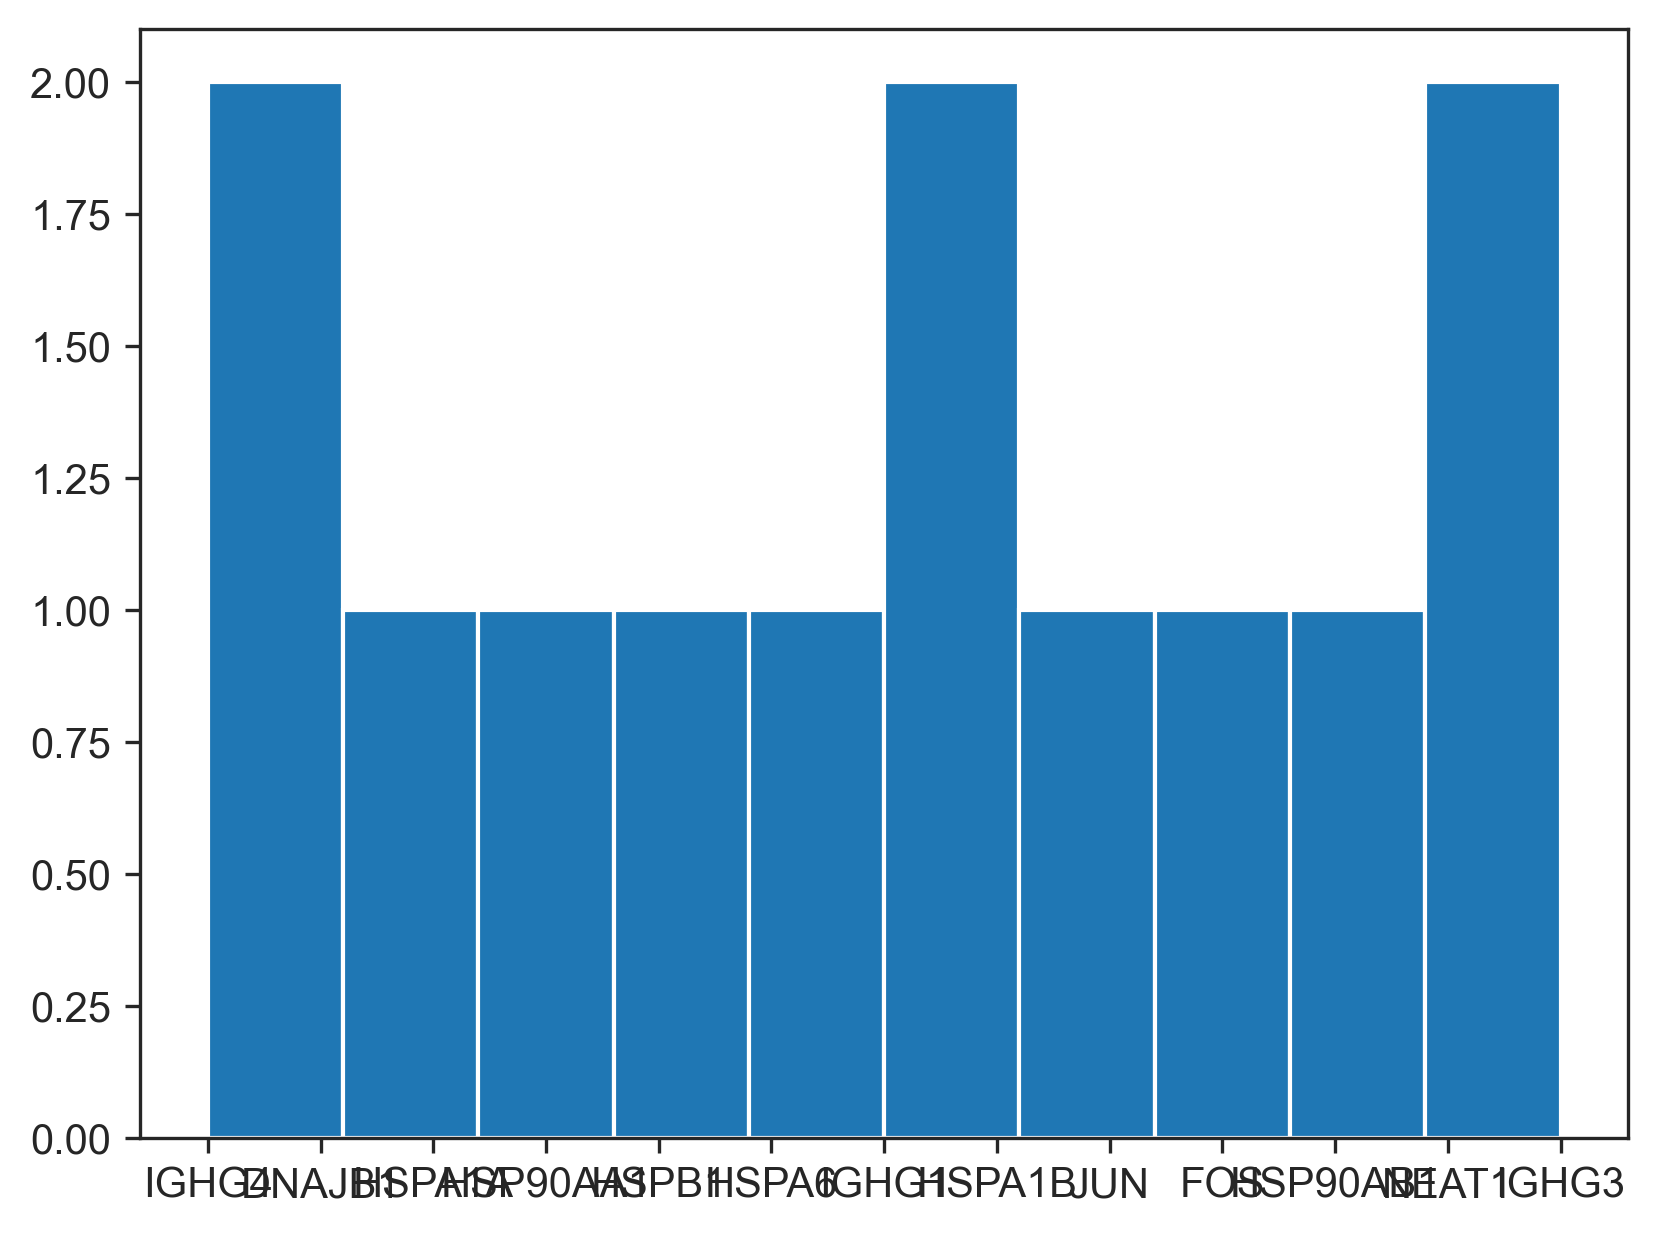

In [35]:
plt.hist(x)

In [6]:
mini = adata[adata.obs["Cluster"].isin(a['pvals'][a['pvals_adj']['mcp_4']==a['pvals_adj']['mcp_4'].min()].index.values)].copy()

KeyError: 'pvals_adj'

AnnData object with n_obs × n_vars = 29091 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    obsm: 'X_pca', 'X_umap'

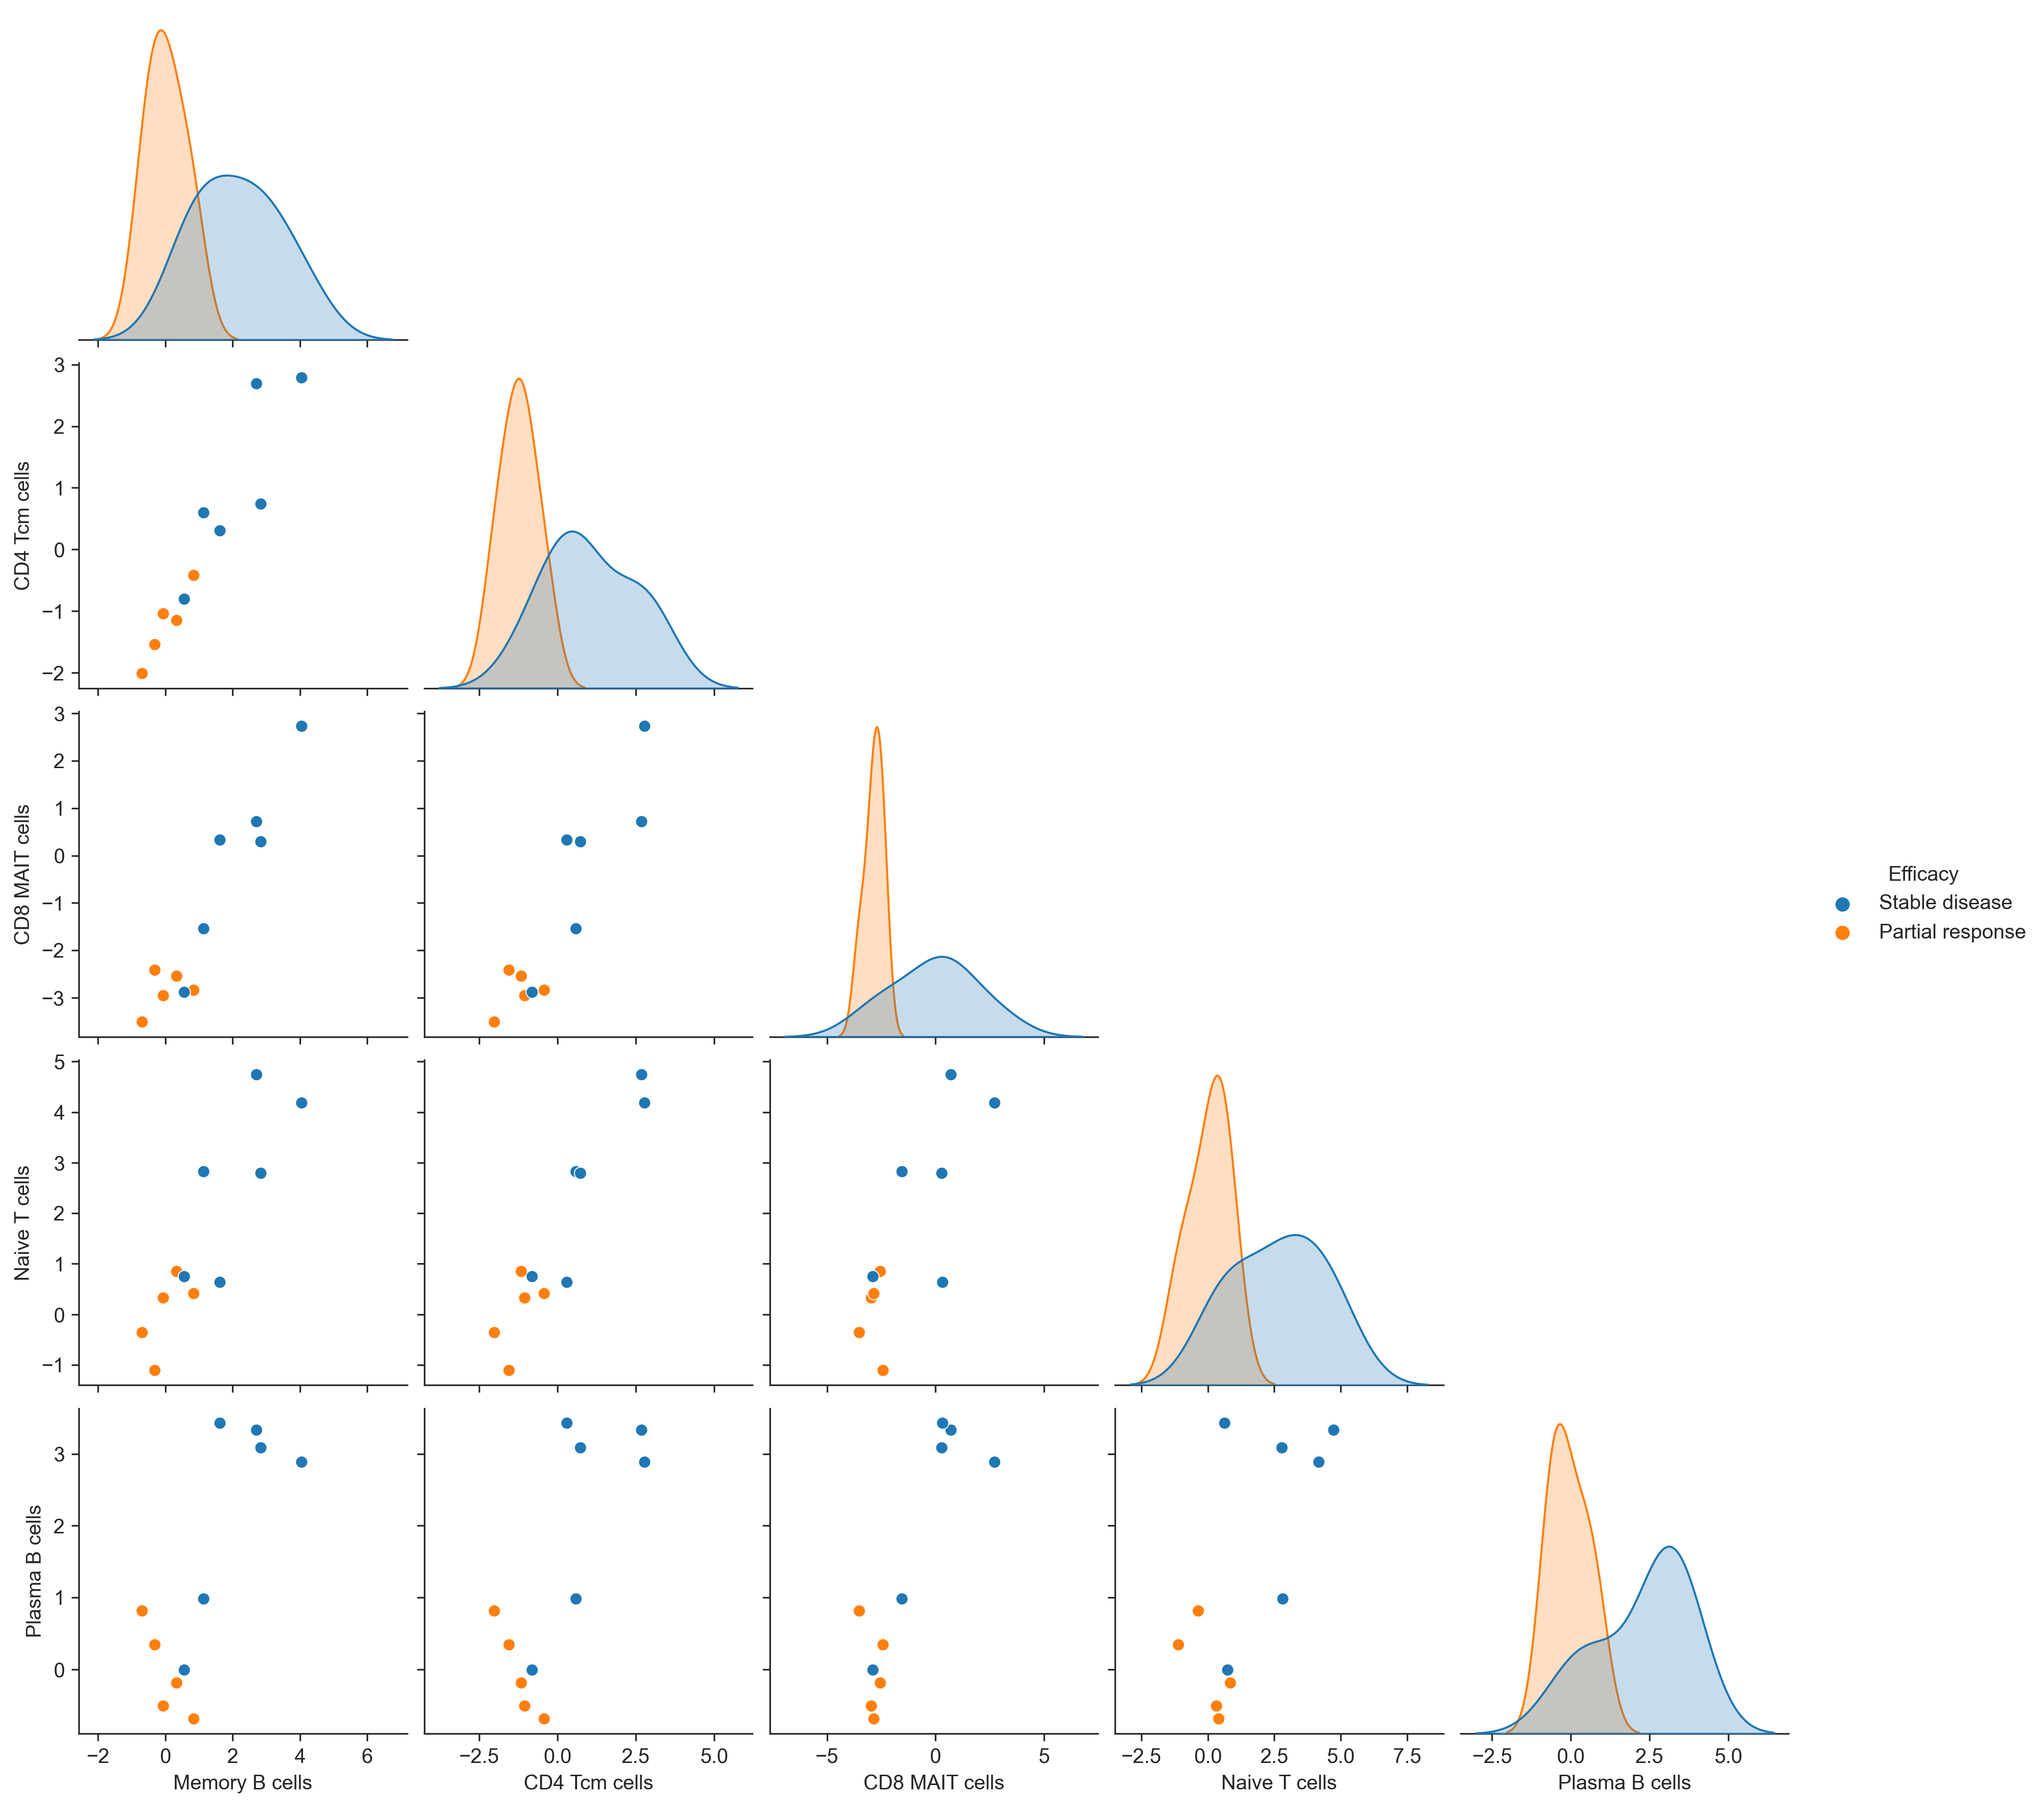

In [73]:
mini.obs = mini.obs.replace({"SD":"Stable disease", "PR":"Partial response"})
mini.obs = mini.obs.replace({"t_CD4_Tcm-LMNA":"CD4 Tcm cells", "t_pB-IGHG1":"Plasma B cells", "t_Bmem-CD27":"Memory B cells",
                            "t_CD8_MAIT-KLRB1" : "CD8 MAIT cells", "t_Tn-LEF1":"Naive T cells" })

mcp_pairsplot(mini, celltype_key = "Cluster", color = "Efficacy", mcp = "mcp_4", sample_key = "Sample")
plt.savefig("output/mini_02_bs_pairsplot.pdf")
plt.savefig("output/mini_02_bs_pairsplot.png")

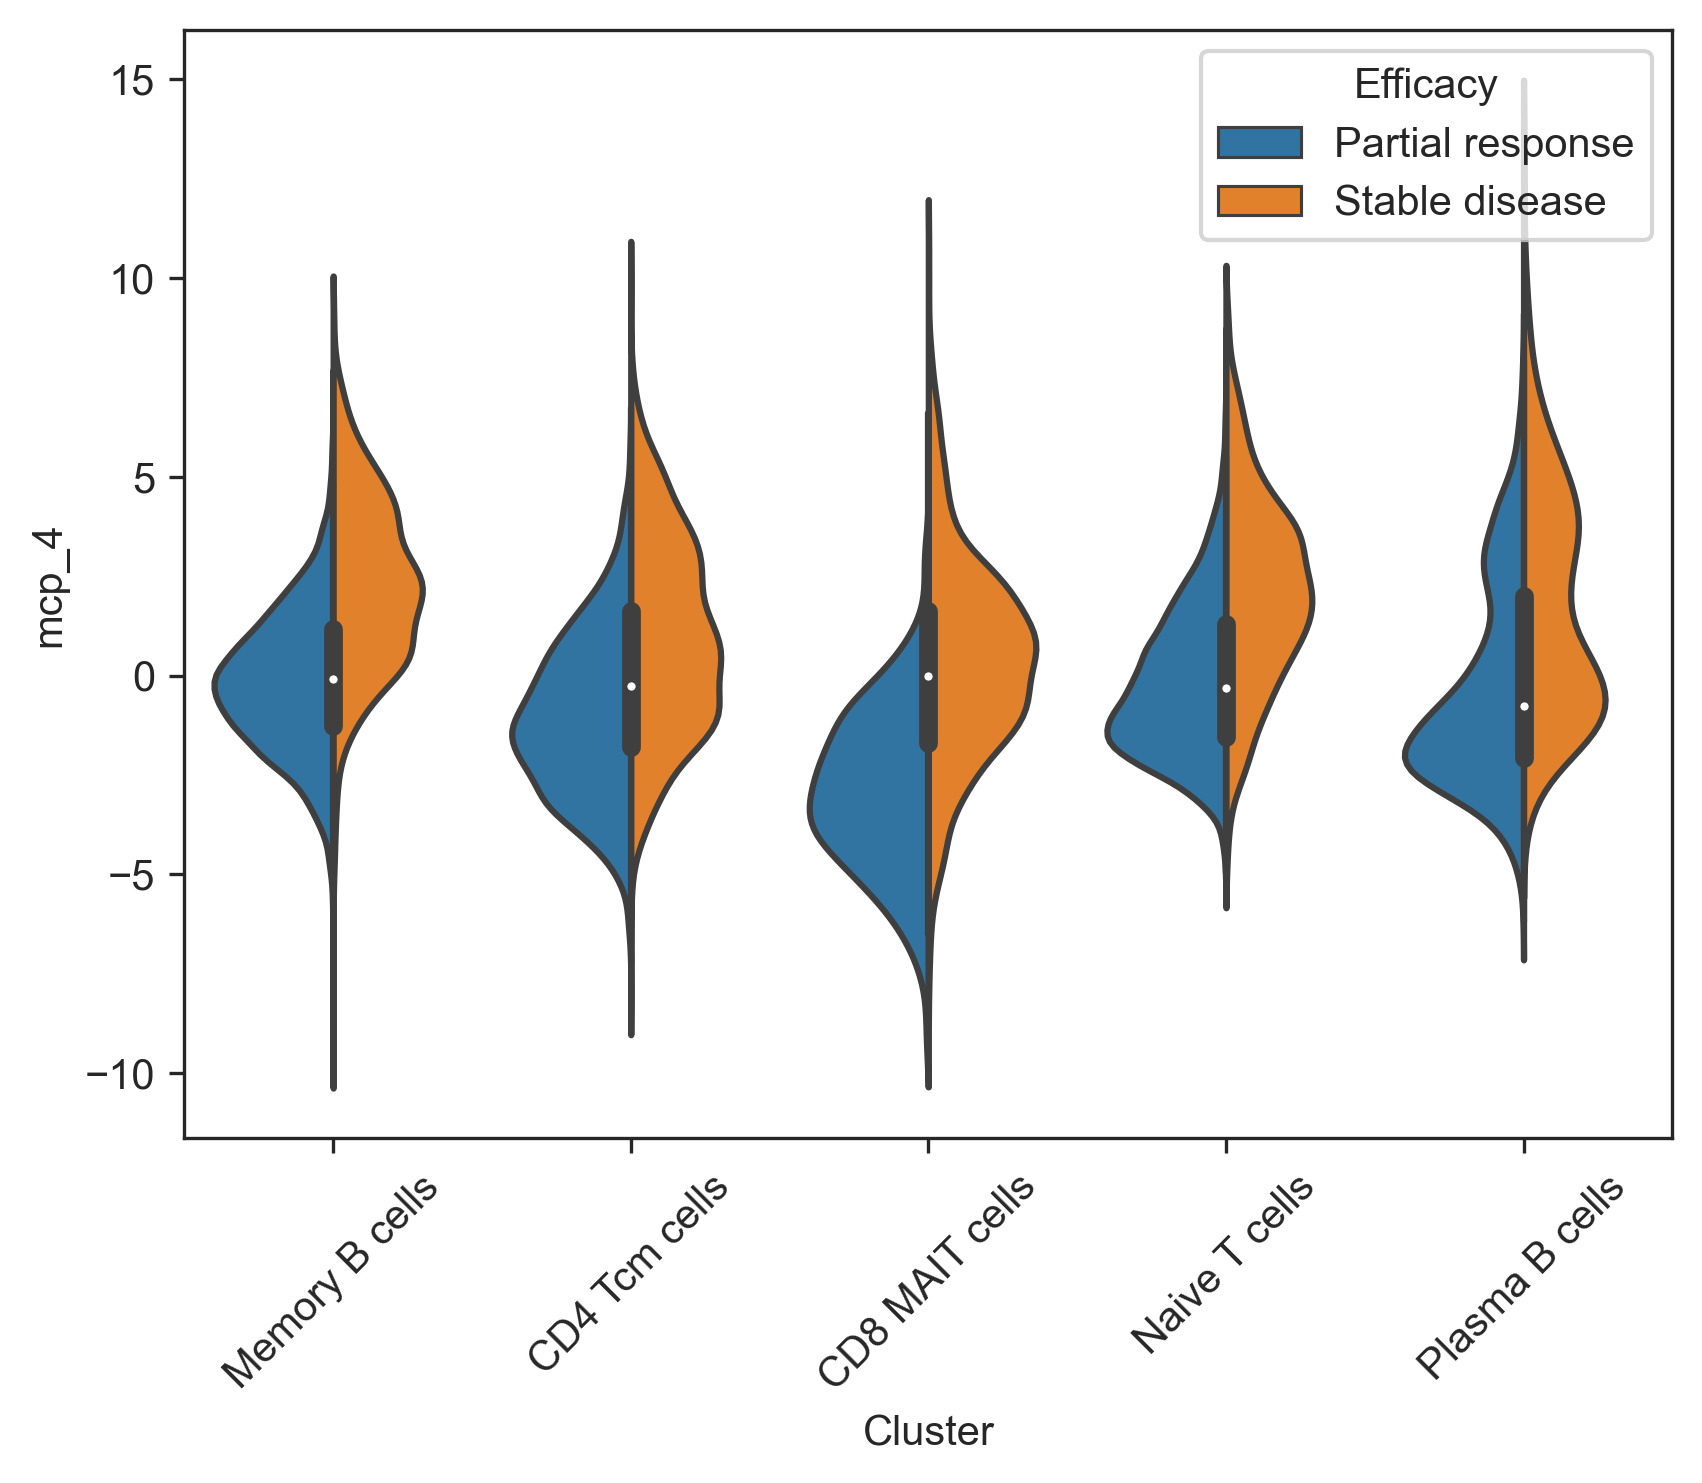

In [74]:
plot_split_violins(mini, mcp="mcp_4")
plt.savefig("output/mini_071023_mcp4_violins.pdf", bbox_inches="tight")
plt.savefig("output/mini_071023_mcp4_violins.png", bbox_inches="tight")

In [75]:
# create a new column in mini.obs which is the obs.Treatment string and the obs.Efficacy string with an '_' in between
# this is the new column: obs.Treatment_Efficacy

mini.obs['Treatment_Efficacy']= mini.obs['Treatment'].astype('str') + '_' + mini.obs['Efficacy'].astype('str')

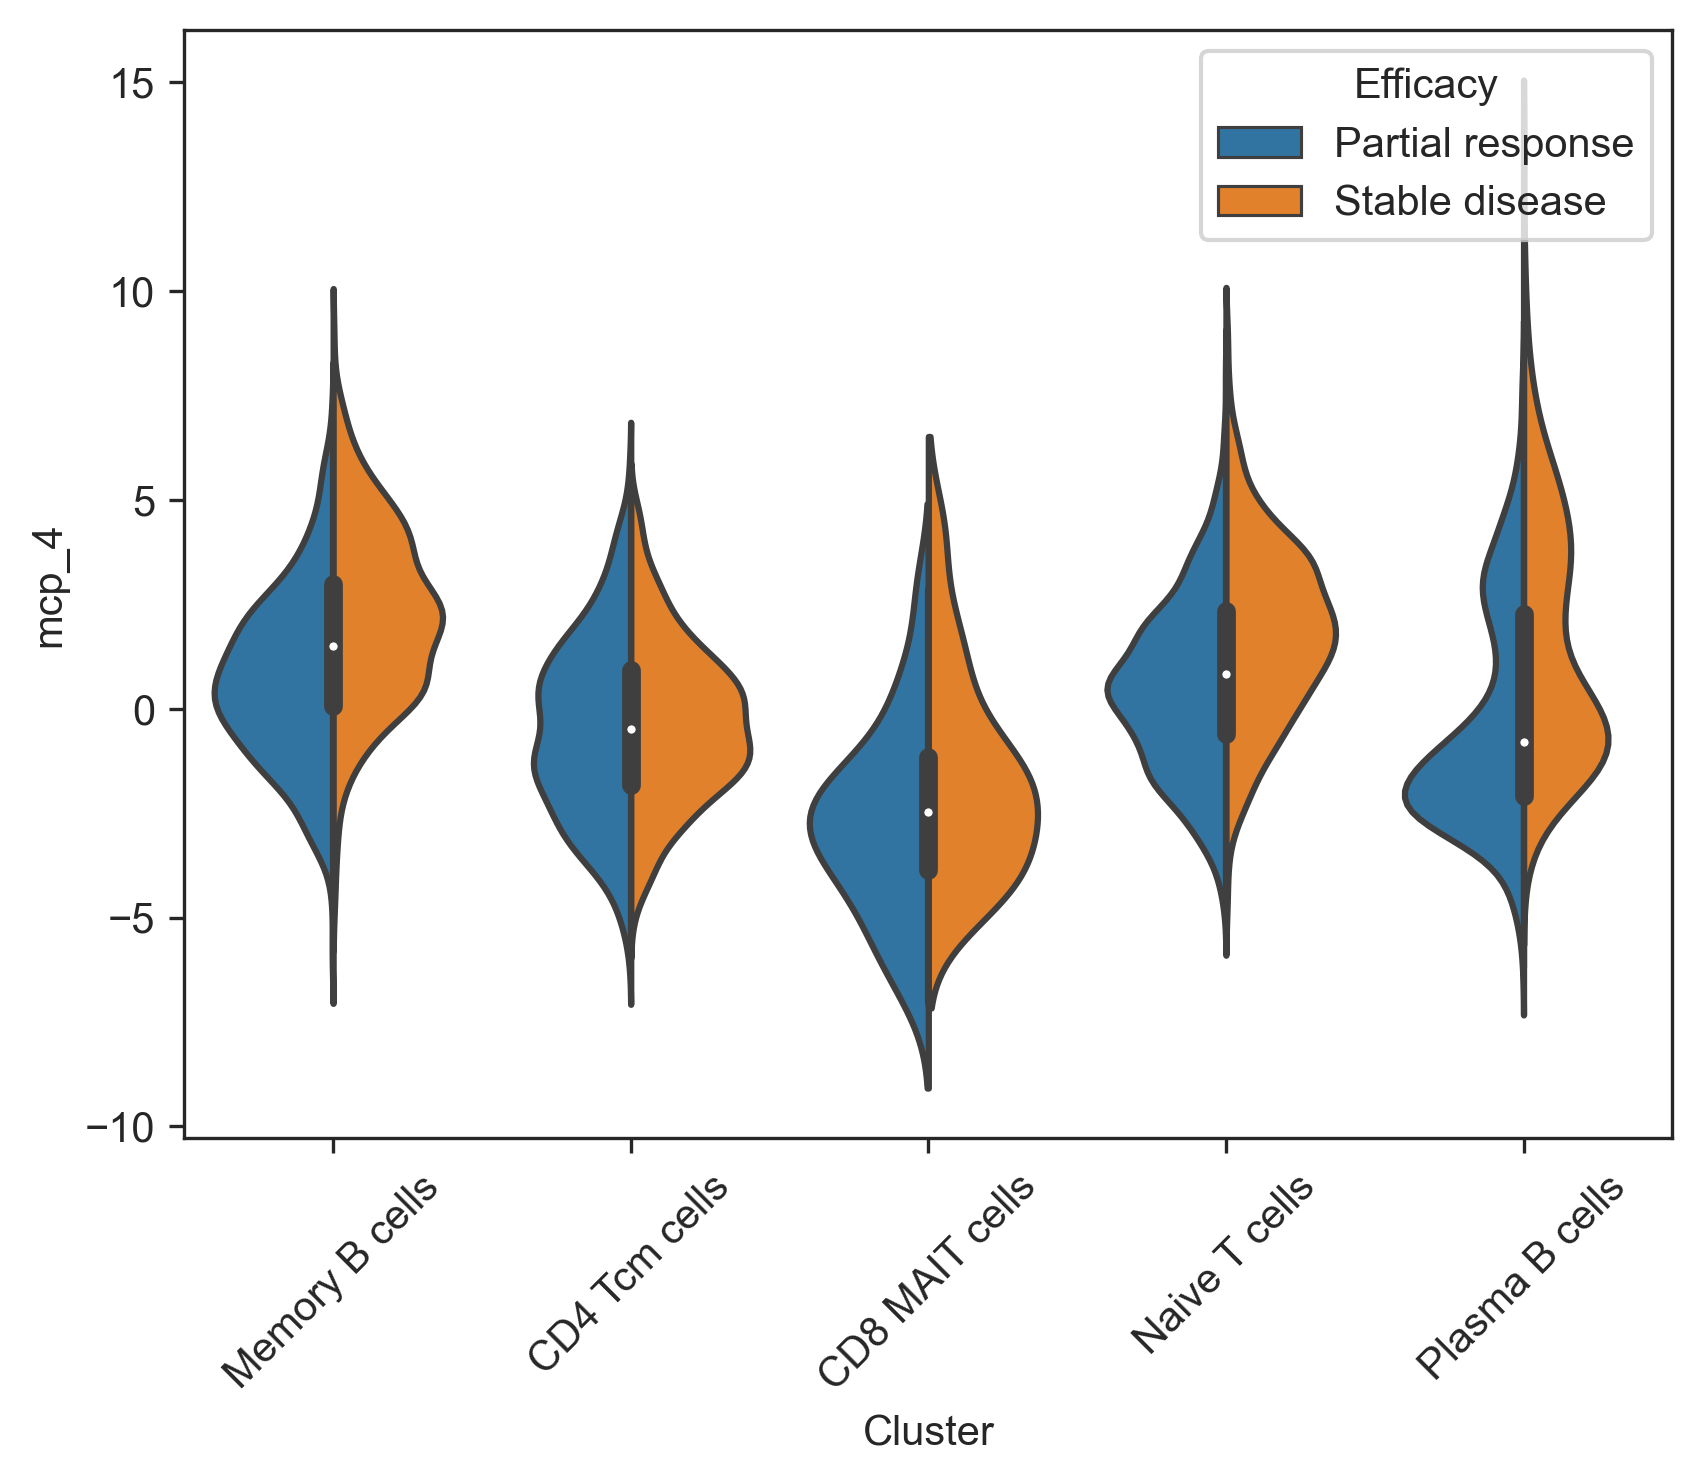

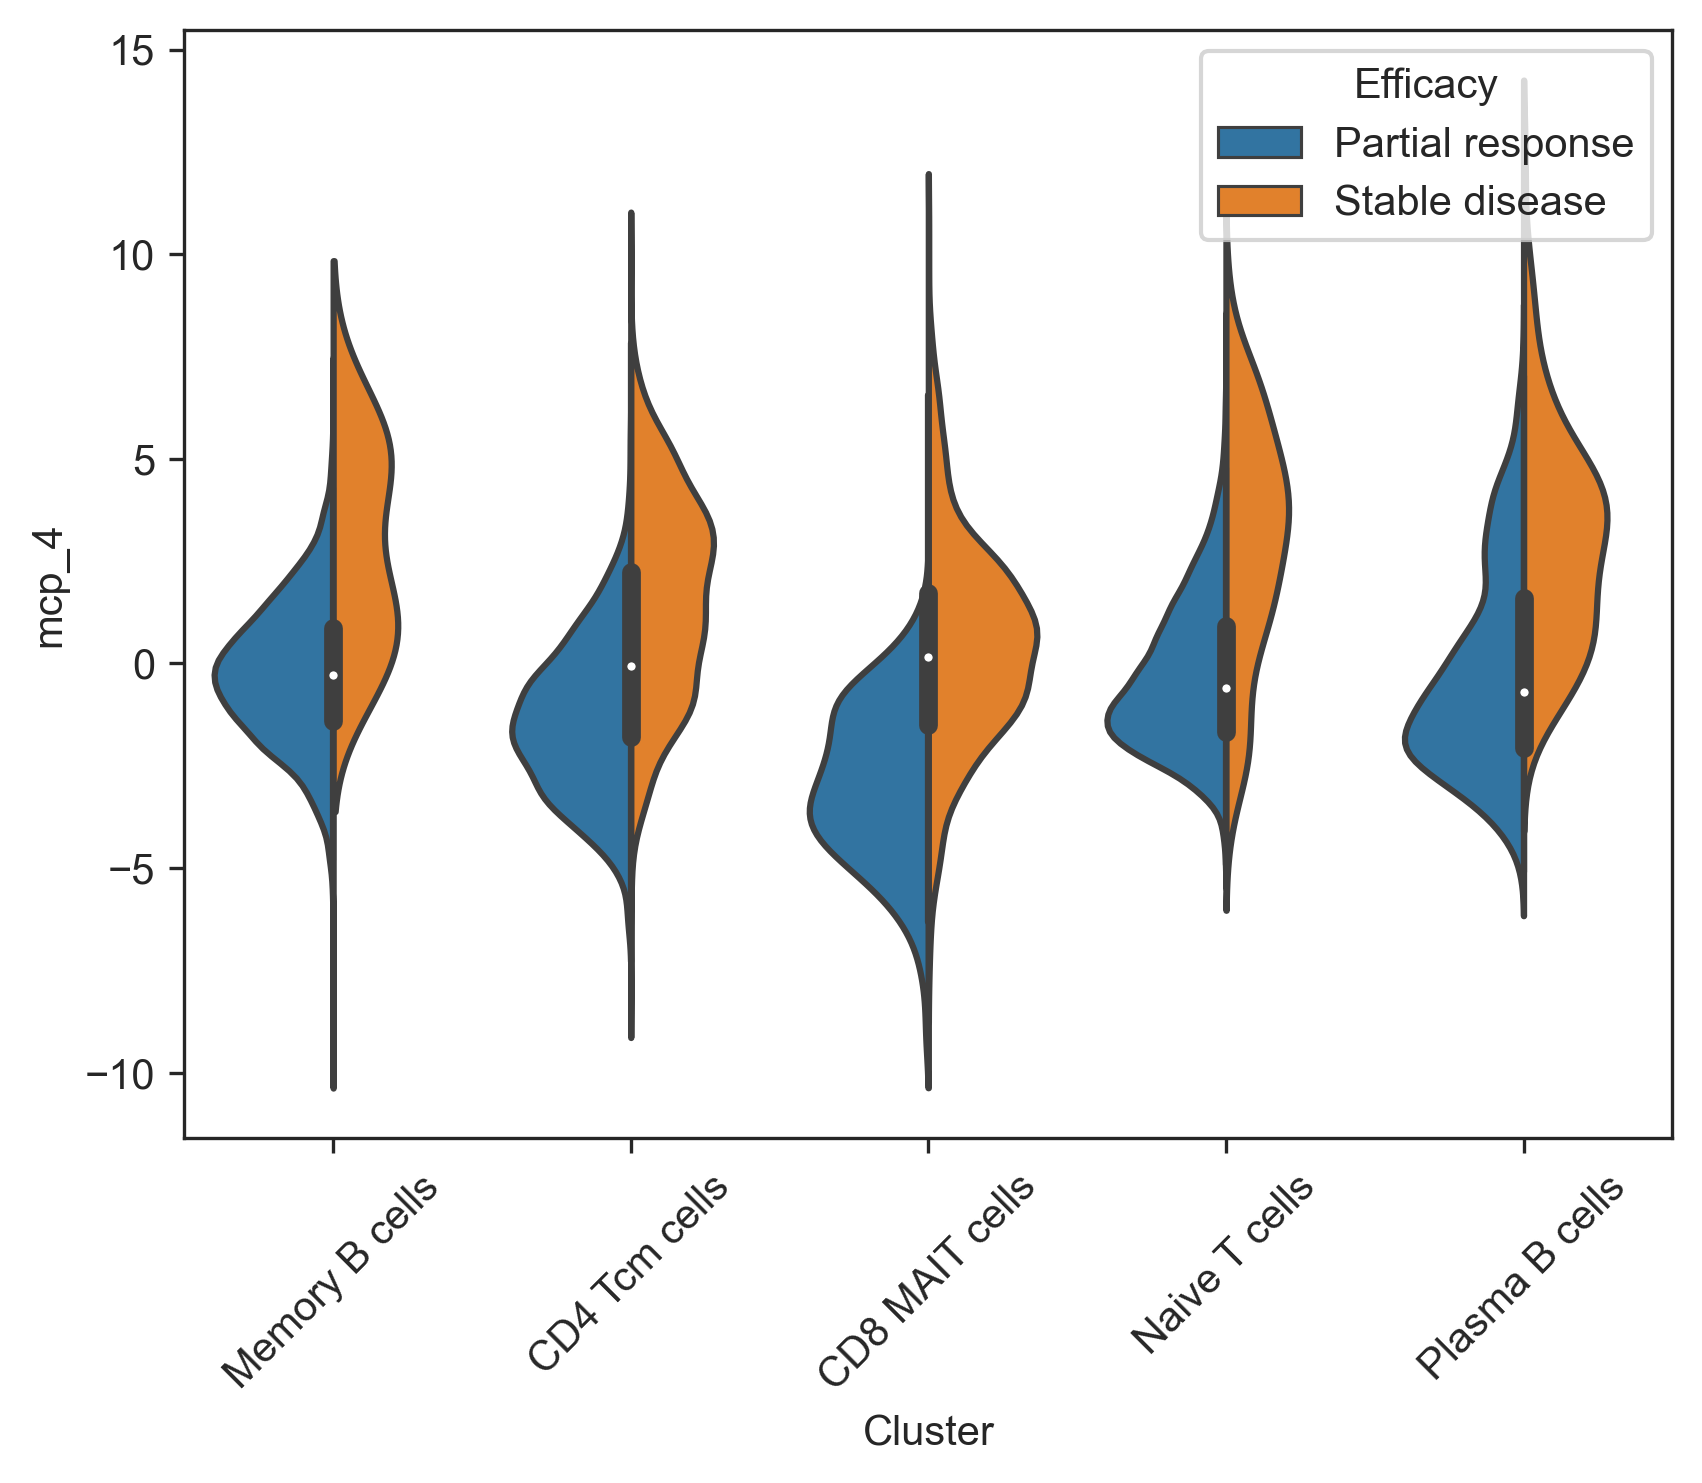

In [76]:
plot_split_violins(mini[mini.obs['Treatment']=="Chemo"], mcp="mcp_4")
plt.show()
plot_split_violins(mini[mini.obs['Treatment']!="Chemo"], mcp="mcp_4")


In [77]:
mini.obs['Treatment'].value_counts()

Anti-PD-L1+Chemo    21447
Chemo                7644
Name: Treatment, dtype: int64

In [78]:
from scperturb import equal_subsampling

In [79]:
mini_sub = equal_subsampling(mini, obs_key = "Sample")


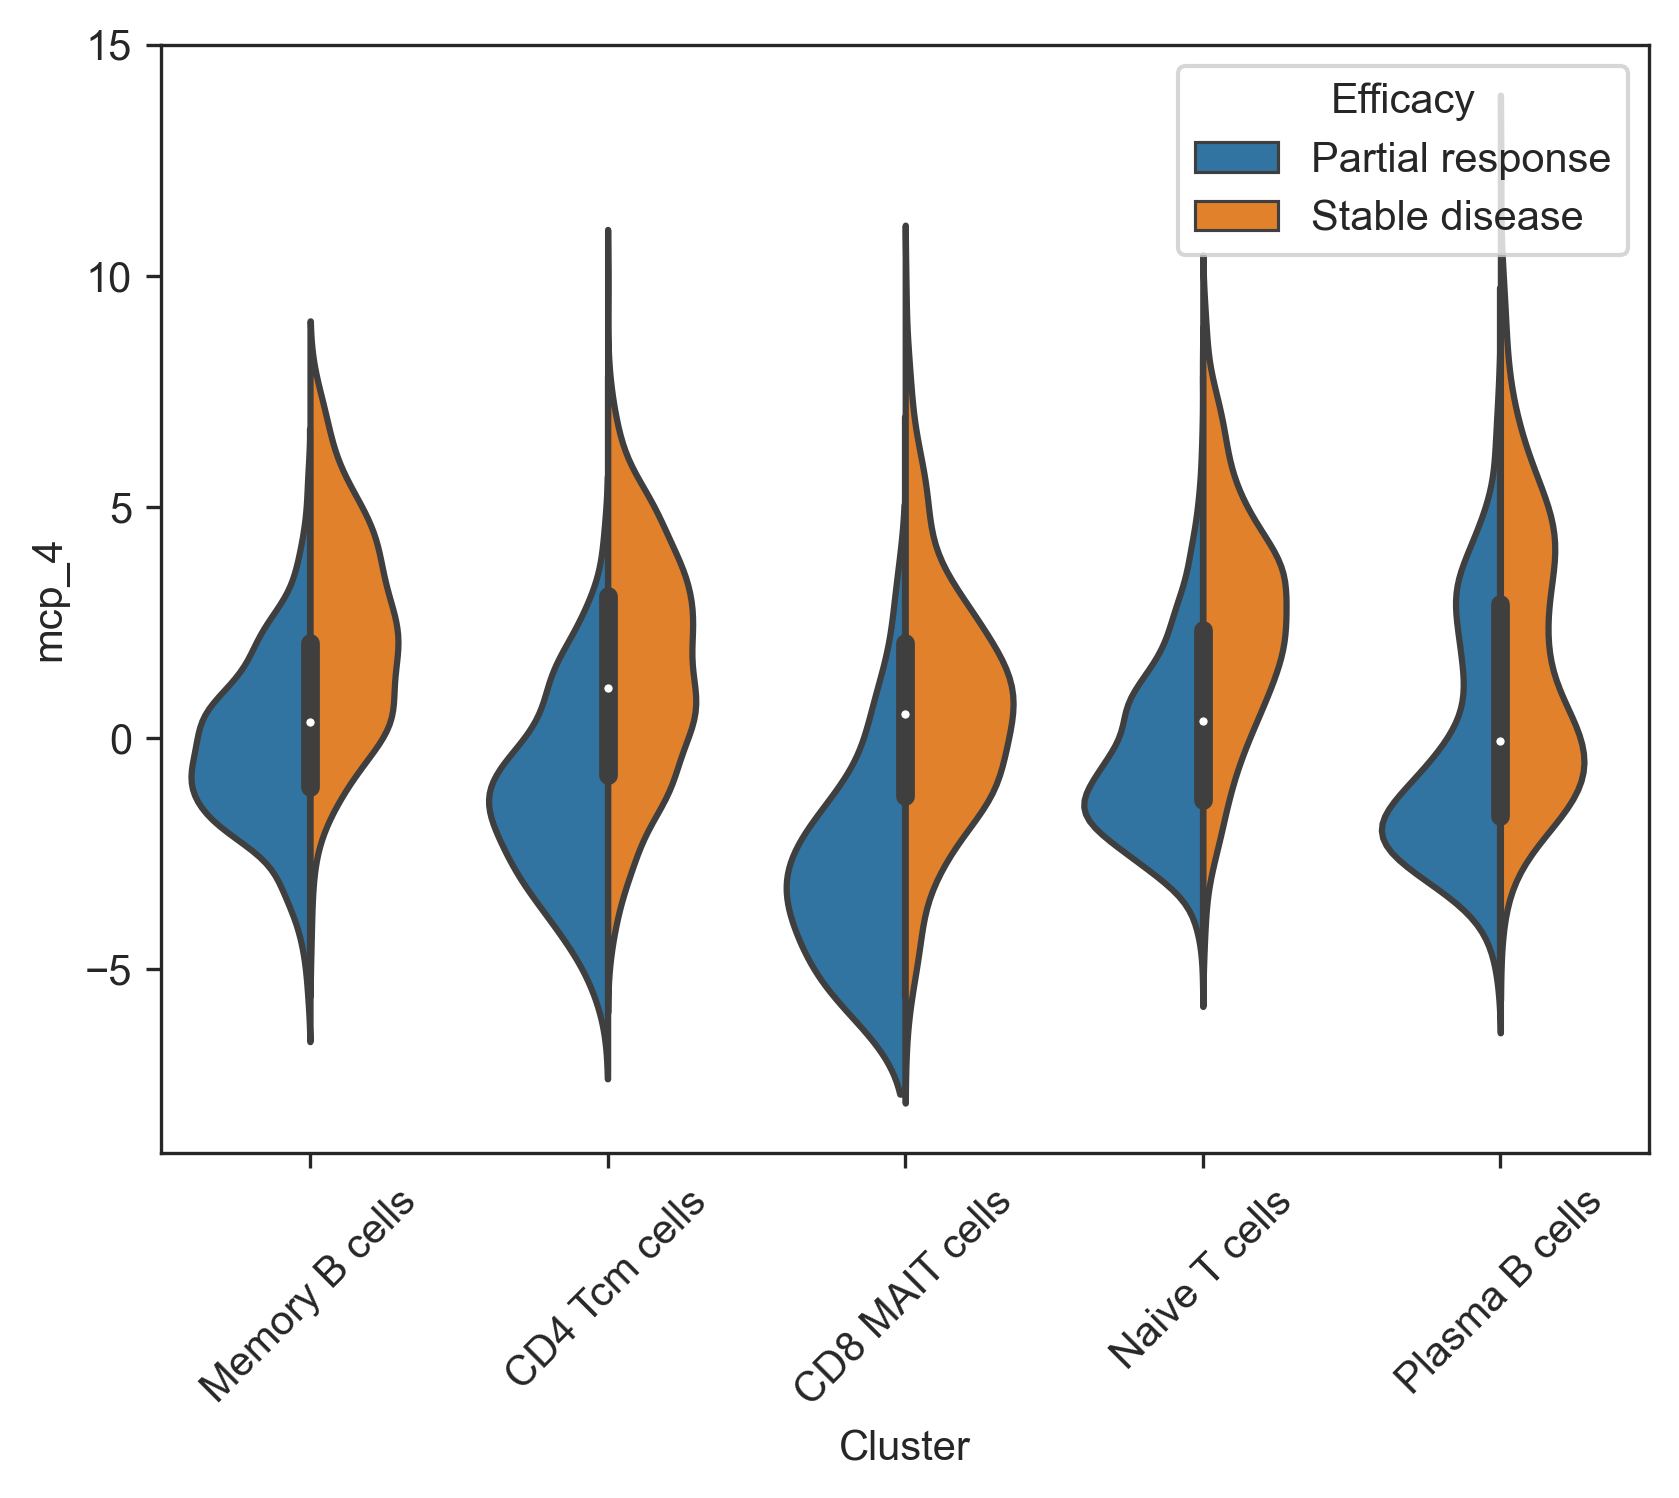

In [80]:
plot_split_violins(mini_sub, mcp="mcp_4")

In [564]:
a['pvals_adj']['mcp_4']

t_Bmem-CD27         0.021844
t_CD4_Tcm-LMNA      0.021844
t_CD4_Treg-FOXP3    0.031923
t_CD8_MAIT-KLRB1    0.021844
t_CD8_Tem-GZMK      0.031923
t_CD8_Trm-ZNF683    0.031923
t_Tn-LEF1           0.021844
t_mono-FCN1         0.079806
t_pB-IGHG1          0.021844
Name: mcp_4, dtype: float64

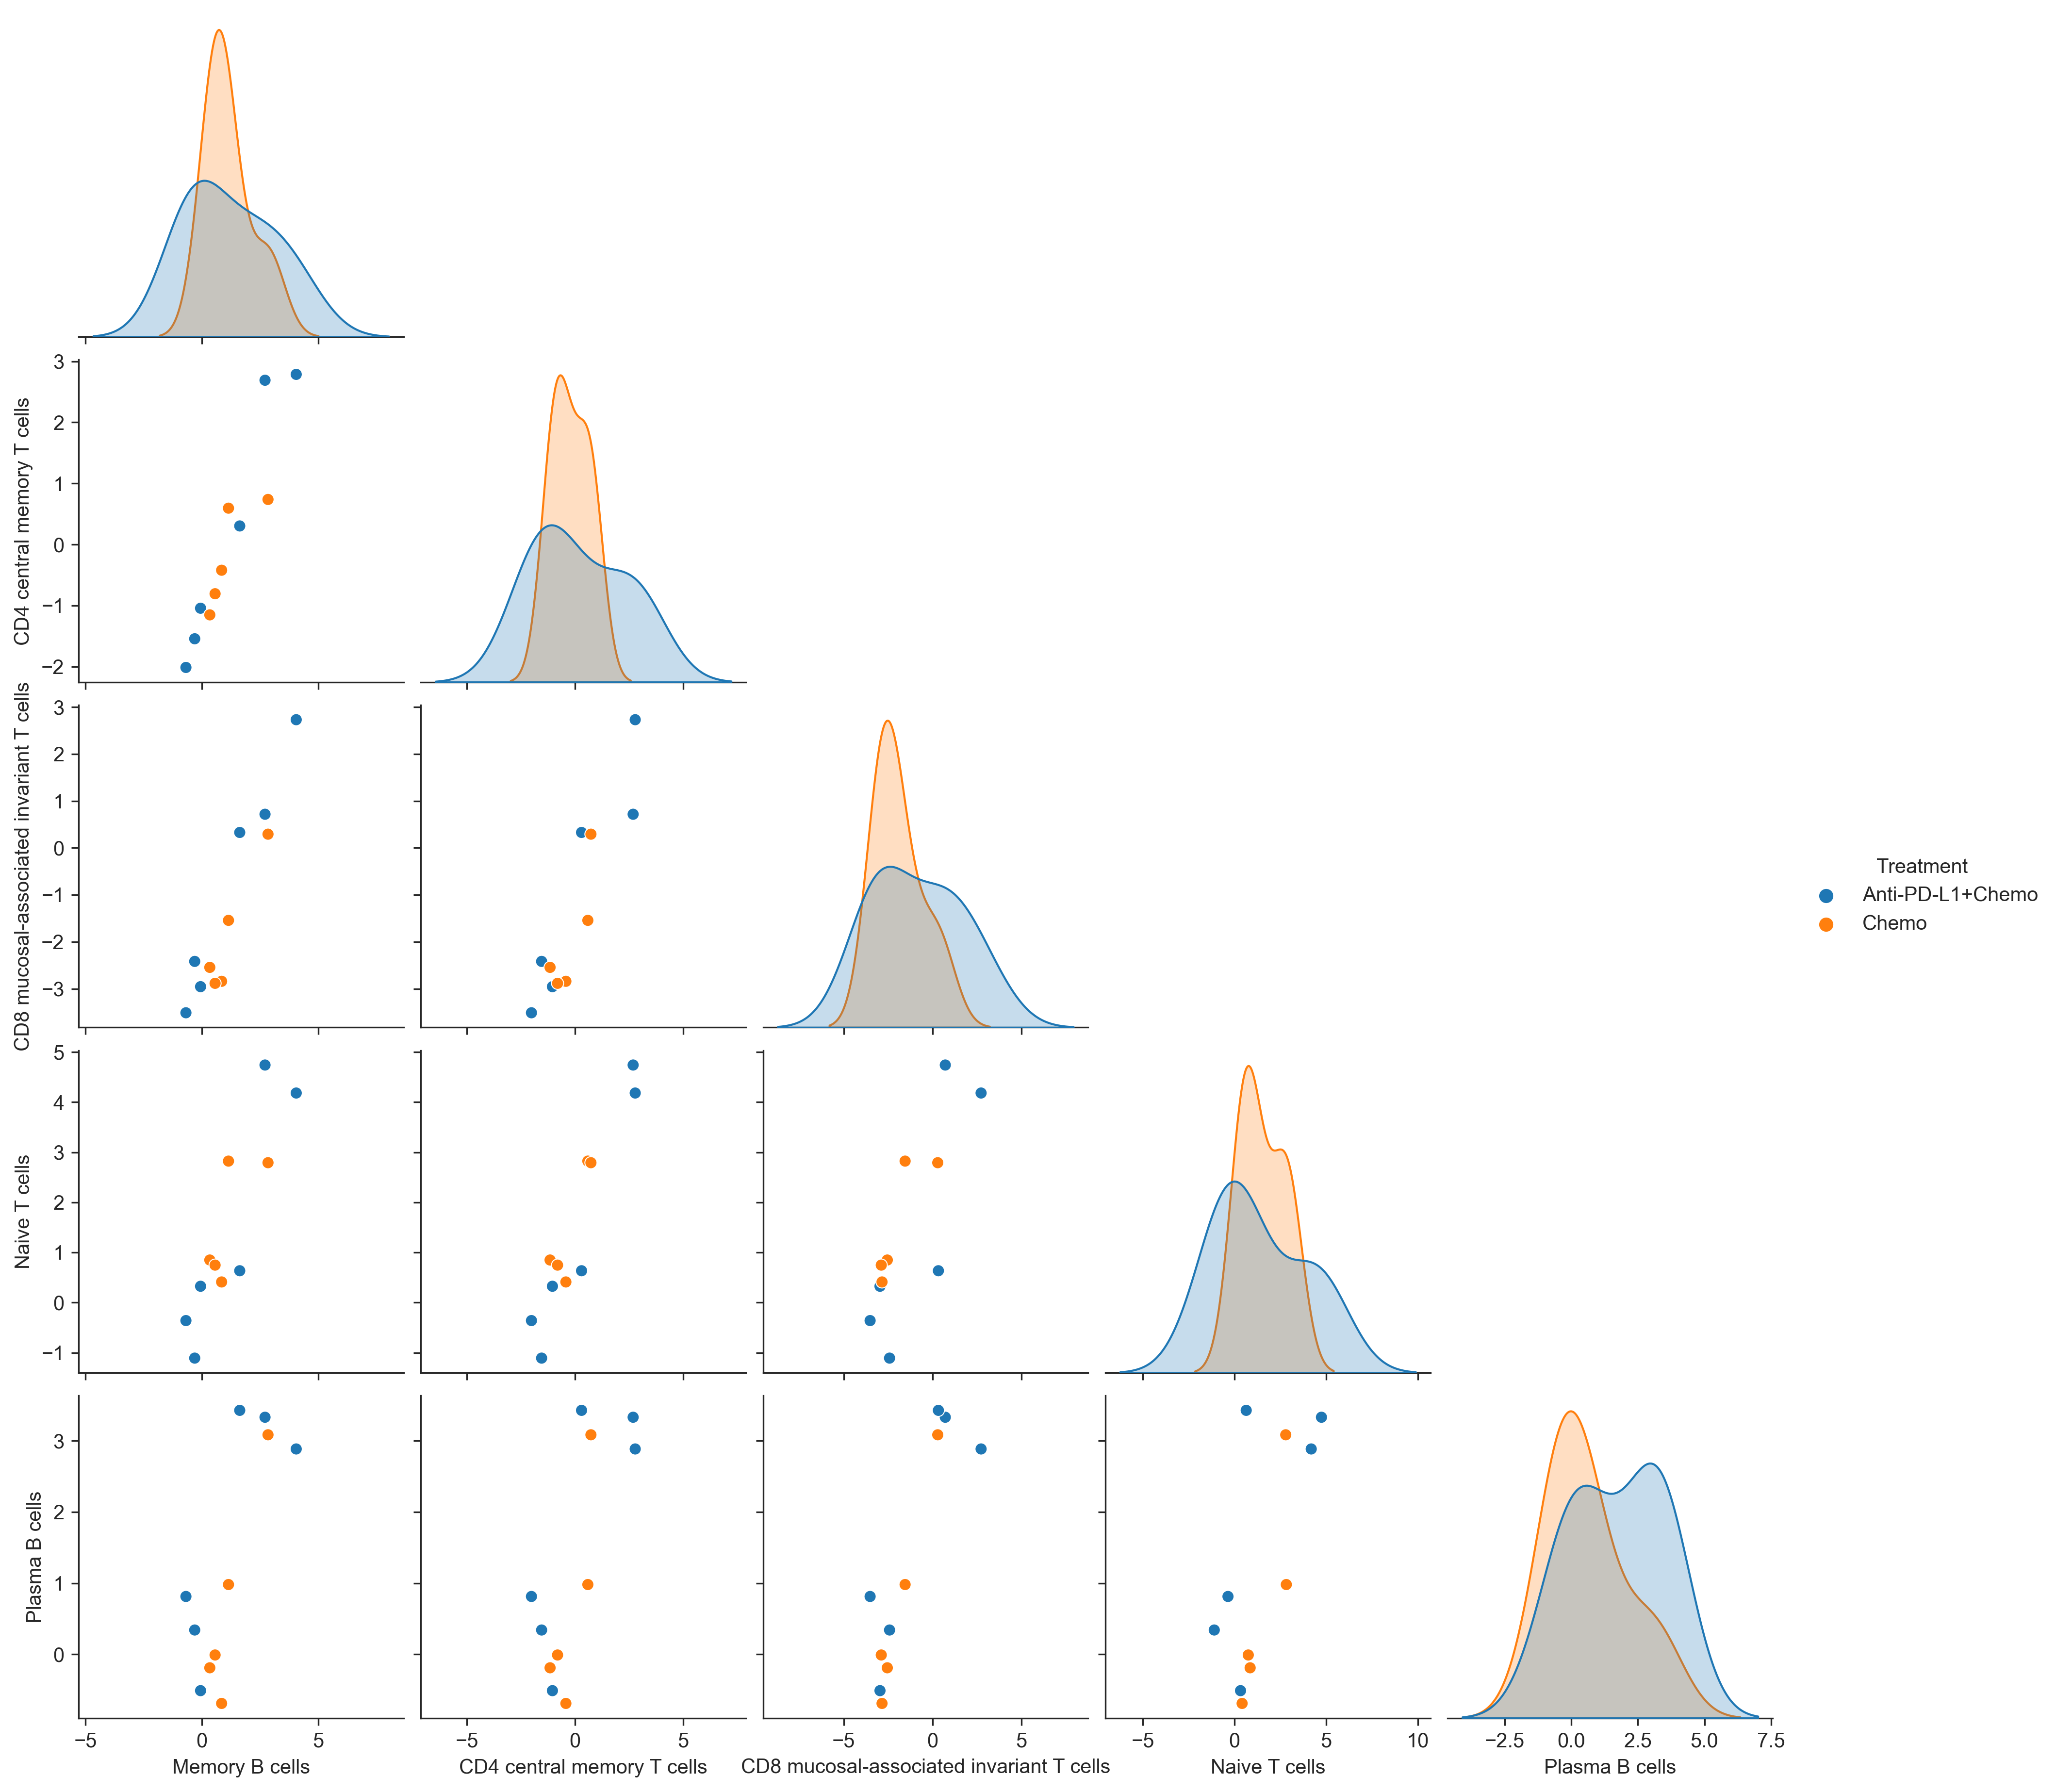

In [566]:
mcp_pairsplot(mini, celltype_key = "Cluster", color = "Treatment", mcp = "mcp_4", sample_key = "Sample")


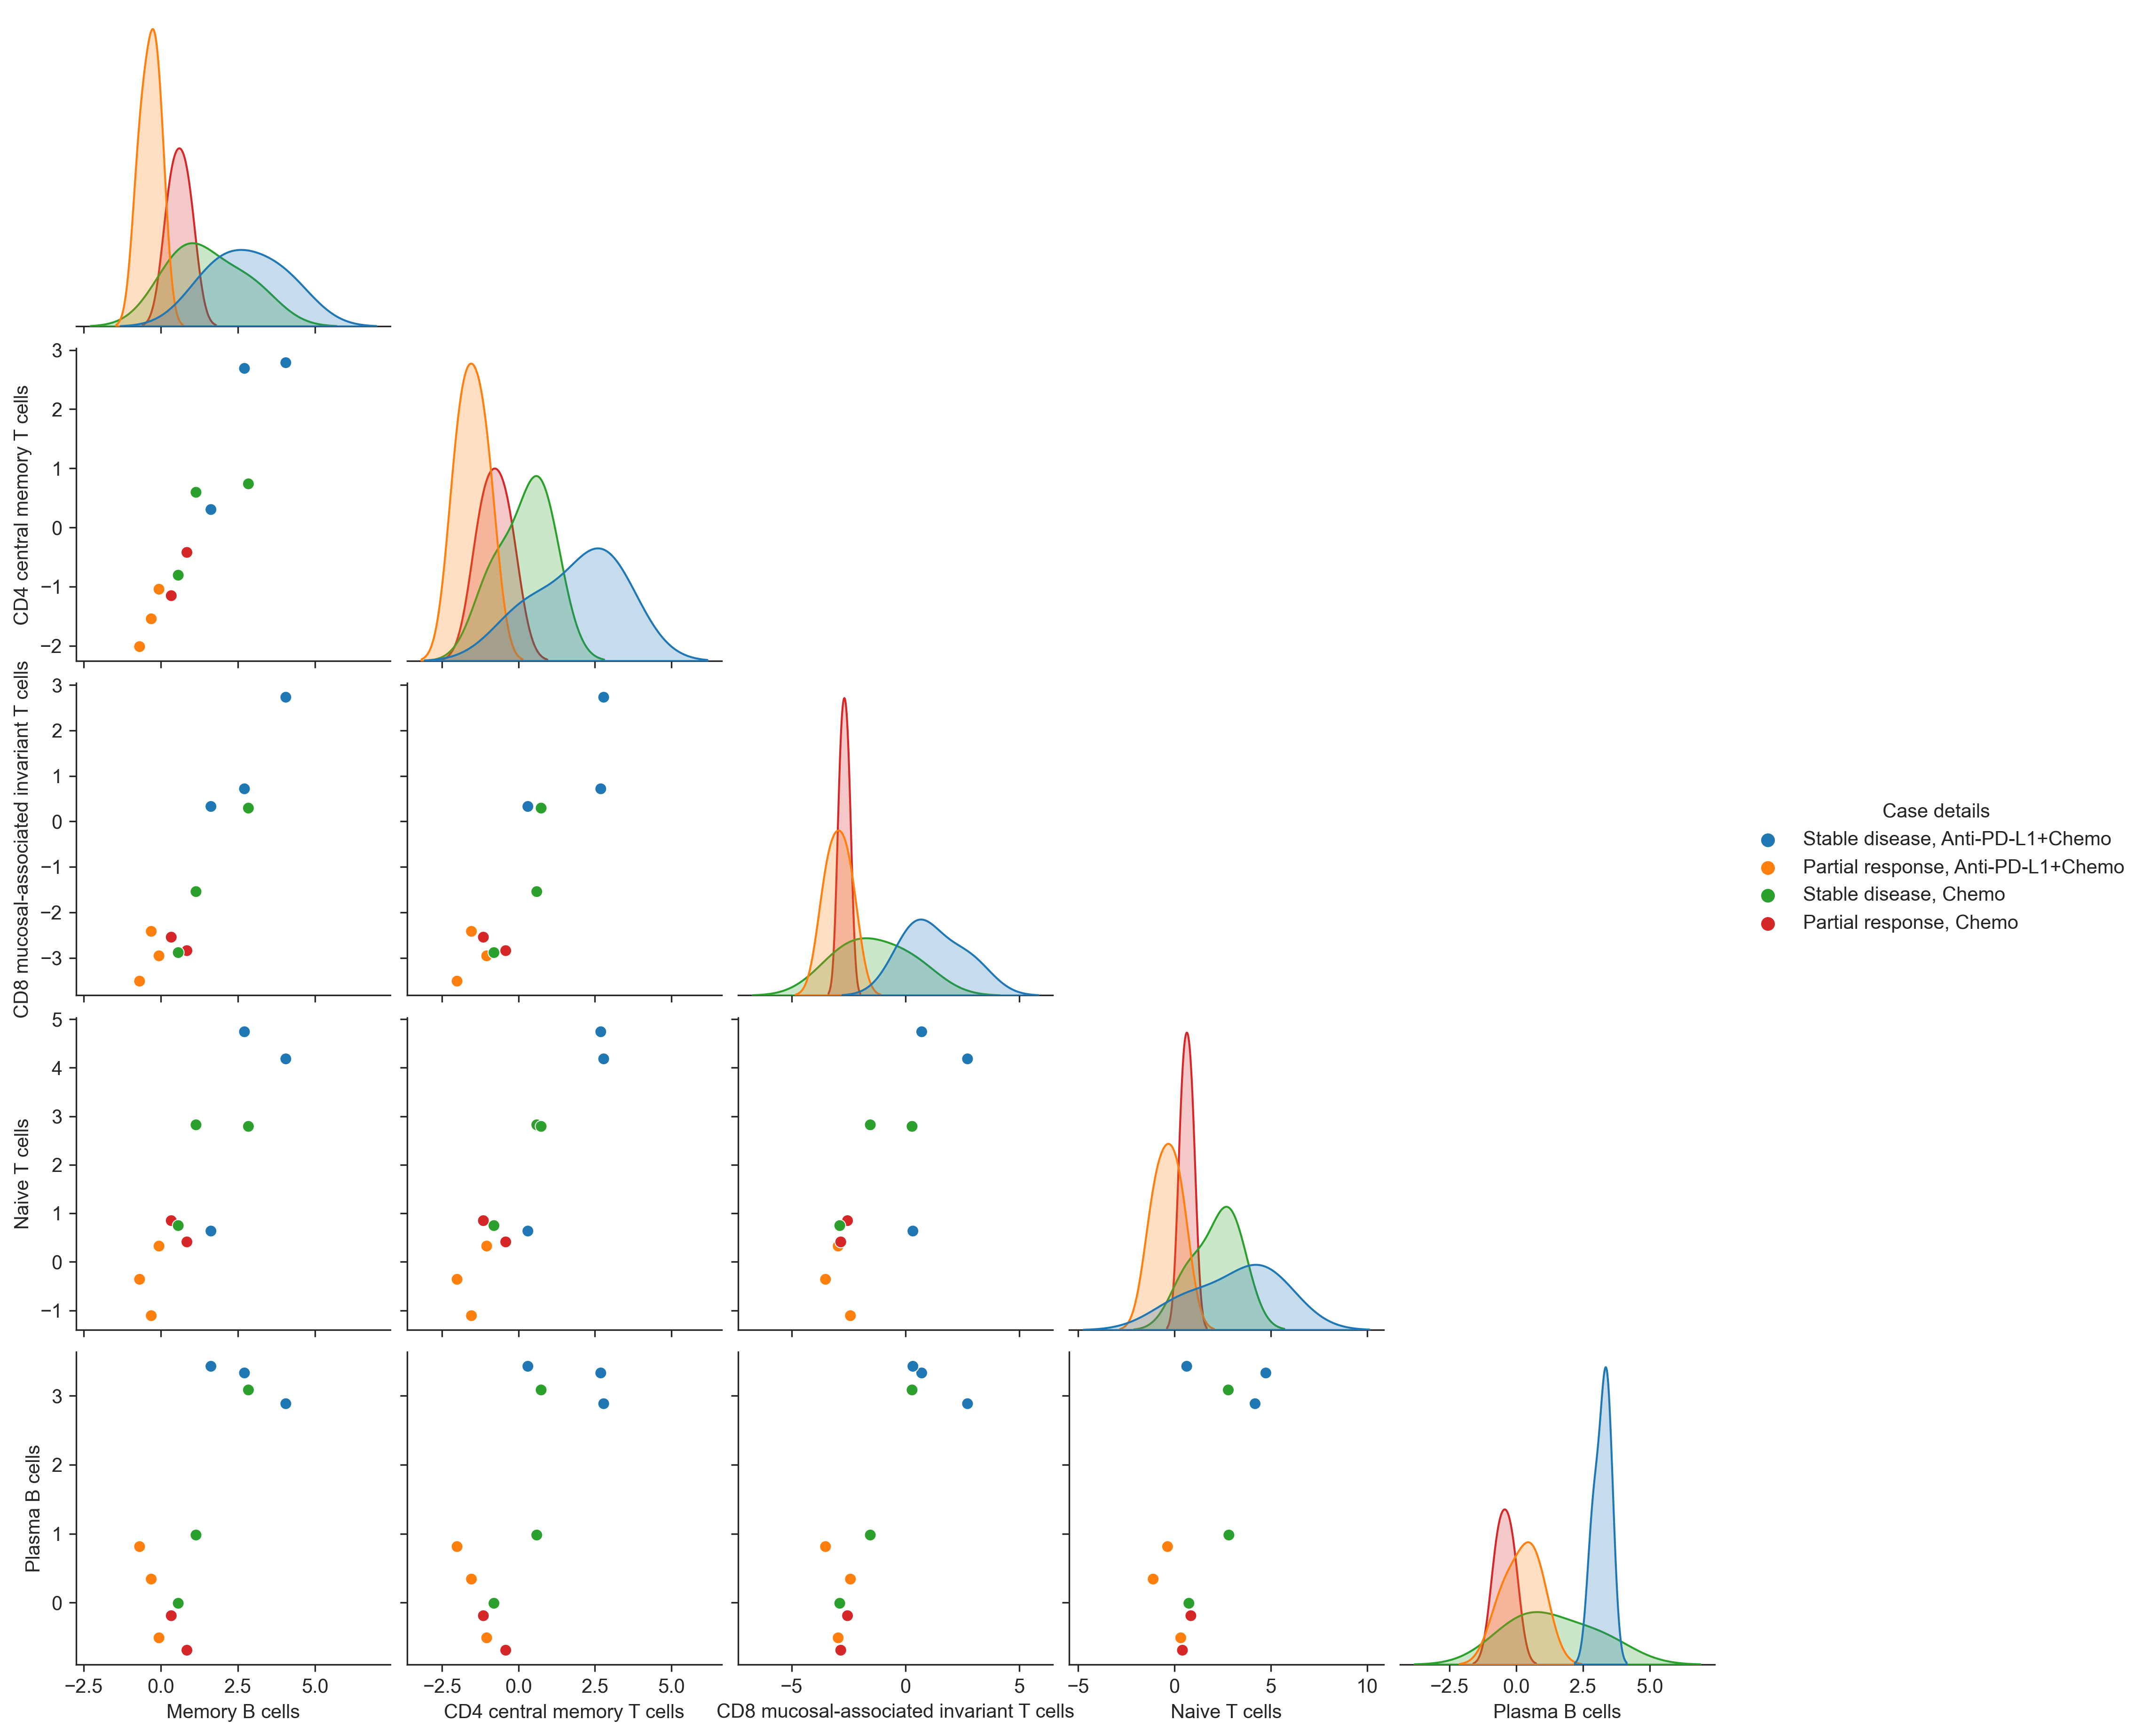

In [573]:
mcp_pairsplot(mini, celltype_key = "Cluster", color = "Case details", mcp = "mcp_4", sample_key = "Sample")
plt.savefig("output/mini_03_bs_pairsplot.pdf")
plt.savefig("output/mini_03_bs_pairsplot.png")

In [9]:
mini2  = adata[adata.obs["Cluster"].isin(["t_Bmem-CD27", "t_CD4_Tcm-LMNA", "t_Tn-LEF1"])]
mini2.obs["Case details"] = mini2.obs['Efficacy'].astype(str) +', ' +  mini2.obs['Treatment'].astype(str)

In [10]:
mini2.obs["Case details"] = mini2.obs['Efficacy'].astype(str) +', ' +  mini2.obs['Treatment'].astype(str)
mini2.obs = mini2.obs.replace({"SD":"Stable disease", "PR":"Partial response"})
mini2.obs = mini2.obs.replace({"t_CD4_Tcm-LMNA":"CD4 Tcm cells", "t_pB-IGHG1":"Plasma B cells", "t_Bmem-CD27":"Memory B cells",
                            "t_CD8_MAIT-KLRB1" : "CD8 MAIT cells", "t_Tn-LEF1":"Naive T cells" })

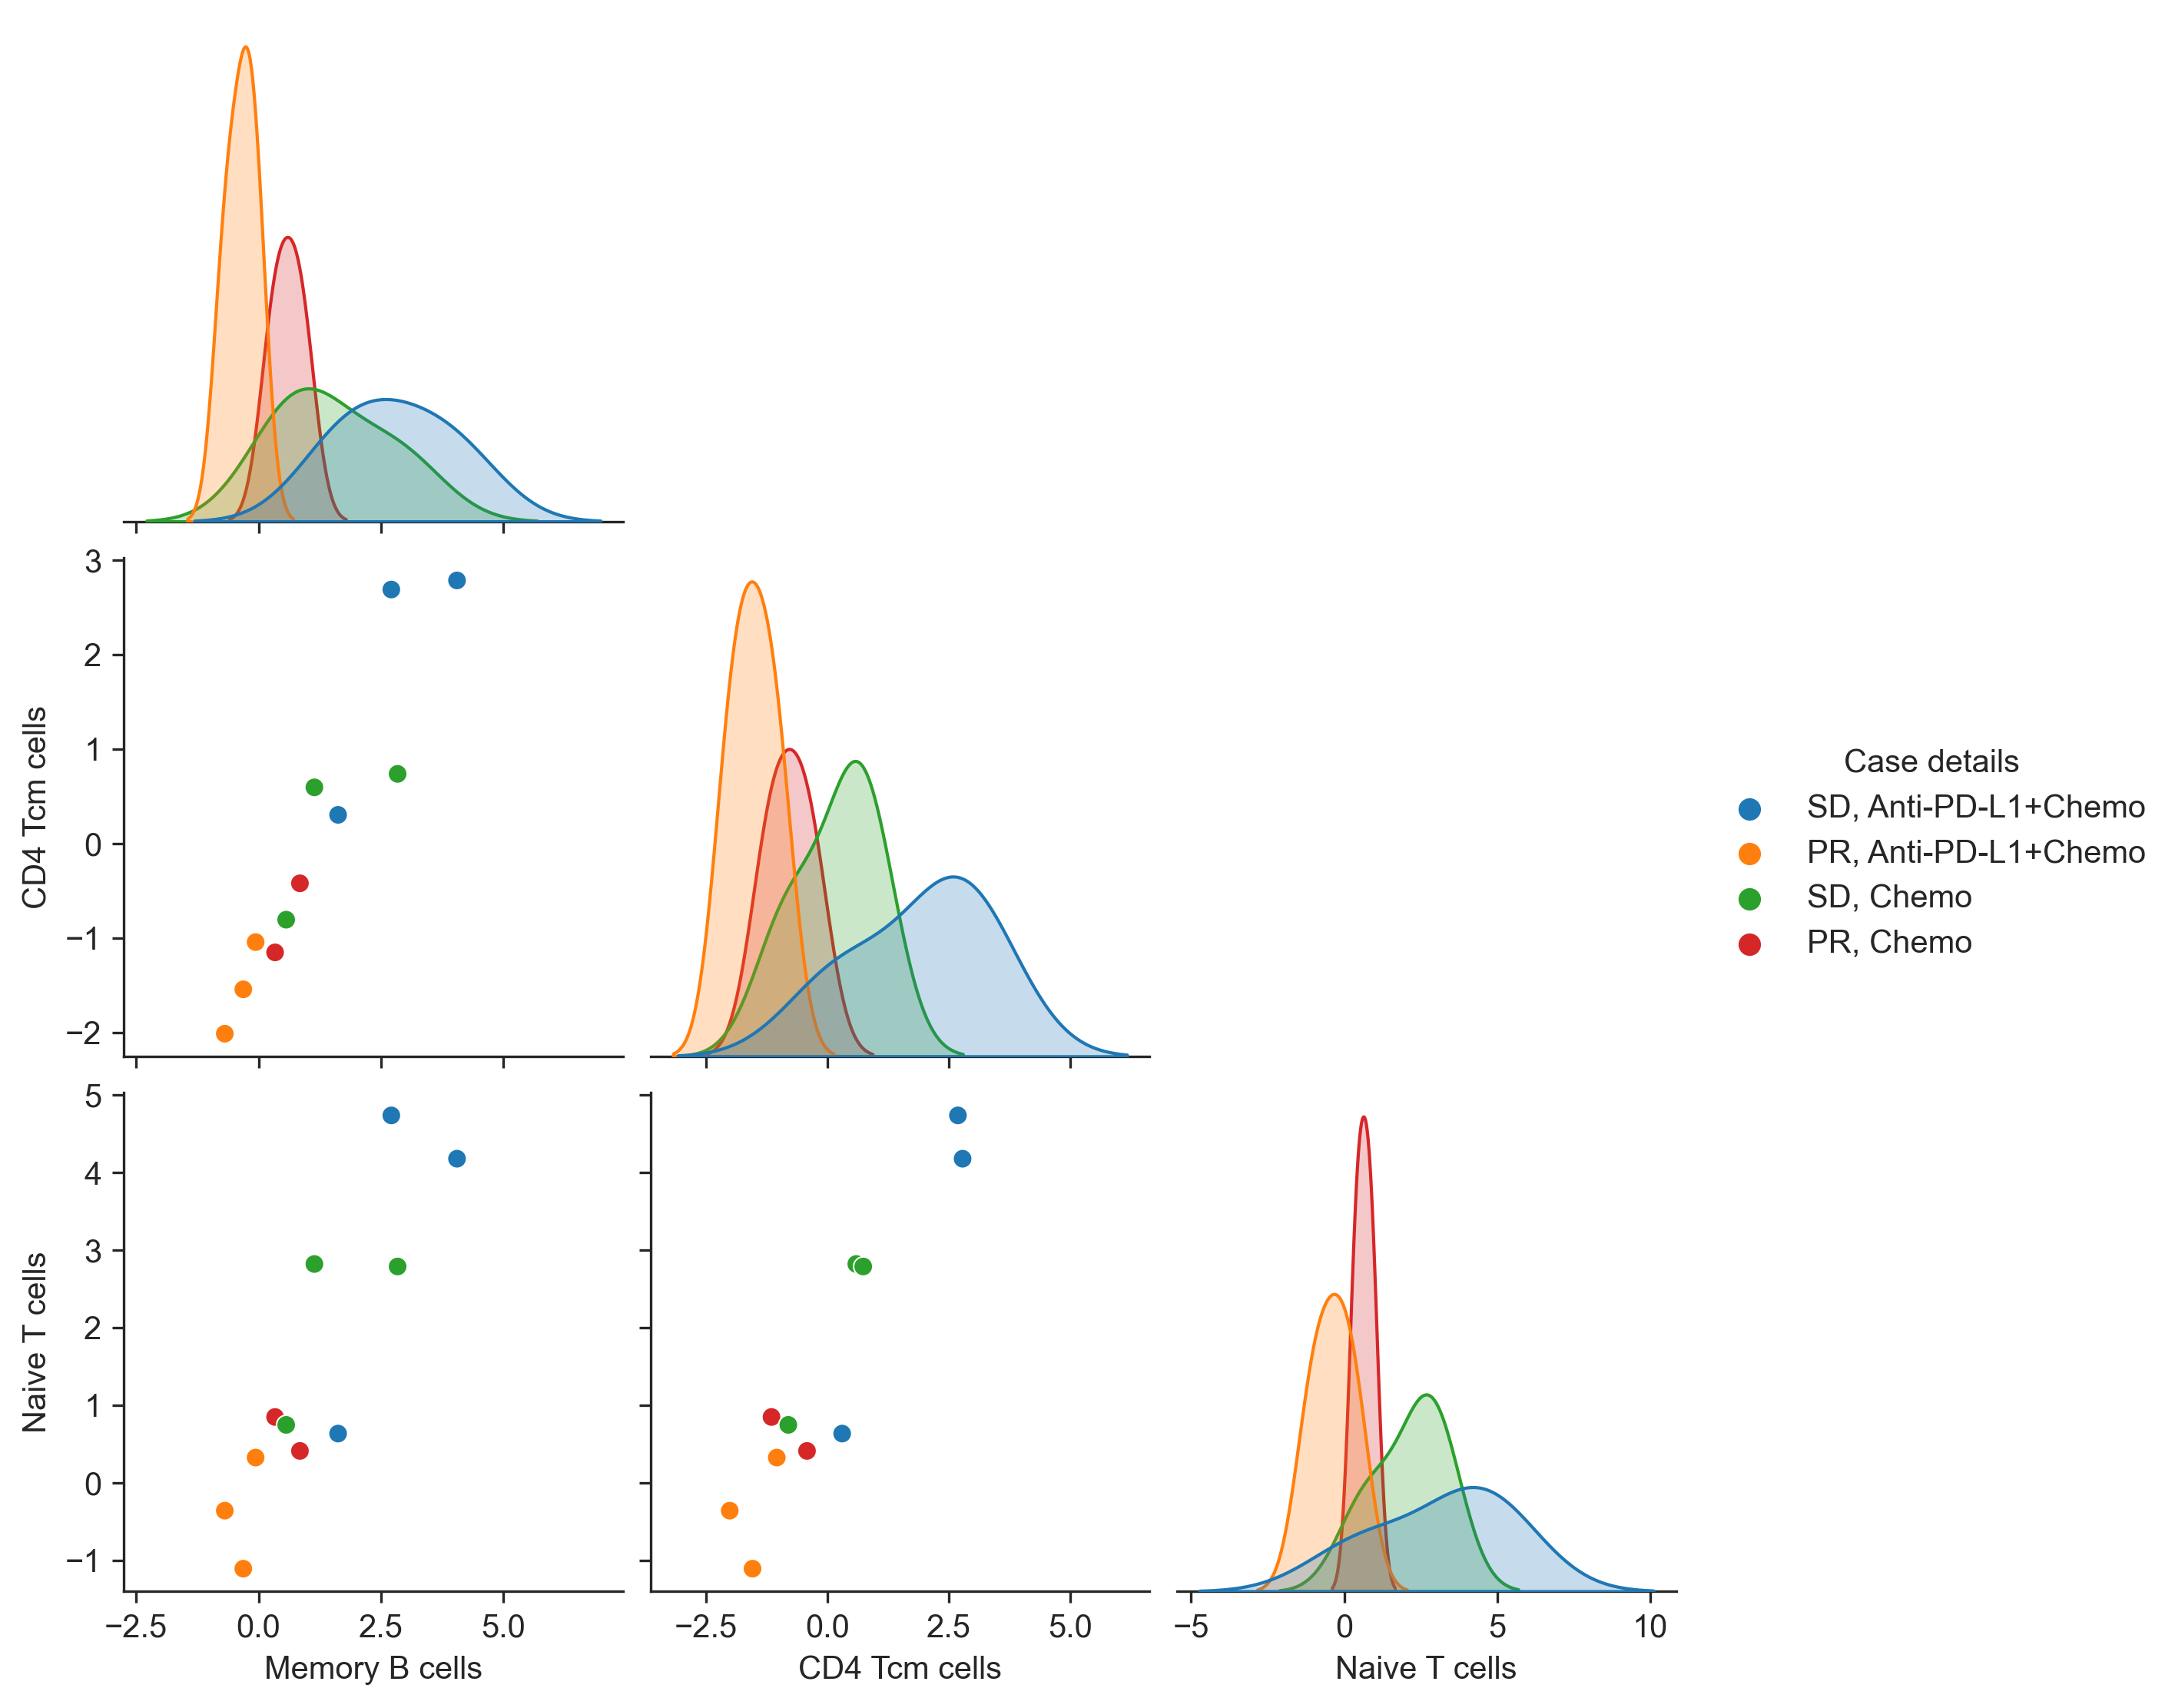

In [11]:
mcp_pairsplot(mini2, celltype_key = "Cluster", color = "Case details", mcp = "mcp_4", sample_key = "Sample")
plt.savefig("output/mini2_03_bs_pairsplot.pdf")
plt.savefig("output/mini2_03_bs_pairsplot.png")

In [83]:
genes_hilo

{'t_Bmem-CD27': {'mcp_0_up': ['RPS3A',
   'MT-ND4L',
   'CD24',
   'MT-ND3',
   'RPL13',
   'RPL36A',
   'MT-CYB',
   'EEF1A1',
   'MT-ATP6',
   'RPL3',
   'RPS18',
   'RPL41',
   'VPREB3',
   'RPS21',
   'RPL8',
   'LY9',
   'MT-ATP8',
   'EEF1B2',
   'MGP',
   'GAPDH',
   'VIM',
   'FDCSP',
   'CD24',
   'LGALS3',
   'KRT19',
   'S100A10',
   'S100A11',
   'S100A6',
   'ACTG2',
   'LGALS1',
   'BGN',
   'MMP7',
   'KRT14',
   'HLA-B',
   'SAA1',
   'GZMA',
   'RPS26',
   'MIF',
   'S100A1',
   'CSTB',
   'TAGLN',
   'CCL5',
   'LDHA',
   'SPARC',
   'CEBPD',
   'GSTP1',
   'CLU',
   'IFITM3',
   'TPM2',
   'CD9',
   'COL1A1',
   'S100A4',
   'CRYAB',
   'KRT7',
   'KRT8',
   'SH3BGRL3',
   'ANXA2',
   'TIMP1',
   'CRABP2',
   'MYL6',
   'PLP2',
   'CALML5',
   'CCL4',
   'KRT15',
   'TPI1',
   'TNFRSF12A',
   'ENO1',
   'TM4SF1',
   'PTMS',
   'MYL12B',
   'IGFBP5',
   'FTH1',
   'KRT81',
   'CLIC1',
   'CALD1',
   'ZFP36',
   'EMP3',
   'CAPG',
   'CPNE7',
   'ANXA1',
   'FN1',
   '

In [84]:
lvh = dlg_v_hilo

lvh = lvh*0

for n in range(0,10):
    for celltype in genes_loadings:
        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] > 0 ]
        x= set(genes_loadings[celltype]["mcp_"+str(n)+"_"+"up"]) & set(siggenes['names'])
        lvh.loc[celltype,"mcp_"+str(n)+"_up" ] =  len(x)/50

        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] < 0 ]
        x= set(genes_loadings[celltype]["mcp_"+str(n)+"_"+"down"]) & set(siggenes['names'])
        if len(x) > 50:
            print(celltype)
            print(n)
            print(x)
            print(len(x))
            break
        lvh.loc[celltype,"mcp_"+str(n)+"_down" ] =  len(x)/50


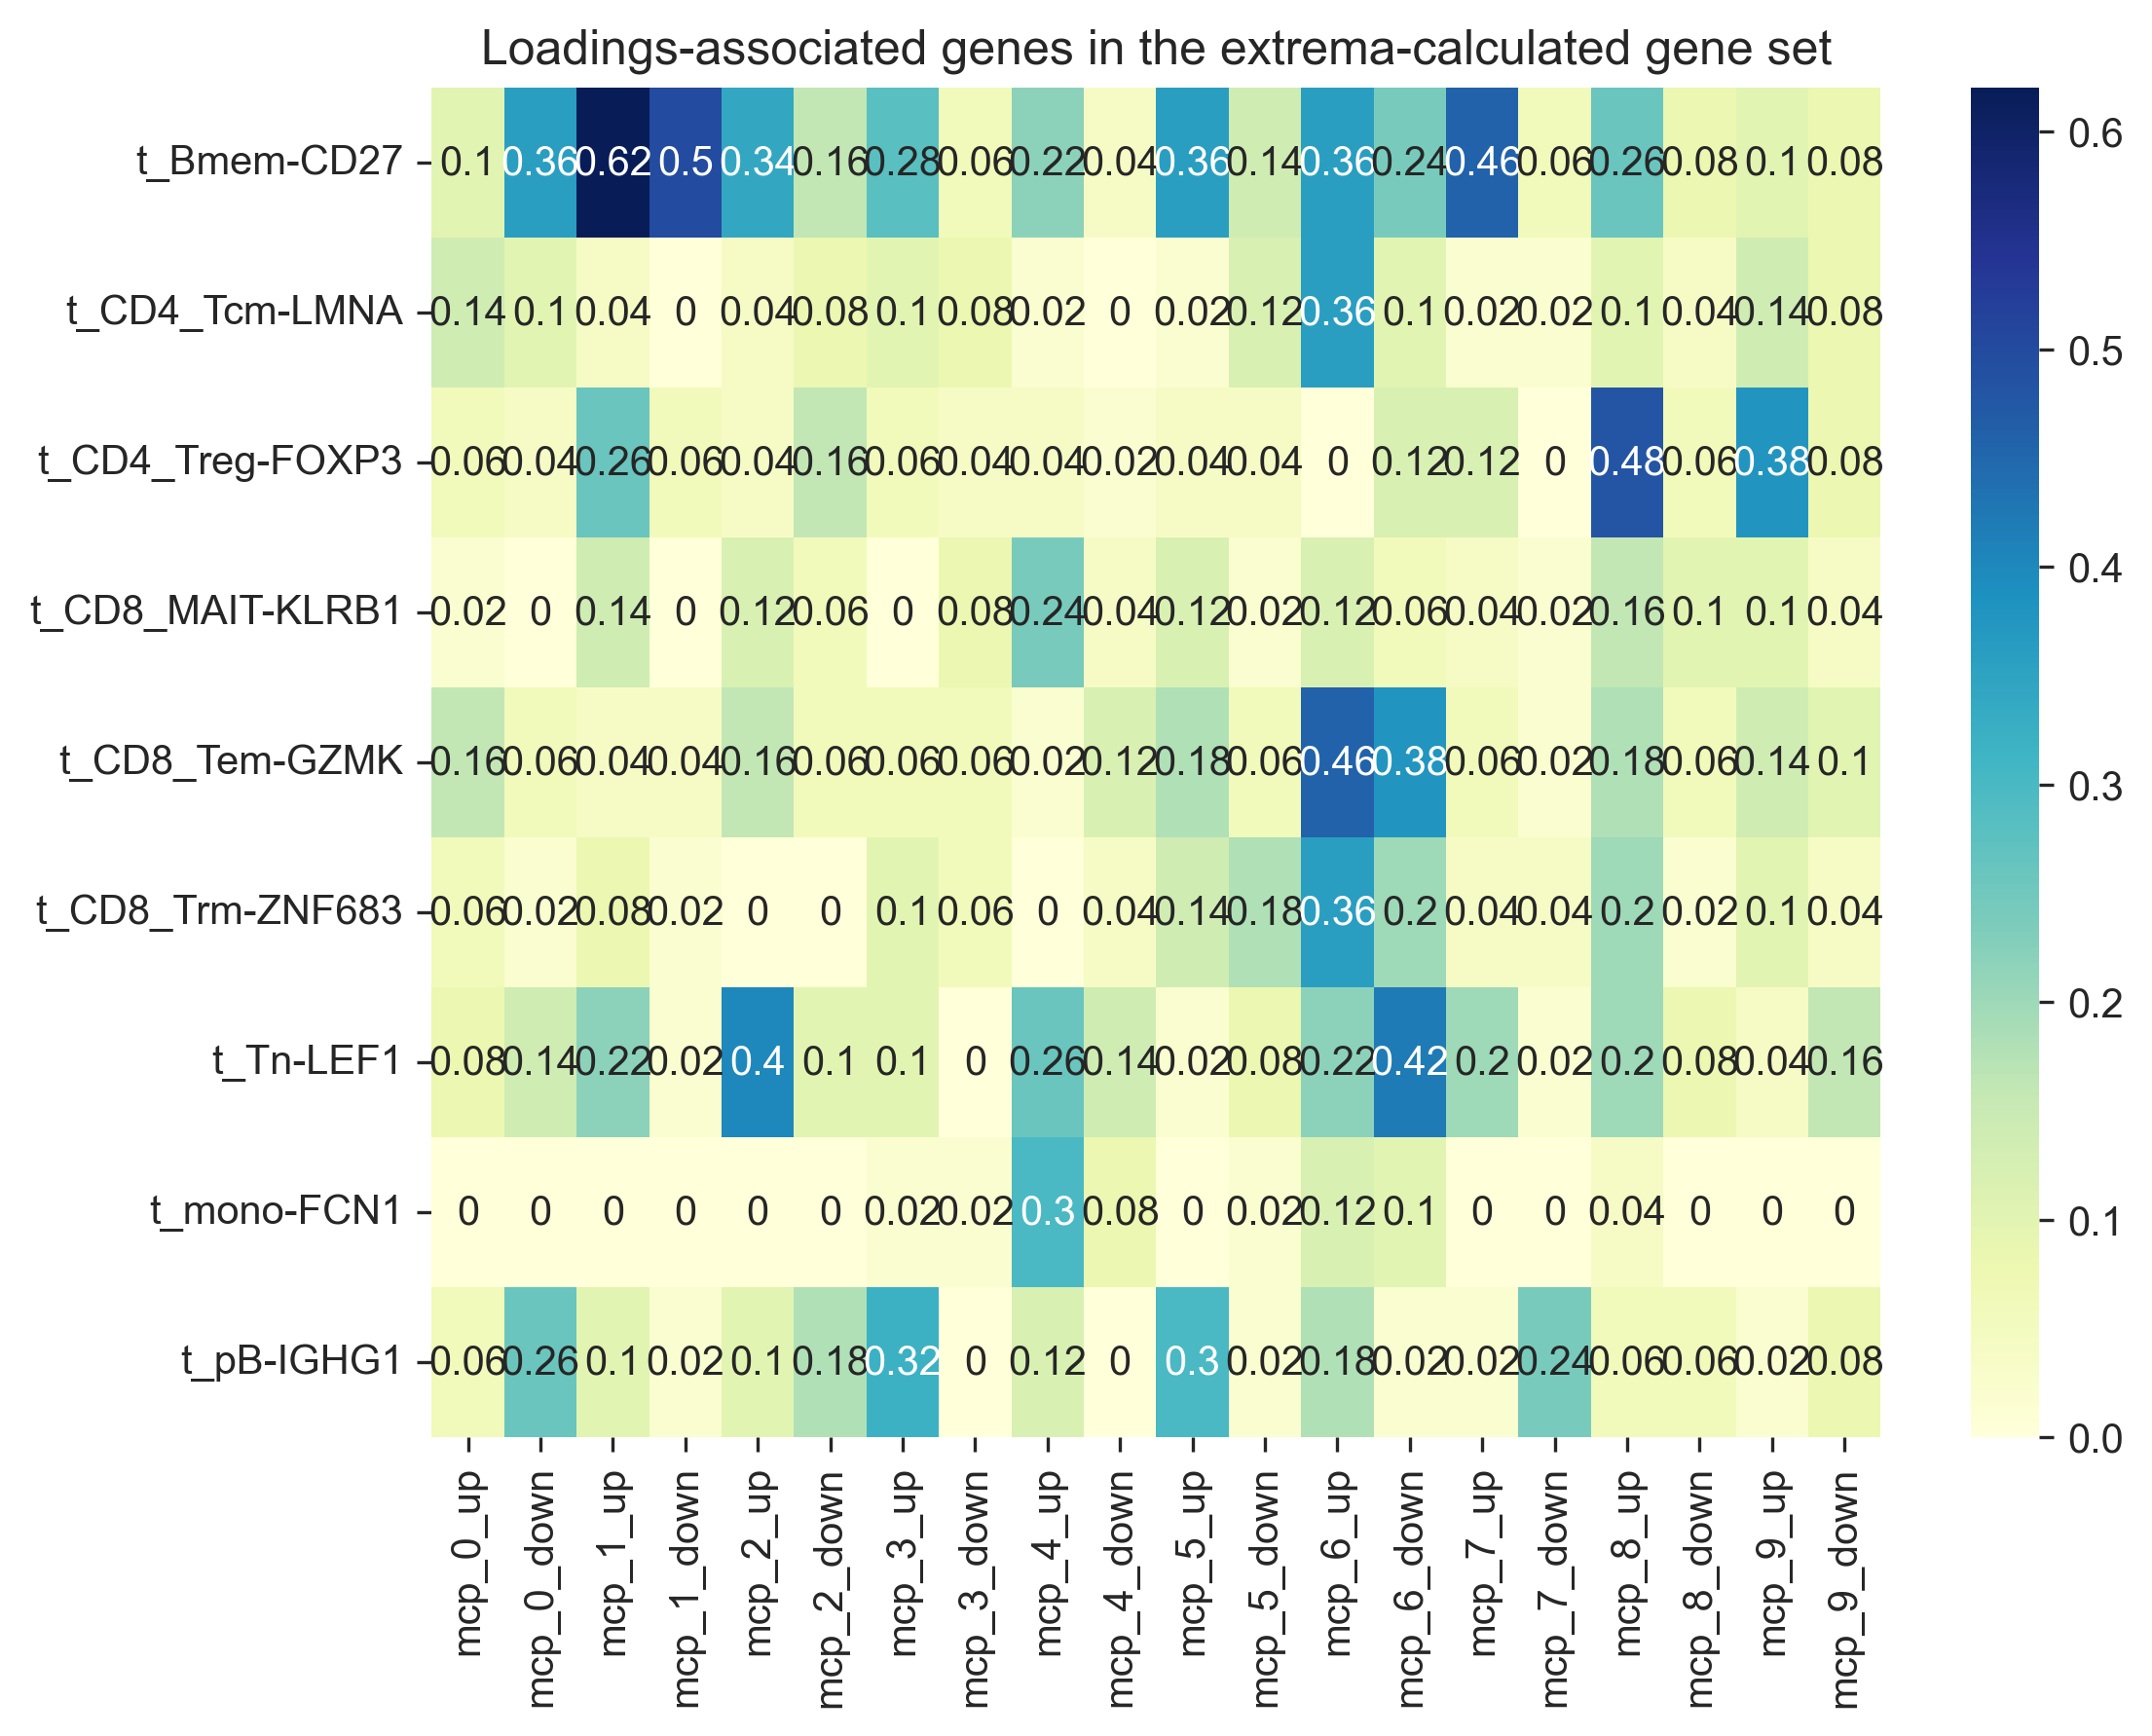

In [85]:
plt.figure(figsize=(8, 6)) 
sns.heatmap(lvh, annot=True, cmap='YlGnBu', fmt='g')  # 'annot' adds values, 'cmap' sets color map, 'fmt' sets number format

plt.title('Loadings-associated genes in the extrema-calculated gene set')
plt.show()

In [86]:
# loadings vs dlg
lvh = dlg_v_hilo

lvh = lvh*0

for n in range(0,10):
    for celltype in genes_loadings:
        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] > 0 ]
        x= set(genes_loadings[celltype]["mcp_"+str(n)+"_"+"up"]) & set(siggenes['names'])
        lvh.loc[celltype,"mcp_"+str(n)+"_up" ] =  len(x)/50

        siggenes = rank_dfs["mcp_"+str(n)][celltype][rank_dfs["mcp_"+str(n)][celltype]['pvals_adj'] < 0.01]
        siggenes = siggenes[siggenes['logfoldchanges'] < 0 ]
        x= set(genes_loadings[celltype]["mcp_"+str(n)+"_"+"down"]) & set(siggenes['names'])
        if len(x) > 50:
            print(celltype)
            print(n)
            print(x)
            print(len(x))
            break
        lvh.loc[celltype,"mcp_"+str(n)+"_down" ] =  len(x)/50

In [87]:
genes = []
for celltype in genes_dlg:
    for key in genes_dlg[celltype]:
        genes += genes_dlg[celltype][key]
genes = list(set(genes))

In [88]:
inc = []
for gene in genes:
    if gene in list(ct_subs['ct_subs_loadings']['t_Bmem-CD27'].var_names):
        inc.append(gene)

In [89]:
len(inc)

827

In [90]:
len(genes)

1741

In [91]:
mcp4_ranked_genes = rank_dfs['mcp_4']

In [110]:
## For this dictionary of data frames mcp4_ranked_genes, combine them into a single data frame with an added column with the key 
## (the name of the data frame) and then save it as a csv file.
i=0
for key in mcp4_ranked_genes:
    print(i)
    if i==0:
        df = mcp4_ranked_genes[key]
        df['celltype']  = key
        mcp4_ranked_genes_all = df
        i+=1
    else:
        df = mcp4_ranked_genes[key]
        df['celltype']  = key
        mcp4_ranked_genes_all  = pd.concat([mcp4_ranked_genes_all,df], axis=0, ignore_index=True)
        i+=1 

0
1
2
3
4
5
6
7
8


In [114]:
mcp4_ranked_genes_sig = mcp4_ranked_genes_all[mcp4_ranked_genes_all['pvals_adj']<0.01]

In [131]:
mcp4_ranked_genes_sig

cts = list(a['pvals_adj'][a['pvals_adj']['mcp_4'] == a['pvals_adj']['mcp_4'].min()].index)



In [134]:
mcp4_ranked_genes_sig = mcp4_ranked_genes_sig[mcp4_ranked_genes_sig['celltype'].isin(cts)]


In [93]:
outfile =  "output/tumor_pre_DLG_normalizeTrue_bssolver_071023_mcp4_ranked_genes.pkl"
with open(outfile, 'wb') as pickle_file:
    pkl.dump(mcp4_ranked_genes, pickle_file)
pickle_file.close()

In [720]:
mini.write_h5ad("output/tumor_pre_DLG_normalizeTrue_bssolver_071023_mini_adata.h5ad")

In [135]:
mcp4_ranked_genes_sig = mcp4_ranked_genes_sig[mcp4_ranked_genes_sig['celltype'].isin(cts)]


In [137]:
mcp4_ranked_genes_sig.to_csv("output/MCP_genes_from_extrema_MCP4.csv")


In [139]:
mcp4_ranked_genes_sig['names'].isin()

0            HSPA1B
1          PPP1R15A
2            HSPA1A
3            DNAJB1
4              IER5
            ...    
199552     IGKV3-11
199553    IGKV3D-11
199554    IGKV1D-39
199555     IGKV1-39
199556         IGKC
Name: names, Length: 6459, dtype: object

In [149]:
mcp4_ranked_genes_sig

names     scores  logfoldchanges          pvals      pvals_adj  \
0          HSPA1B  30.494066        3.594083  3.727027e-158  8.263938e-154   
1        PPP1R15A  26.727461        2.965653  5.198376e-128  5.763180e-124   
2          HSPA1A  25.321482        3.176194  1.615385e-117  1.193931e-113   
3          DNAJB1  25.240948        2.941535  8.374333e-117  4.642102e-113   
4            IER5  19.950979        2.756705   8.577211e-77   3.803650e-73   
...           ...        ...             ...            ...            ...   
199552   IGKV3-11 -17.466932       -5.178281   2.529798e-55   9.348869e-52   
199553  IGKV3D-11 -17.792826      -30.611252   4.315288e-55   1.366898e-51   
199554  IGKV1D-39 -19.592562       -7.581169   3.994331e-64   1.771326e-60   
199555   IGKV1-39 -21.088917       -8.075187   1.322172e-71   7.329132e-68   
199556       IGKC -39.614269       -6.276192  1.511486e-201  3.351418e-197   

           celltype  
0       t_Bmem-CD27  
1       t_Bmem-CD27  
2       t_Bmem-CD27  
3       t_Bmem-CD27  
4       t_Bmem-CD27  
...             ...  
199552   t_pB-IGHG1  
199553   t_pB-IGHG1  
199554   t_pB-IGHG1  
199555   t_pB-IGHG1  
199556   t_pB-IGHG1  

[6459 rows x 6 columns]

In [150]:
lvh

mcp_0_up  mcp_0_down  mcp_1_up  mcp_1_down  mcp_2_up  \
t_Bmem-CD27           0.10        0.36      0.62        0.50      0.34   
t_CD4_Tcm-LMNA        0.14        0.10      0.04        0.00      0.04   
t_CD4_Treg-FOXP3      0.06        0.04      0.26        0.06      0.04   
t_CD8_MAIT-KLRB1      0.02        0.00      0.14        0.00      0.12   
t_CD8_Tem-GZMK        0.16        0.06      0.04        0.04      0.16   
t_CD8_Trm-ZNF683      0.06        0.02      0.08        0.02      0.00   
t_Tn-LEF1             0.08        0.14      0.22        0.02      0.40   
t_mono-FCN1           0.00        0.00      0.00        0.00      0.00   
t_pB-IGHG1            0.06        0.26      0.10        0.02      0.10   

                  mcp_2_down  mcp_3_up  mcp_3_down  mcp_4_up  mcp_4_down  \
t_Bmem-CD27             0.16      0.28        0.06      0.22        0.04   
t_CD4_Tcm-LMNA          0.08      0.10        0.08      0.02        0.00   
t_CD4_Treg-FOXP3        0.16      0.06        0.04      0.04        0.02   
t_CD8_MAIT-KLRB1        0.06      0.00        0.08      0.24        0.04   
t_CD8_Tem-GZMK          0.06      0.06        0.06      0.02        0.12   
t_CD8_Trm-ZNF683        0.00      0.10        0.06      0.00        0.04   
t_Tn-LEF1               0.10      0.10        0.00      0.26        0.14   
t_mono-FCN1             0.00      0.02        0.02      0.30        0.08   
t_pB-IGHG1              0.18      0.32        0.00      0.12        0.00   

                  mcp_5_up  mcp_5_down  mcp_6_up  mcp_6_down  mcp_7_up  \
t_Bmem-CD27           0.36        0.14      0.36        0.24      0.46   
t_CD4_Tcm-LMNA        0.02        0.12      0.36        0.10      0.02   
t_CD4_Treg-FOXP3      0.04        0.04      0.00        0.12      0.12   
t_CD8_MAIT-KLRB1      0.12        0.02      0.12        0.06      0.04   
t_CD8_Tem-GZMK        0.18        0.06      0.46        0.38      0.06   
t_CD8_Trm-ZNF683      0.14        0.18      0.36        0.20      0.04   
t_Tn-LEF1             0.02        0.08      0.22        0.42      0.20   
t_mono-FCN1           0.00        0.02      0.12        0.10      0.00   
t_pB-IGHG1            0.30        0.02      0.18        0.02      0.02   

                  mcp_7_down  mcp_8_up  mcp_8_down  mcp_9_up  mcp_9_down  
t_Bmem-CD27             0.06      0.26        0.08      0.10        0.08  
t_CD4_Tcm-LMNA          0.02      0.10        0.04      0.14        0.08  
t_CD4_Treg-FOXP3        0.00      0.48        0.06      0.38        0.08  
t_CD8_MAIT-KLRB1        0.02      0.16        0.10      0.10        0.04  
t_CD8_Tem-GZMK          0.02      0.18        0.06      0.14        0.10  
t_CD8_Trm-ZNF683        0.04      0.20        0.02      0.10        0.04  
t_Tn-LEF1               0.02      0.20        0.08      0.04        0.16  
t_mono-FCN1             0.00      0.04        0.00      0.00        0.00  
t_pB-IGHG1              0.24      0.06        0.06      0.02        0.08

In [164]:
dvh['mcp_7_up']['t_Bmem-CD27'] = 0.0
dvh

mcp_0_up  mcp_0_down  mcp_1_up  mcp_1_down  mcp_2_up  \
t_Bmem-CD27       0.368421    0.369748  0.968750    0.333333  0.416667   
t_CD4_Tcm-LMNA    0.407143    0.341463  0.939394    0.000000  0.841270   
t_CD4_Treg-FOXP3  1.000000    0.809524  0.925000    0.705882  0.556818   
t_CD8_MAIT-KLRB1  0.120000    0.012658  0.377358    0.512821  0.333333   
t_CD8_Tem-GZMK    0.454545    0.434783  0.923077    0.500000  0.509804   
t_CD8_Trm-ZNF683  0.858407    0.864198  0.887500    0.750000  0.907895   
t_Tn-LEF1         0.350427    0.282828  1.000000    0.000000  0.883721   
t_mono-FCN1       0.065934    0.202899  0.394737    0.351648  0.053333   
t_pB-IGHG1        0.191304    0.469880  0.812500    0.000000  0.718750   

                  mcp_2_down  mcp_3_up  mcp_3_down  mcp_4_up  mcp_4_down  \
t_Bmem-CD27         0.414634  0.989691    0.000000  0.894737    0.166667   
t_CD4_Tcm-LMNA      0.467742  0.881579    0.916667  0.877551    0.933333   
t_CD4_Treg-FOXP3    1.000000  0.814815    0.972973  0.939759    0.450000   
t_CD8_MAIT-KLRB1    0.923913  0.291139    0.538462  0.363636    0.184211   
t_CD8_Tem-GZMK      0.682927  0.807229    0.500000  0.795918    0.675000   
t_CD8_Trm-ZNF683    0.952381  0.888889    0.846154  0.663043    0.344828   
t_Tn-LEF1           0.090909  0.739726    0.759259  0.989691    0.851351   
t_mono-FCN1         0.040000  0.329670    0.115942  0.314286    0.372881   
t_pB-IGHG1          0.272727  0.988764    0.076923  0.454545    0.666667   

                  mcp_5_up  mcp_5_down  mcp_6_up  mcp_6_down  mcp_7_up  \
t_Bmem-CD27       0.238095    0.416667  0.213115    0.642857       0.0   
t_CD4_Tcm-LMNA    0.339286    0.333333  0.333333    0.953488  0.813953   
t_CD4_Treg-FOXP3  0.244444    0.956522  0.588235    0.907895  0.851852   
t_CD8_MAIT-KLRB1  0.040000    0.263158  0.881720    0.045455     0.625   
t_CD8_Tem-GZMK    0.531646    0.500000  0.392857    0.875000  0.826087   
t_CD8_Trm-ZNF683  0.559524    0.711111  0.786667    0.945652  0.690909   
t_Tn-LEF1         0.250000    0.708333  0.937500    0.285714       0.0   
t_mono-FCN1       0.056604    0.000000  0.343284    0.142857       0.0   
t_pB-IGHG1        0.000000    1.000000  0.611111    0.595238       0.8   

                  mcp_7_down  mcp_8_up  mcp_8_down  mcp_9_up  mcp_9_down  
t_Bmem-CD27         0.979592  0.162791    0.928571  0.750000    0.944444  
t_CD4_Tcm-LMNA      0.217949  0.707317    0.555556  0.114754    0.894737  
t_CD4_Treg-FOXP3    0.055556  0.712121    0.000000  0.066667    0.666667  
t_CD8_MAIT-KLRB1    0.352941  0.085714    0.791667  0.000000    1.000000  
t_CD8_Tem-GZMK      0.461538  0.591549    0.833333  0.492754    0.857143  
t_CD8_Trm-ZNF683    0.111111  0.742268    0.266667  0.190476    0.800000  
t_Tn-LEF1           0.943182  0.500000    0.935897  0.979167    0.952381  
t_mono-FCN1         0.000000  0.142857    0.218182  0.027778    0.313725  
t_pB-IGHG1          1.000000  0.777778    0.235294  0.785714    0.448276

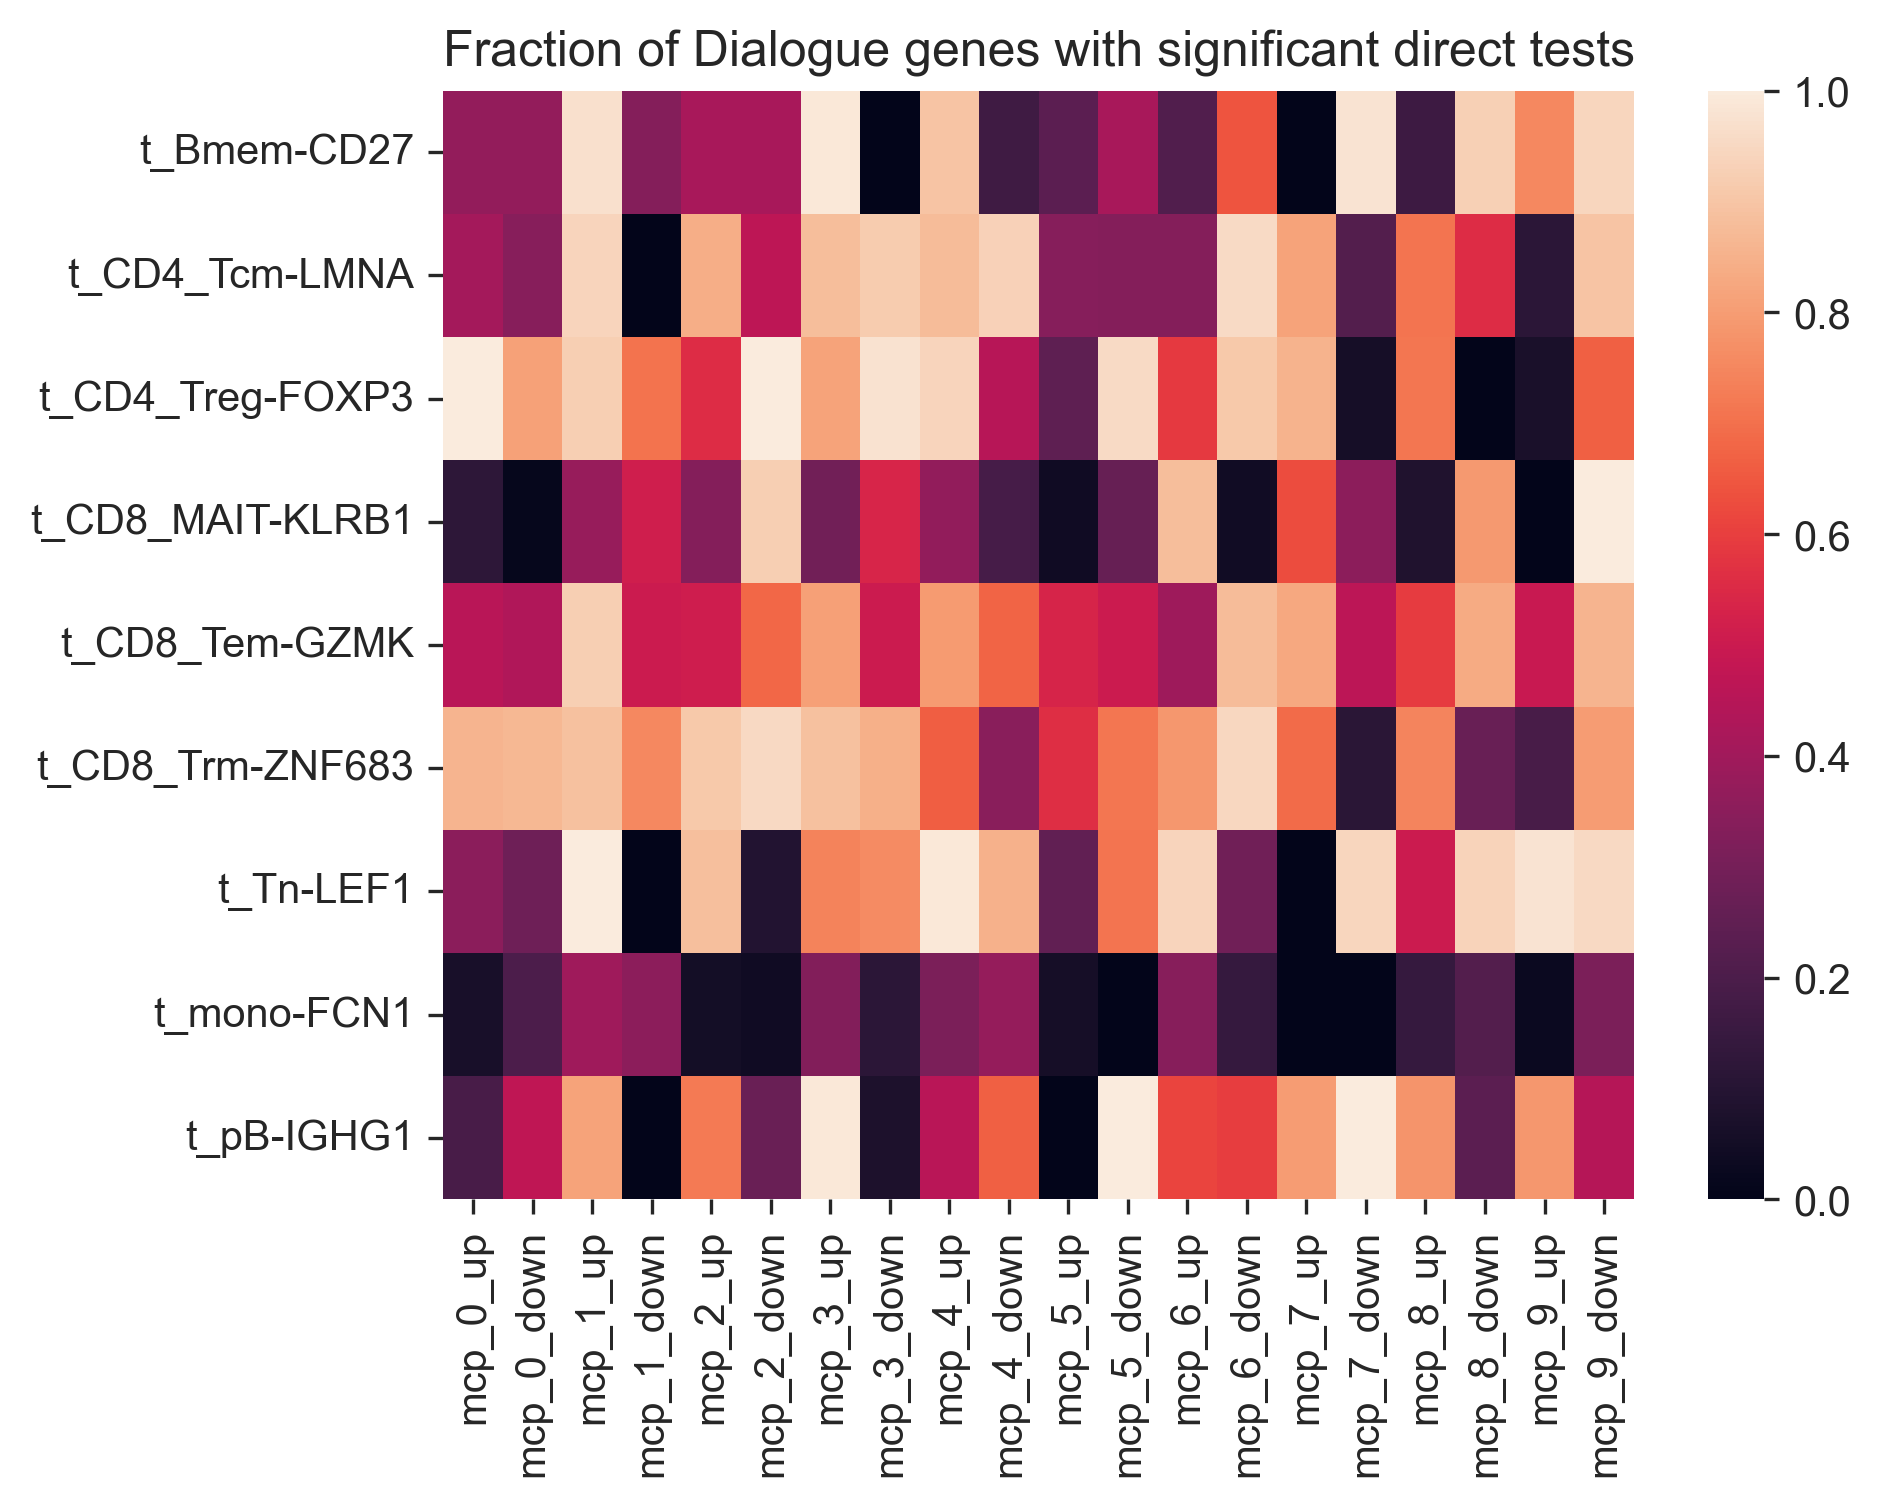

In [183]:
## Plot a headmap of the dataframe dvh
dvh = dvh.apply(pd.to_numeric, errors='coerce')

sns.heatmap(dvh, annot=False)
plt.title("Fraction of Dialogue genes with significant direct tests")
plt.savefig("output/fraction-DLG-genes-with-sig-extrema-pvals.pdf", bbox_inches='tight')
plt.savefig("output/fraction-DLG-genes-with-sig-extrema-pvals.png", bbox_inches='tight')

In [185]:
dvh.mean().mean()

0.5348977182907771

In [220]:
### THIS DOESN'T WORK YET, maybe fix it later?

def ctdict_to_df(ctdict):
    i=0
    for mcp in ctdict:
        if i==0:
            #df = ctdict[mcp]
            return(mcp)
            df['mcp']  = mcp
            return_df = df
            i+=1
        else:
            df = ctdict[key]
            df['celltype']  = key
            return_df  = pd.concat([return_df,df], axis=0, ignore_index=True)
            i+=1 
    return return_df

def genes_obs_to_df(genes_obj):
    i=0
    for celltype in genes_obj:
        print(i)
        if i==0:
            df = ctdict_to_df(genes_obj[celltype])
            df['celltype']  = celltype
            return_df = df
            i+=1
        else:
            df = ctdict_to_df(genes_obj[celltype])
            df['celltype']  = celltype
            return_df  = pd.concat([return_df,df], axis=0, ignore_index=True)
            i+=1 
    return return_df

In [221]:
ctdict_to_df(genes_dlg['t_Bmem-CD27'])

'mcp_0_up'

In [222]:
genes_dlg['t_Bmem-CD27']['mcp_0_up']

['ACTG2',
 'AHNAK',
 'ANXA1',
 'ARID4B',
 'ATP5ME',
 'BGN',
 'BHLHE40',
 'BICDL2',
 'BIRC3',
 'CALML5',
 'CAVIN1',
 'CCR7',
 'CD163L1',
 'CD1C',
 'CD24',
 'CD82',
 'CDKN1A',
 'CLDN4',
 'CLU',
 'COL11A1',
 'CRABP2',
 'CRYAB',
 'CSRNP1',
 'CTTN',
 'DCN',
 'EEF1B2',
 'EIF4B',
 'ELL2',
 'FDCSP',
 'FN1',
 'FXYD3',
 'GNG11',
 'HLA-A',
 'HLA-B',
 'HNRNPU',
 'HSPA5',
 'IGFBP5',
 'IGHA1',
 'IGHV5-78',
 'ITGB1',
 'ITSN2',
 'KLK5',
 'KRT14',
 'KRT15',
 'KRT16',
 'KRT19',
 'KRT8',
 'KRT81',
 'LGALS1',
 'LINC00882',
 'LMNA',
 'MDK',
 'MGP',
 'MIA',
 'MIF',
 'MMP7',
 'MYL9',
 'MYLK',
 'NCL',
 'NEU1',
 'NR4A3',
 'NUPR1',
 'PARP15',
 'PERP',
 'PFN2',
 'PHACTR1',
 'PMP22',
 'PTPRC',
 'PYGL',
 'RAB25',
 'RAB8B',
 'RALGAPA1',
 'ROPN1',
 'RPL36A',
 'RPL37A',
 'RPLP0',
 'RPS2',
 'S100A1',
 'SAA1',
 'SH3BP4',
 'SLC24A3',
 'SLC2A3',
 'SLPI',
 'SMC1B',
 'SMCHD1',
 'SNRPD2',
 'SPARC',
 'TACSTD2',
 'TM4SF1',
 'TMEM158',
 'TPM1',
 'TPM2',
 'TTC39A',
 'VPREB3',
 'WNK2',
 'A2M',
 'AARD',
 'AC015712.2',
 'AC015712.

In [234]:
# ok so much for that
# instead let's try something else
# instead let's plot rank_genes_groups top hits for the five cell types
from anndata import AnnData
from typing import Union, Sequence, Optional

from matplotlib import rcParams
def rank_genes_groups_vertical(
    adata: AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: int = 20,
    gene_symbols: Optional[str] = None,
    key: Optional[str] = 'rank_genes_groups',
    fontsize: int = 8,
    ncols: int = 4,
    sharey: bool = False,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    #ax: Optional[Axes] = None,
    title_override: Optional[str] = None,
    **kwds,
):
    """\
    Plot ranking of genes.
    Parameters
    ----------
    adata
        Annotated data matrix.
    groups
        The groups for which to show the gene ranking.
    gene_symbols
        Key for field in `.var` that stores gene symbols if you do not want to
        use `.var_names`.
    n_genes
        Number of genes to show.
    fontsize
        Fontsize for gene names.
    ncols
        Number of panels shown per row.
    sharey
        Controls if the y-axis of each panels should be shared. But passing
        `sharey=False`, each panel has its own y-axis range.
    {show_save_ax}
    Examples
    --------
    .. plot::
        :context: close-figs
        import scanpy as sc
        adata = sc.datasets.pbmc68k_reduced()
        sc.pl.rank_genes_groups(adata)
    Plot top 10 genes (default 20 genes)
    .. plot::
        :context: close-figs
        sc.pl.rank_genes_groups(adata, n_genes=10)
    .. currentmodule:: scanpy
    See also
    --------
    tl.rank_genes_groups
    """
    if 'n_panels_per_row' in kwds:
        n_panels_per_row = kwds['n_panels_per_row']
    else:
        n_panels_per_row = ncols
    if n_genes < 1:
        raise NotImplementedError(
            "Specifying a negative number for n_genes has not been implemented for "
            f"this plot. Received n_genes={n_genes}."
        )

    reference = str(adata.uns[key]['params']['reference'])
    group_names = adata.uns[key]['names'].dtype.names if groups is None else groups
    # one panel for each group
    # set up the figure
    n_panels_x = min(n_panels_per_row, len(group_names))
    n_panels_y = np.ceil(len(group_names) / n_panels_x).astype(int)

    from matplotlib import gridspec

    fig = plt.figure(
        figsize=(
            n_panels_x * 4,
            n_panels_y * 4.8,
        )
    )
    gs = gridspec.GridSpec(nrows=n_panels_y, ncols=n_panels_x, wspace=0.22, hspace=0.3)

    ax0 = None
    xmin = np.Inf
    xmax = -np.Inf
    for count, group_name in enumerate(group_names):
        gene_names = adata.uns[key]['names'][group_name][:n_genes]
        scores = adata.uns[key]['scores'][group_name][:n_genes]

        # Setting up axis, calculating y bounds
        if sharey:
            ymin = min(ymin, np.min(scores))
            ymax = max(ymax, np.max(scores))

            if ax0 is None:
                ax = fig.add_subplot(gs[count])
                ax0 = ax
            else:
                ax = fig.add_subplot(gs[count], sharey=ax0)
        else:
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3 * (ymax - ymin)

            ax = fig.add_subplot(gs[count])
            ax.set_xlim(ymin-2, ymax)

        ax.set_ylim( n_genes +0.5,0)

        # Mapping to gene_symbols
        if gene_symbols is not None:
            if adata.raw is not None and adata.uns[key]['params']['use_raw']:
                gene_names = adata.raw.var[gene_symbols][gene_names]
            else:
                gene_names = adata.var[gene_symbols][gene_names]

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            ax.text(
                scores[ig],
                ig+1,
                gene_name,
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=fontsize,
            )
        if title_override is not None:
            ax.set_title(title_override)
        else:
            ax.set_title('{}'.format(group_name, reference))
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('score')

        # print the 'score' label only on the first panel per row.
        if count % n_panels_x == 0:
            ax.set_ylabel('ranking')

    if sharey is True:
        ymax += 0.3 * (ymax - ymin)
        ax.set_ylim(ymin, ymax)

    #writekey = f"rank_genes_groups_{adata.uns[key]['params']['groupby']}"
    #savefig_or_show(writekey, show=show, save=save)

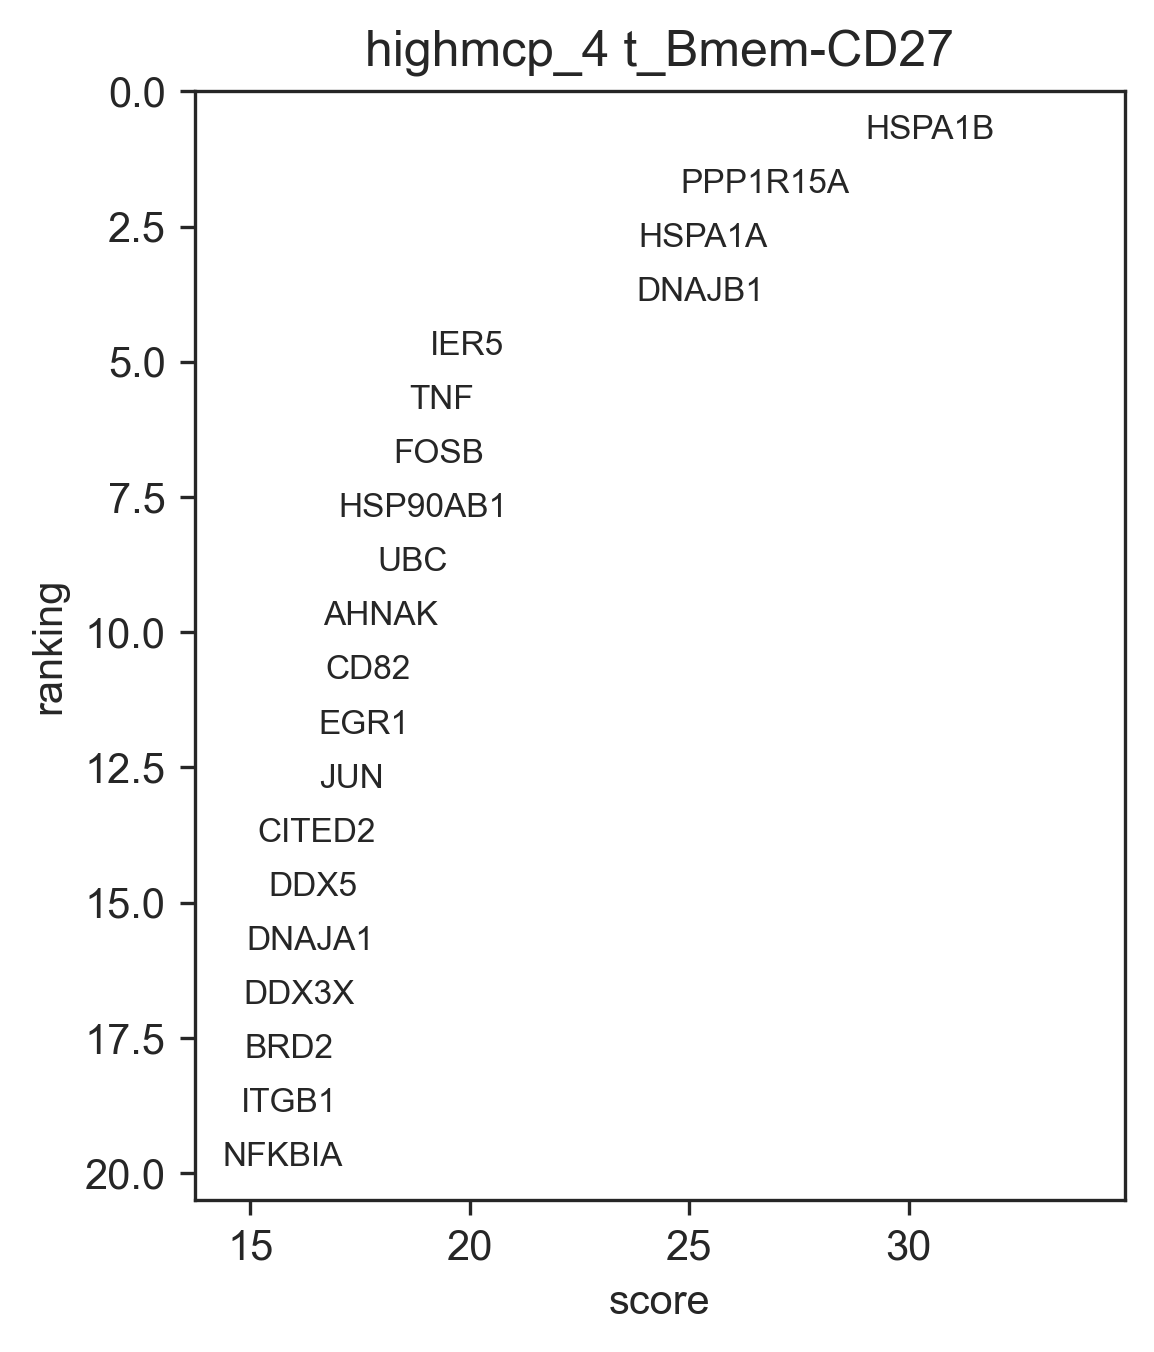

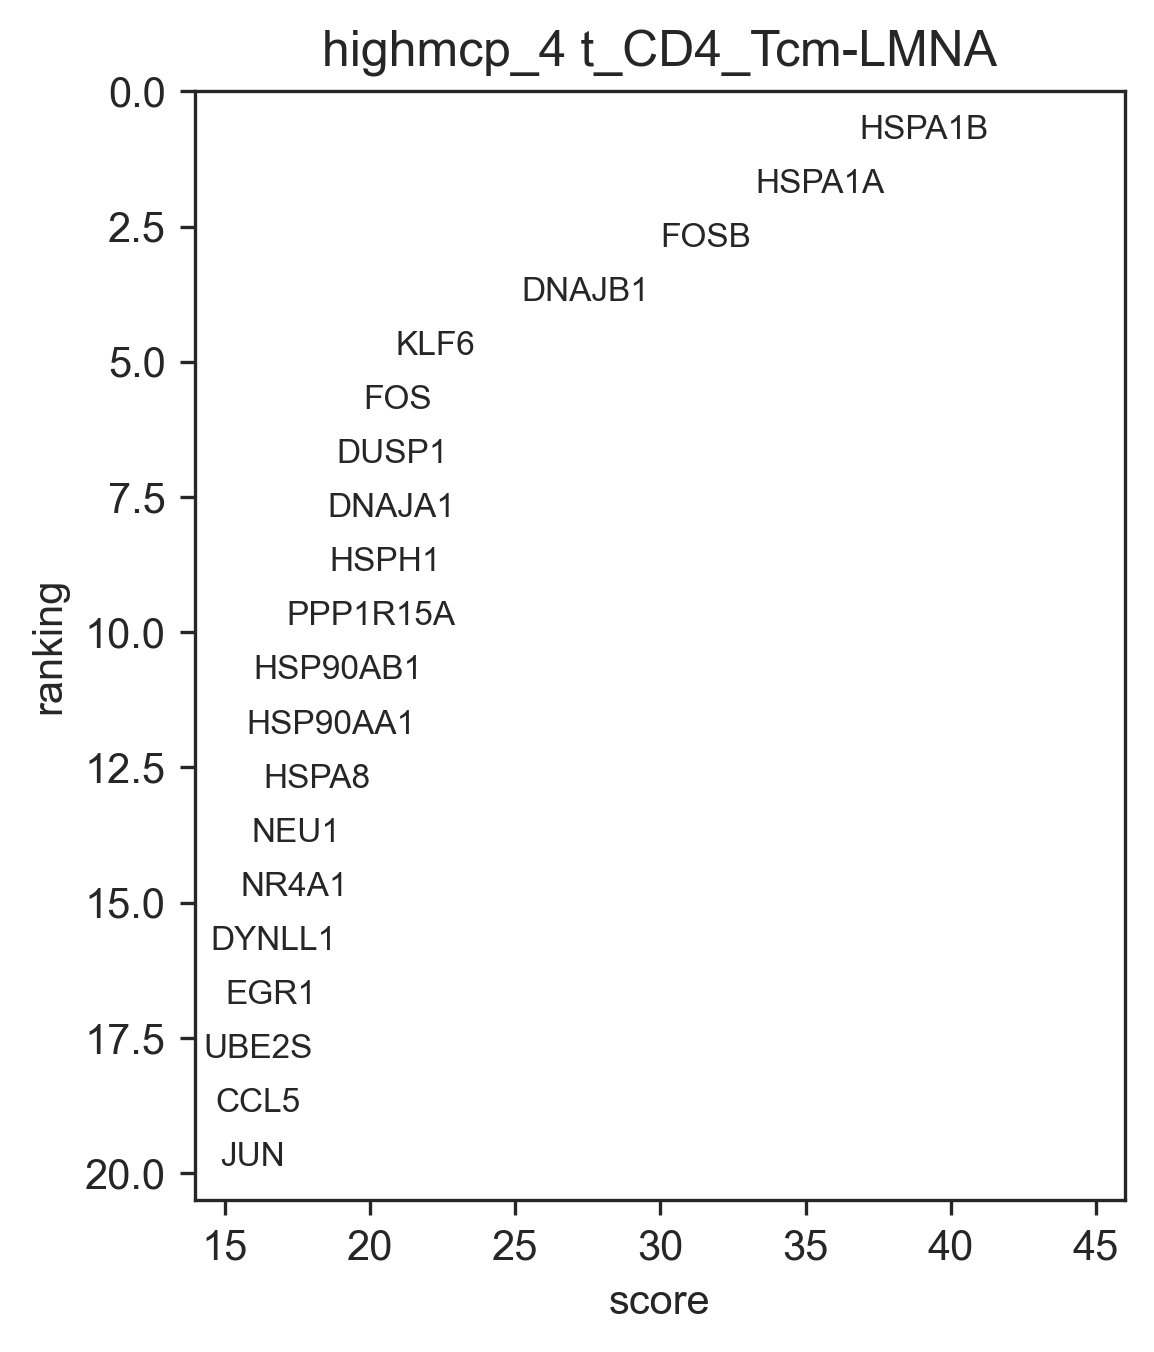

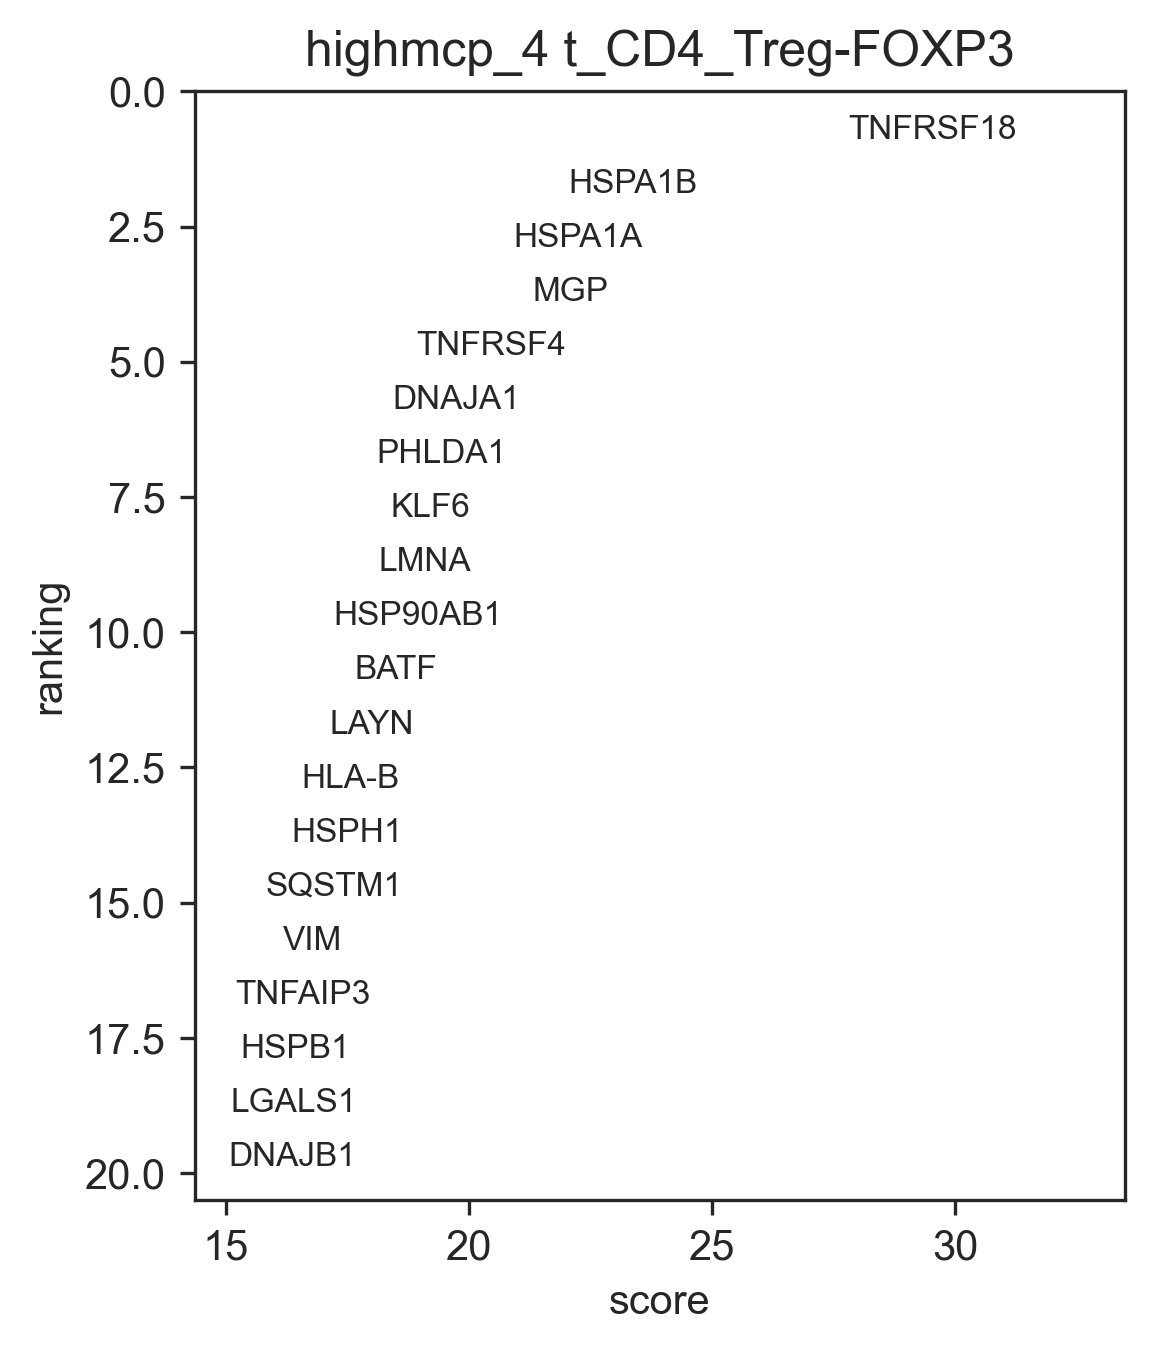

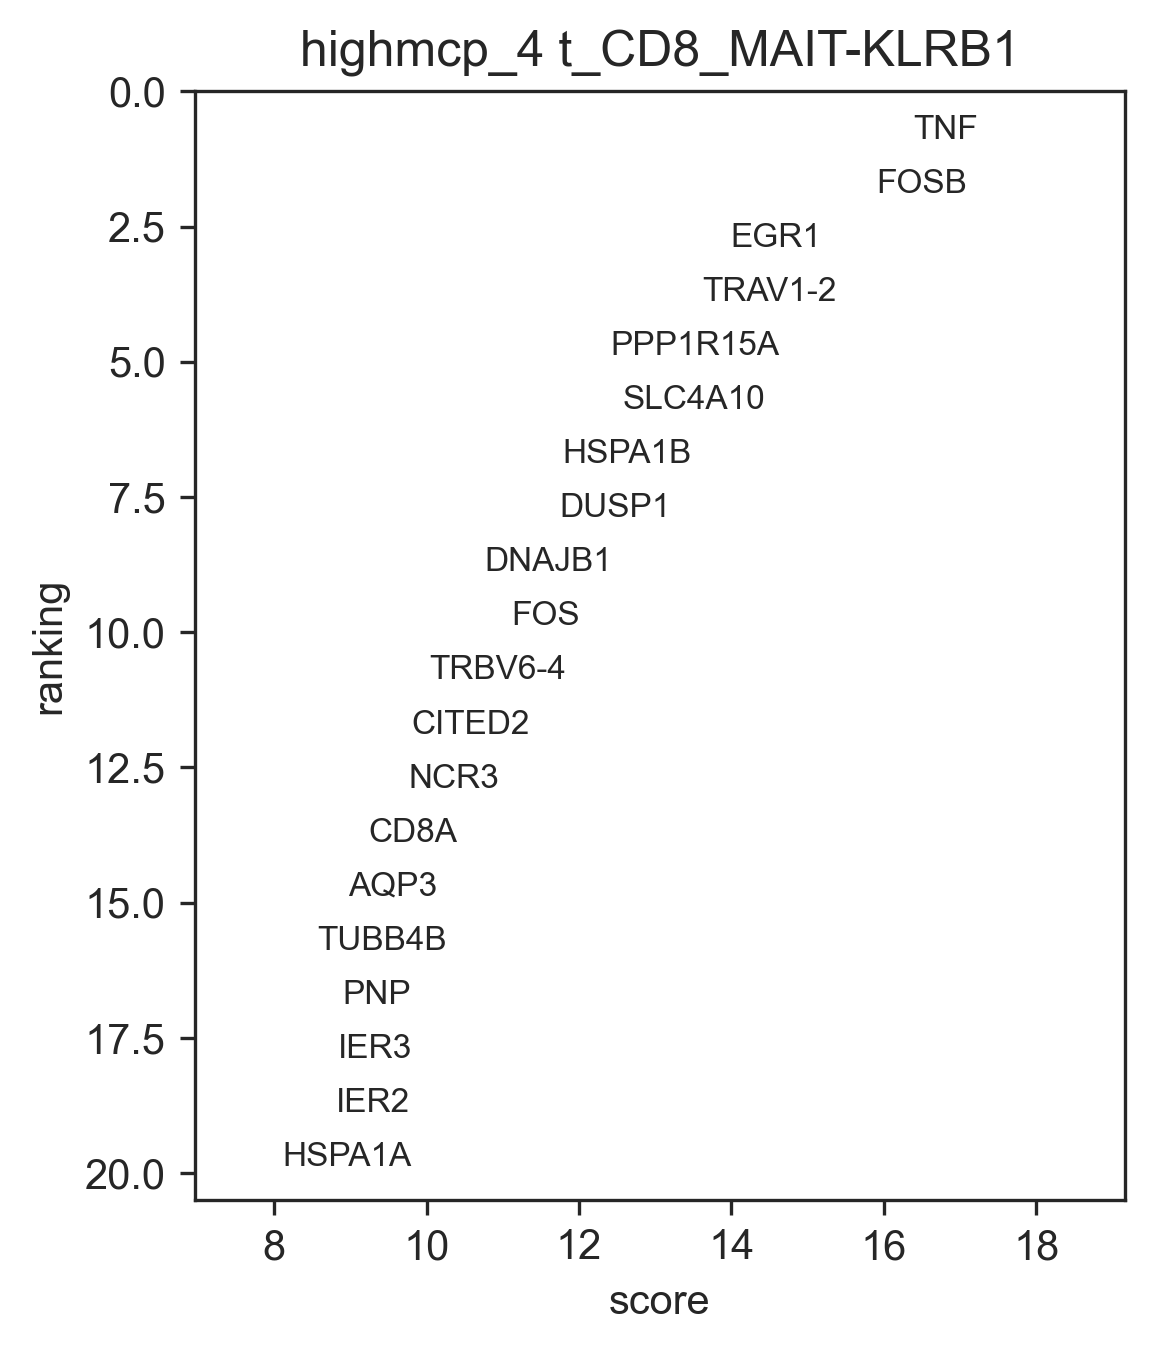

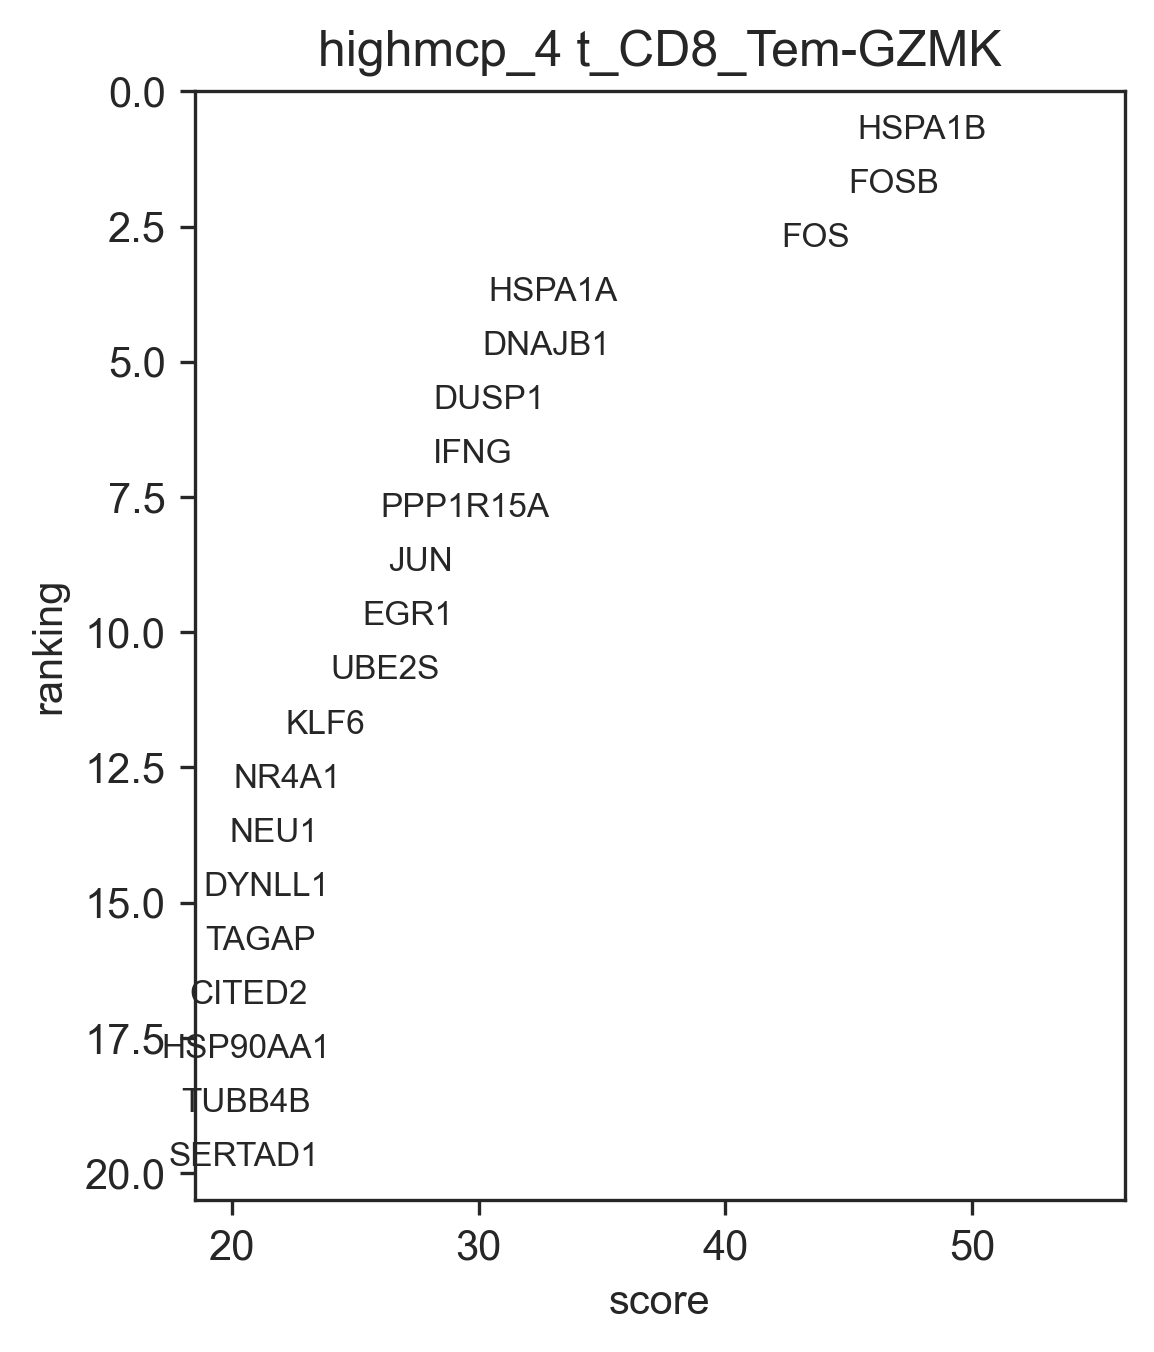

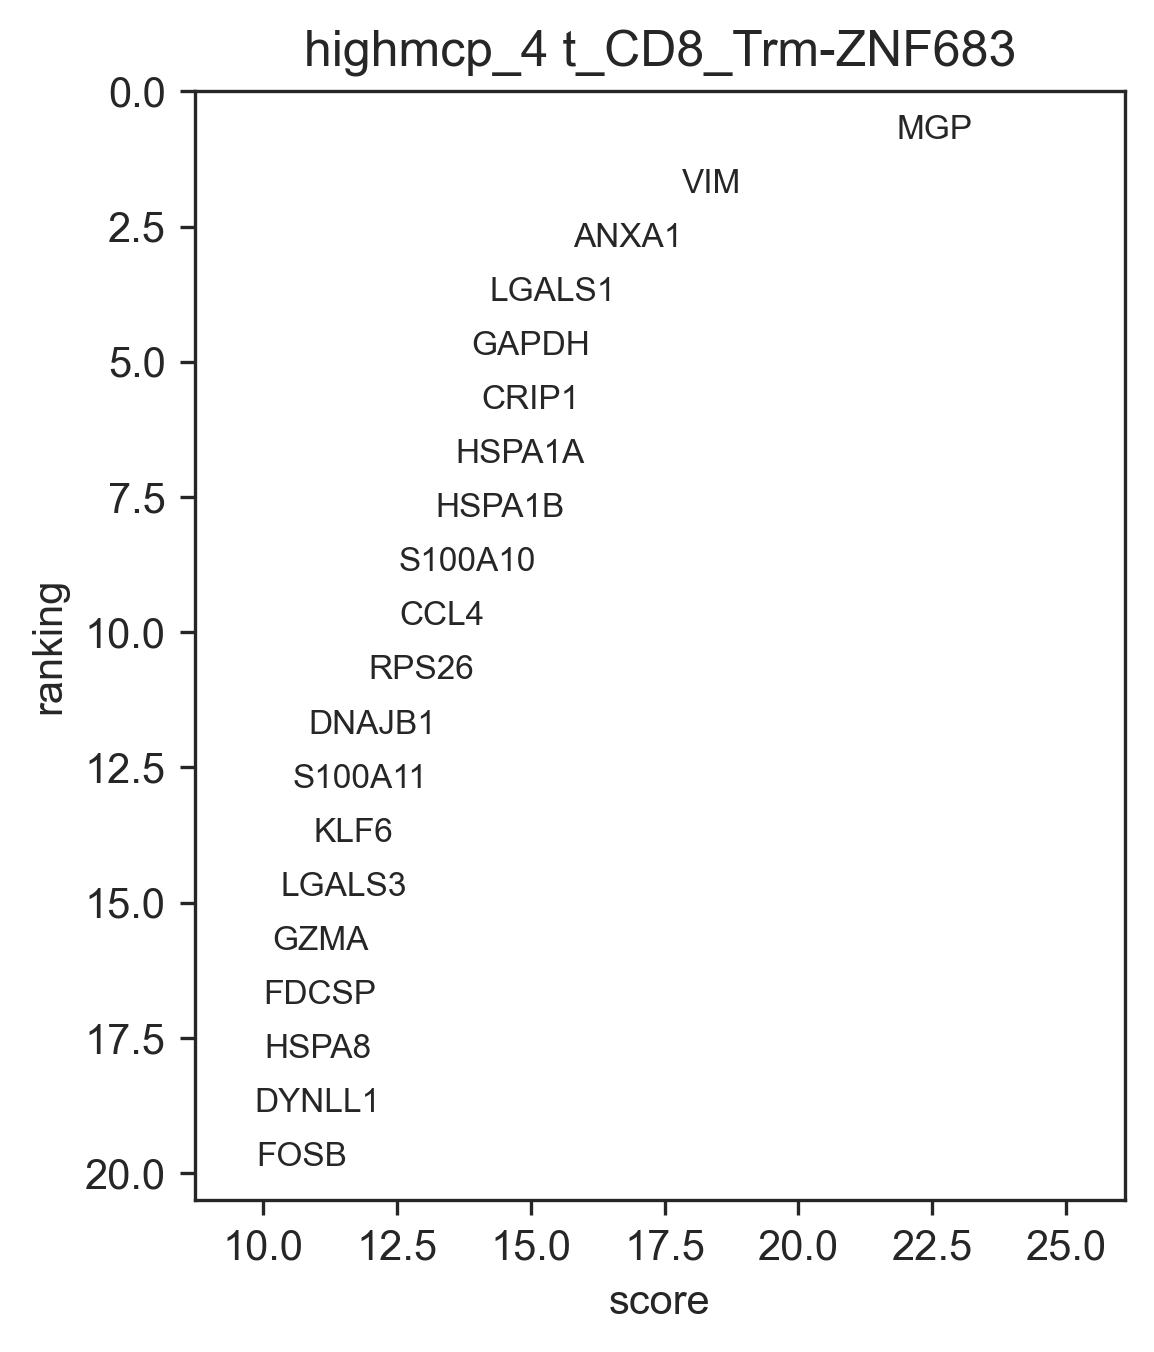

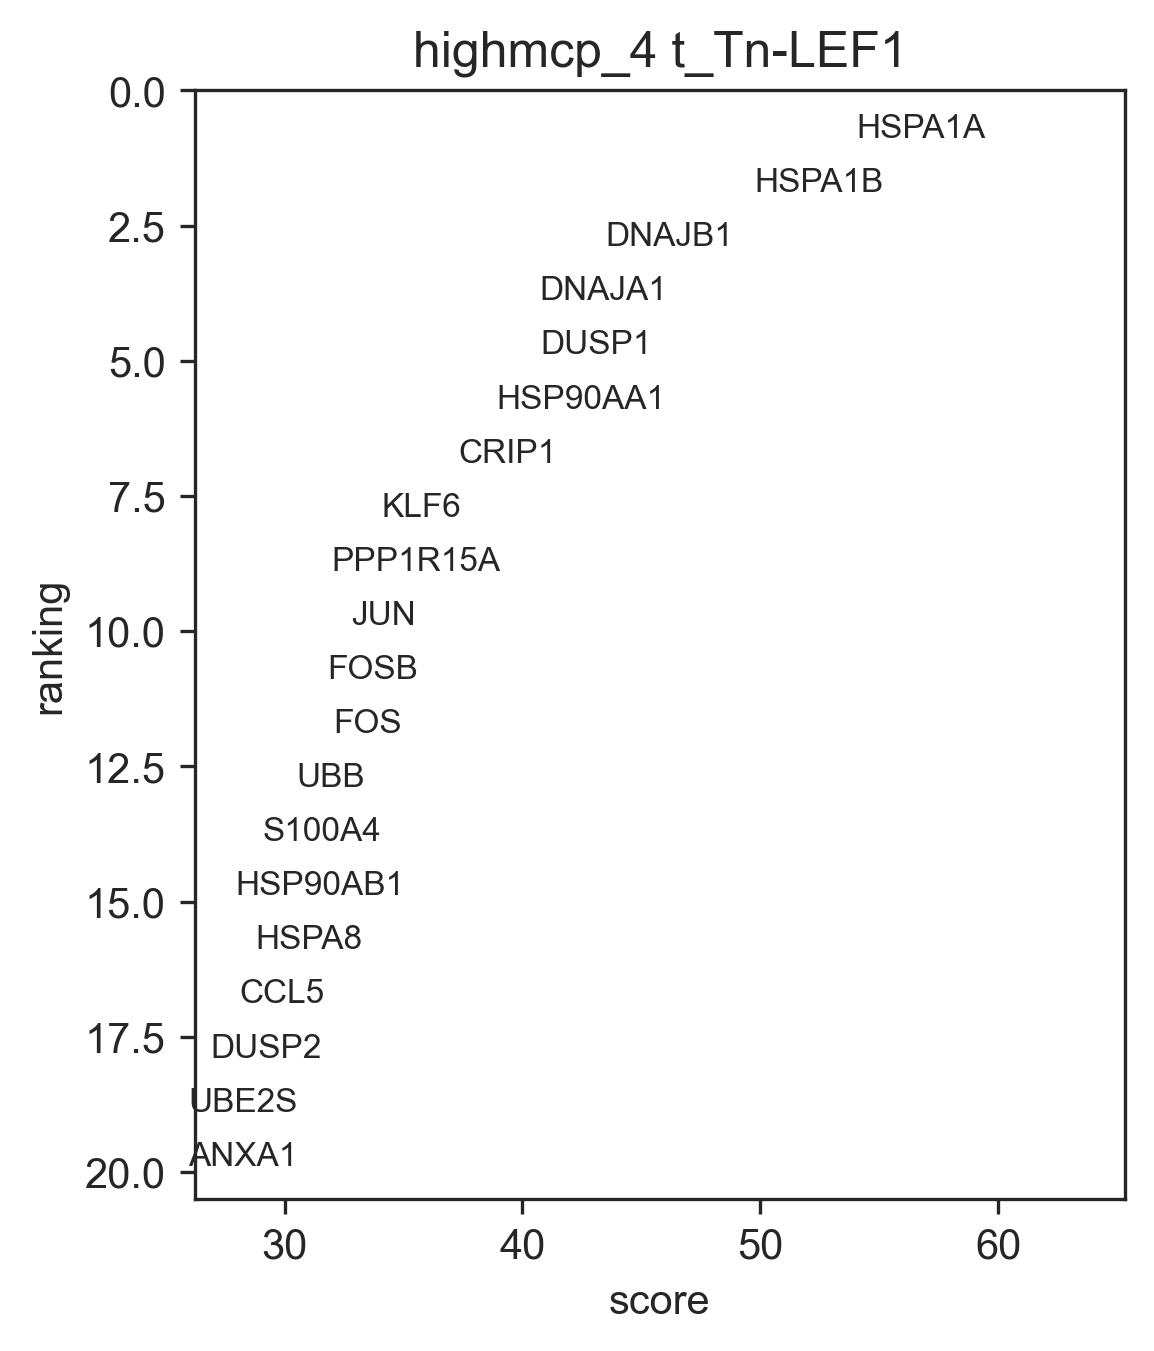

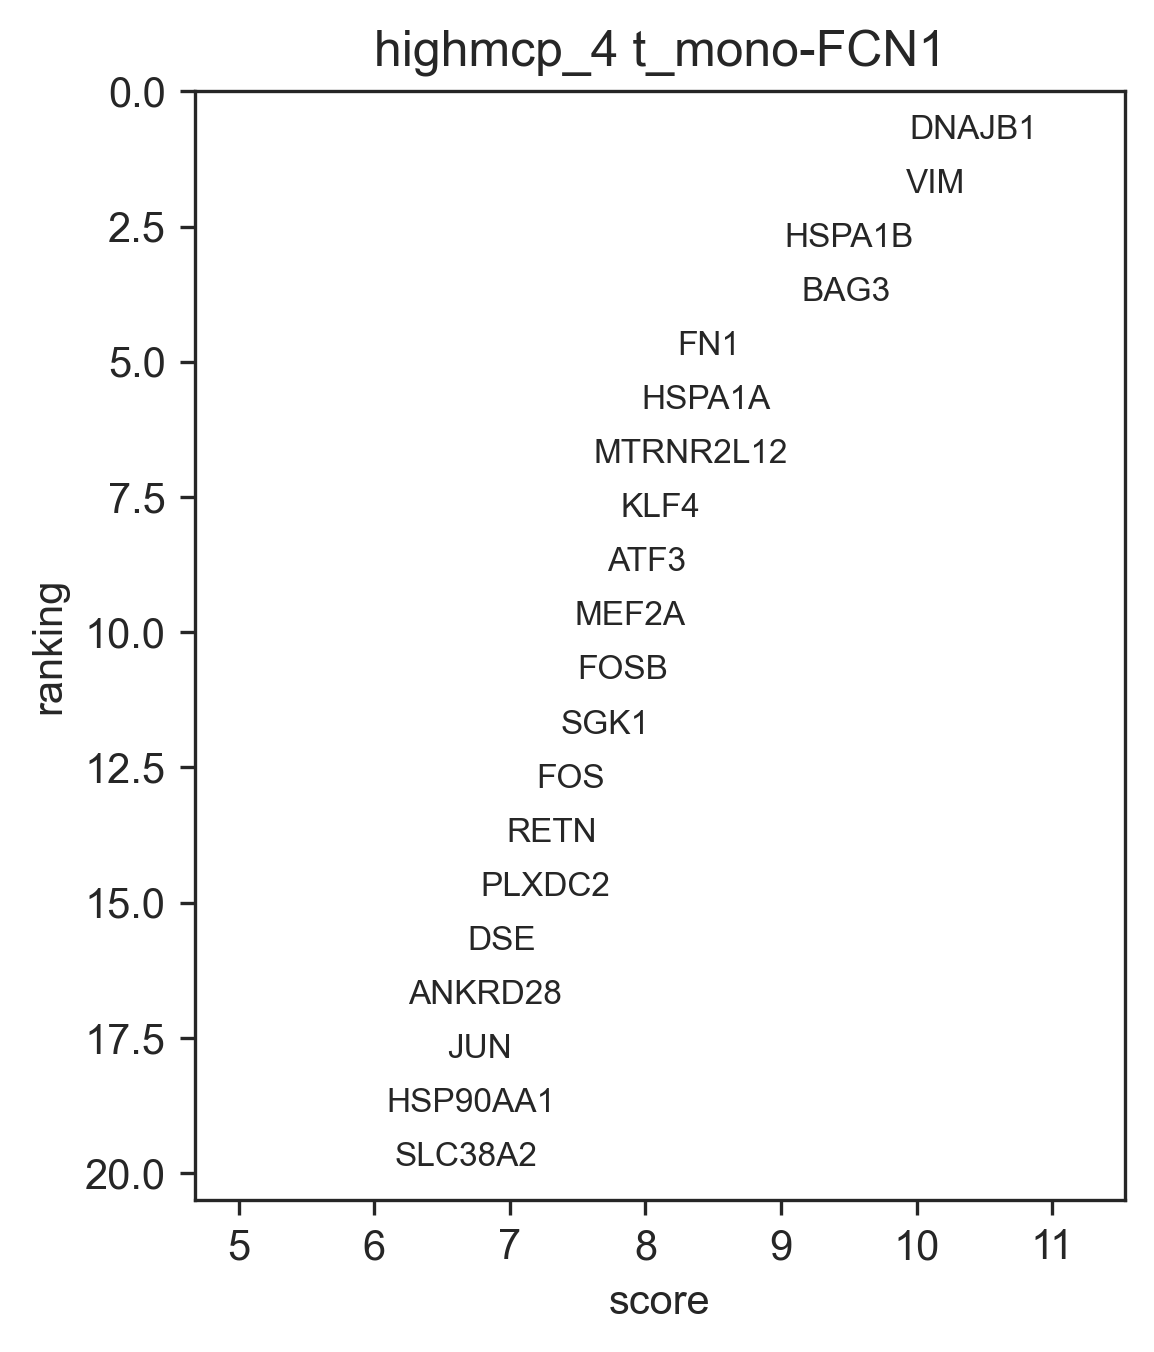

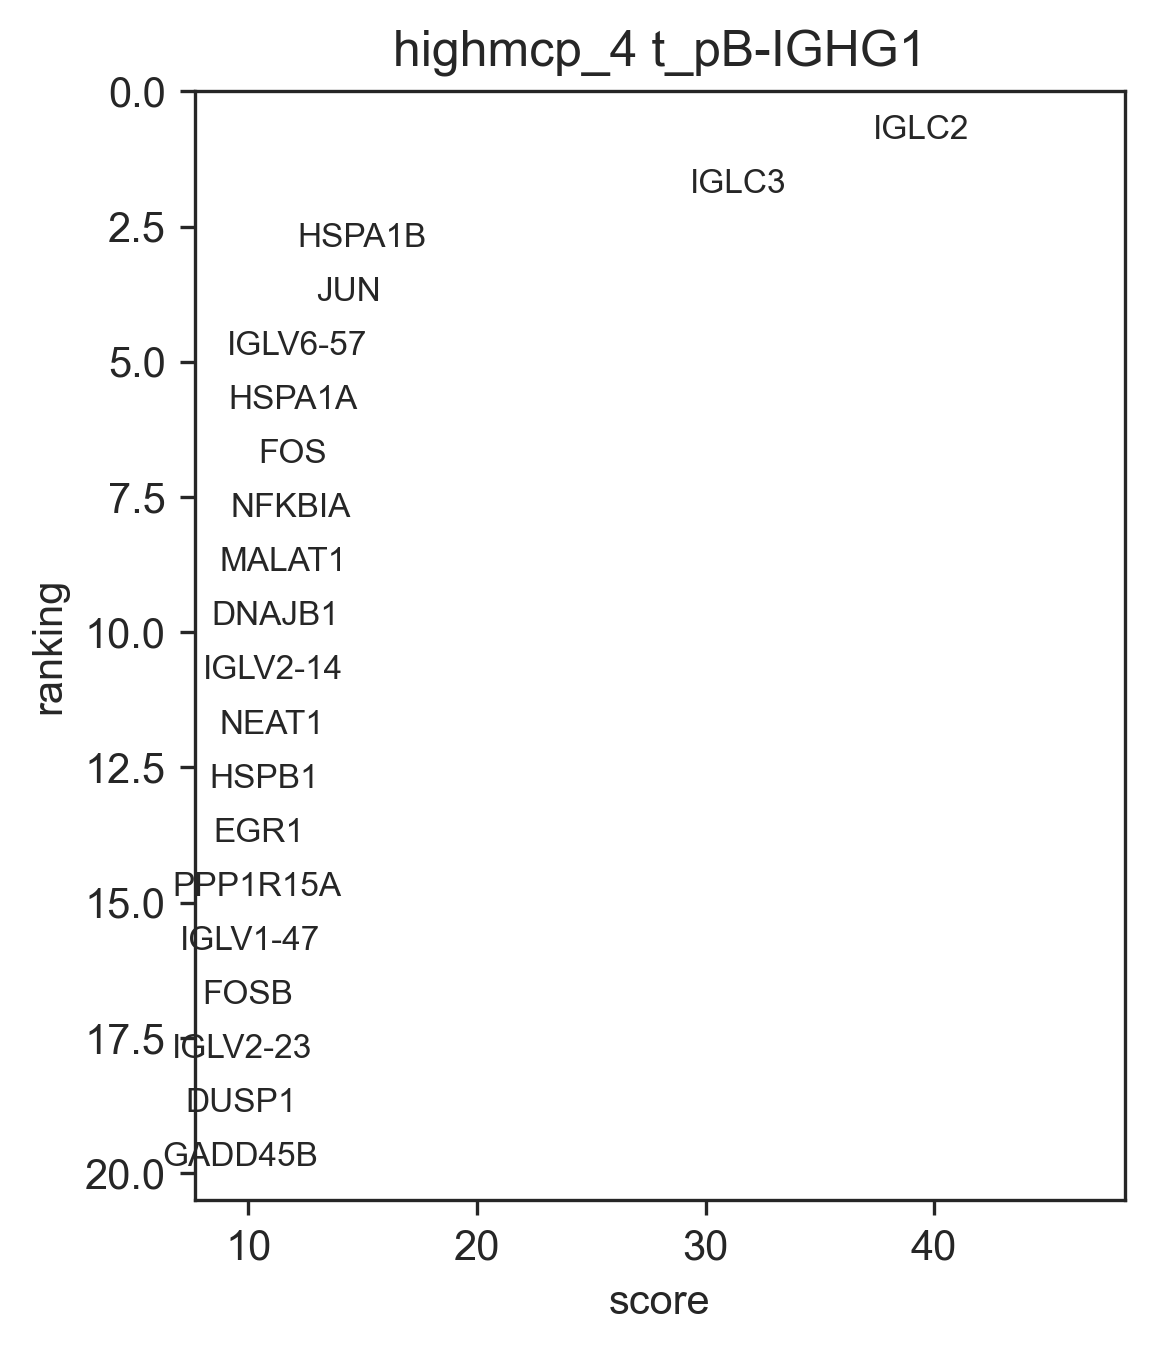

In [237]:
for ct in ct_subs['ct_subs_method2'].keys():
    rank_genes_groups_vertical(ct_subs['ct_subs_method2'][ct])

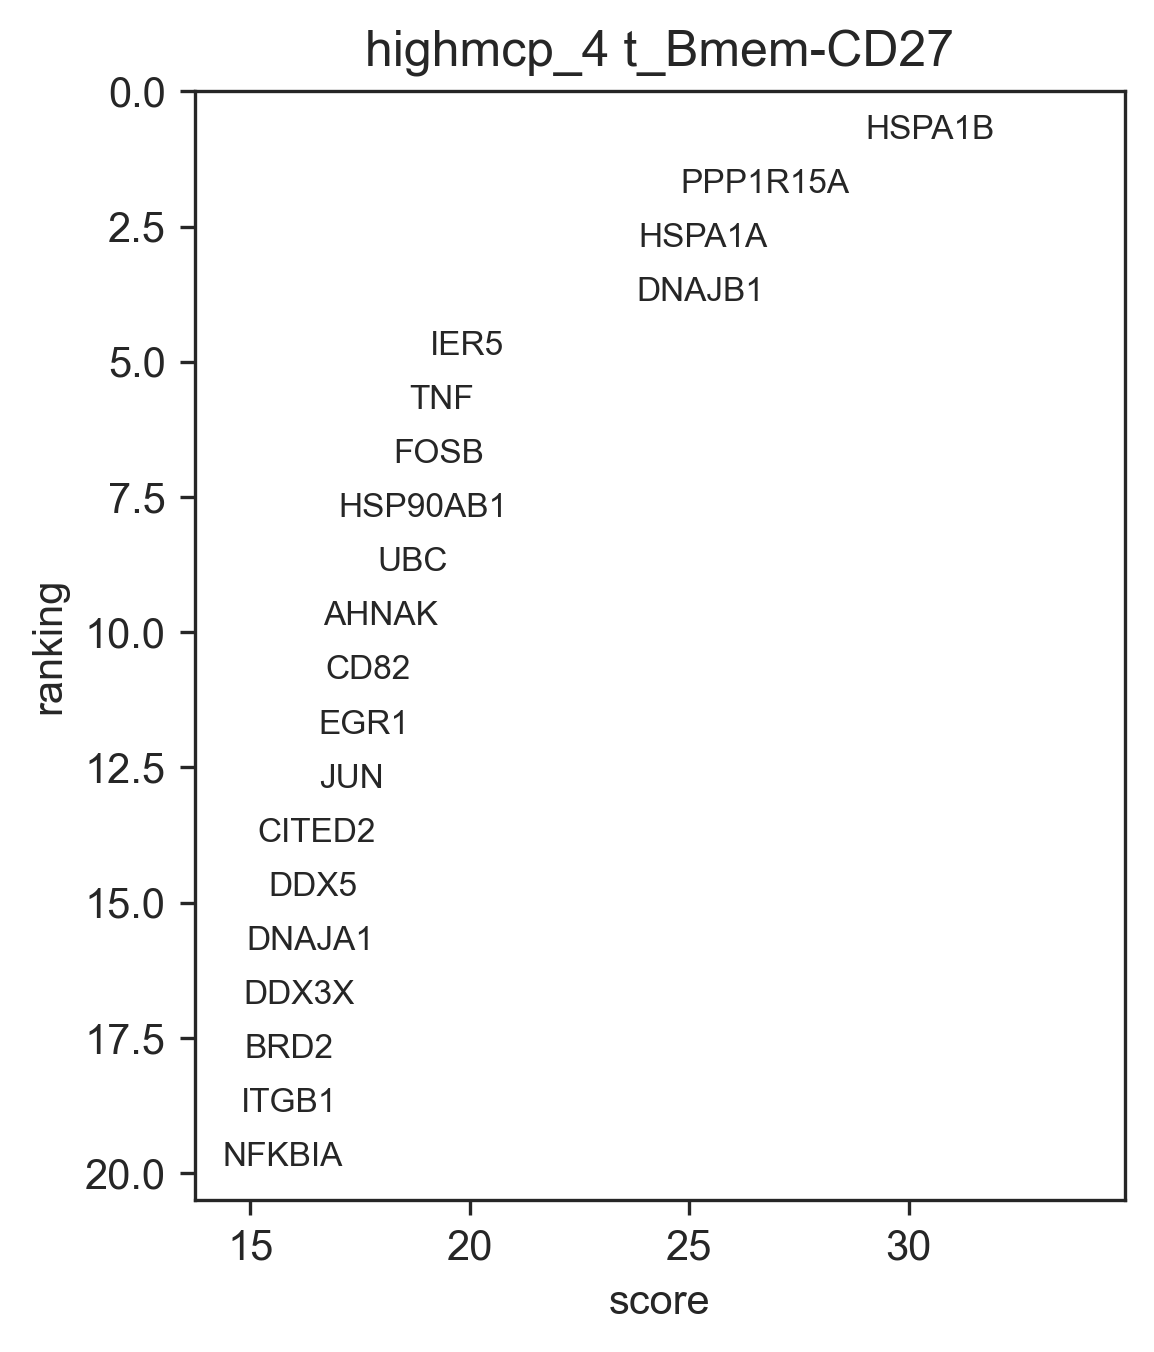

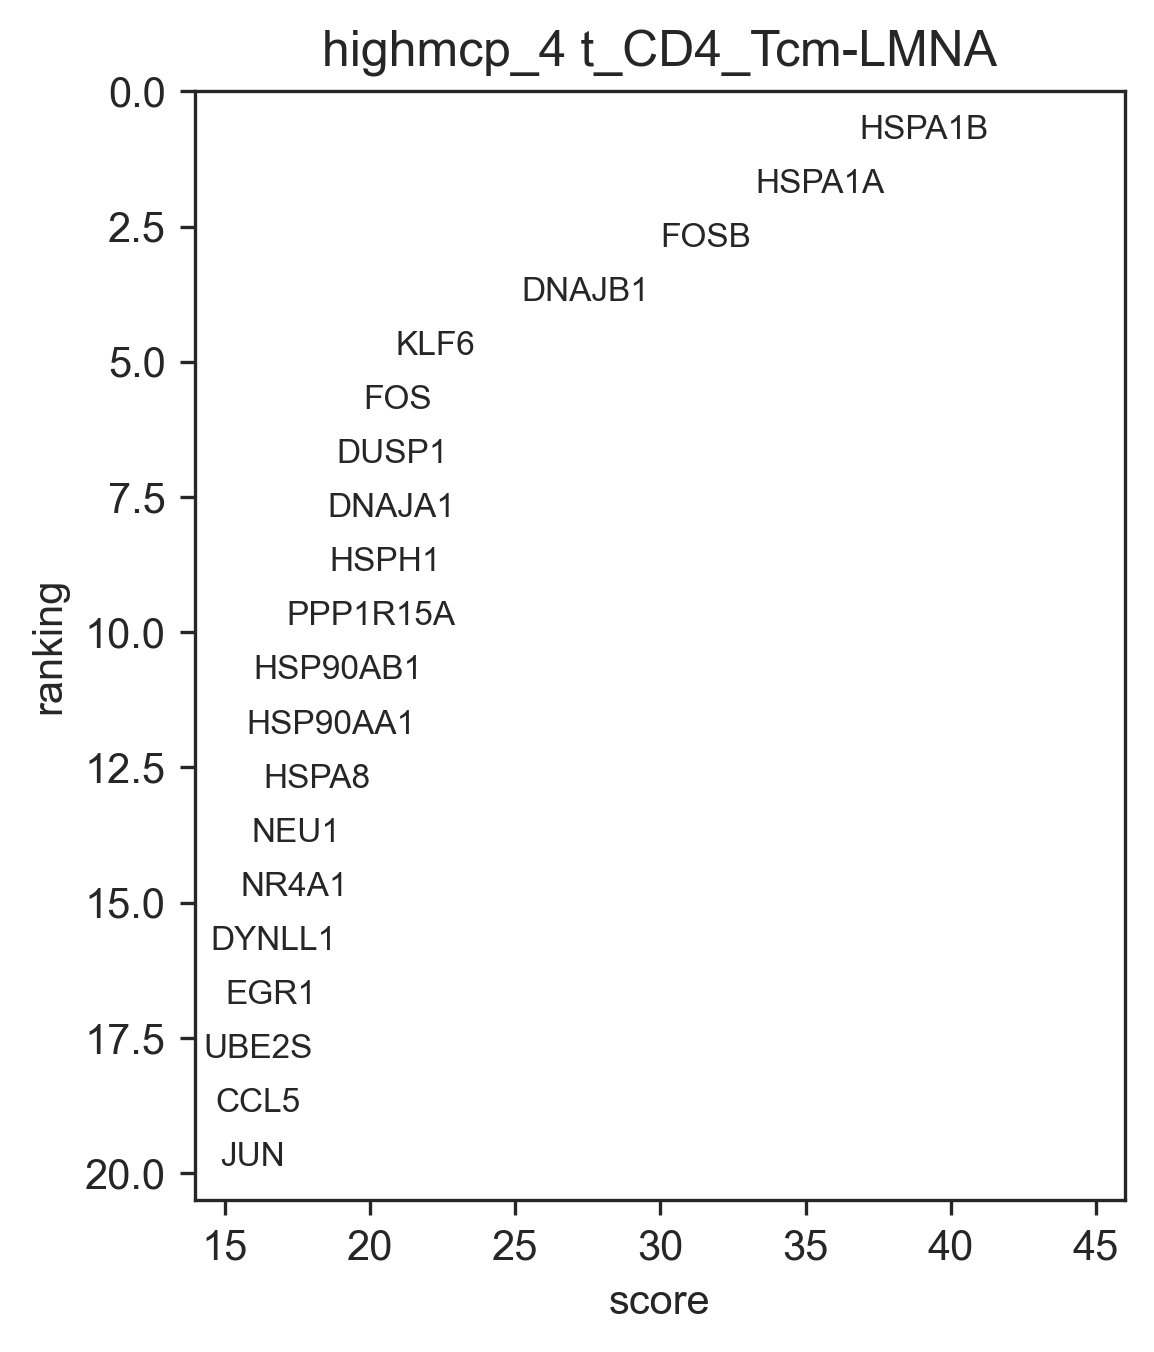

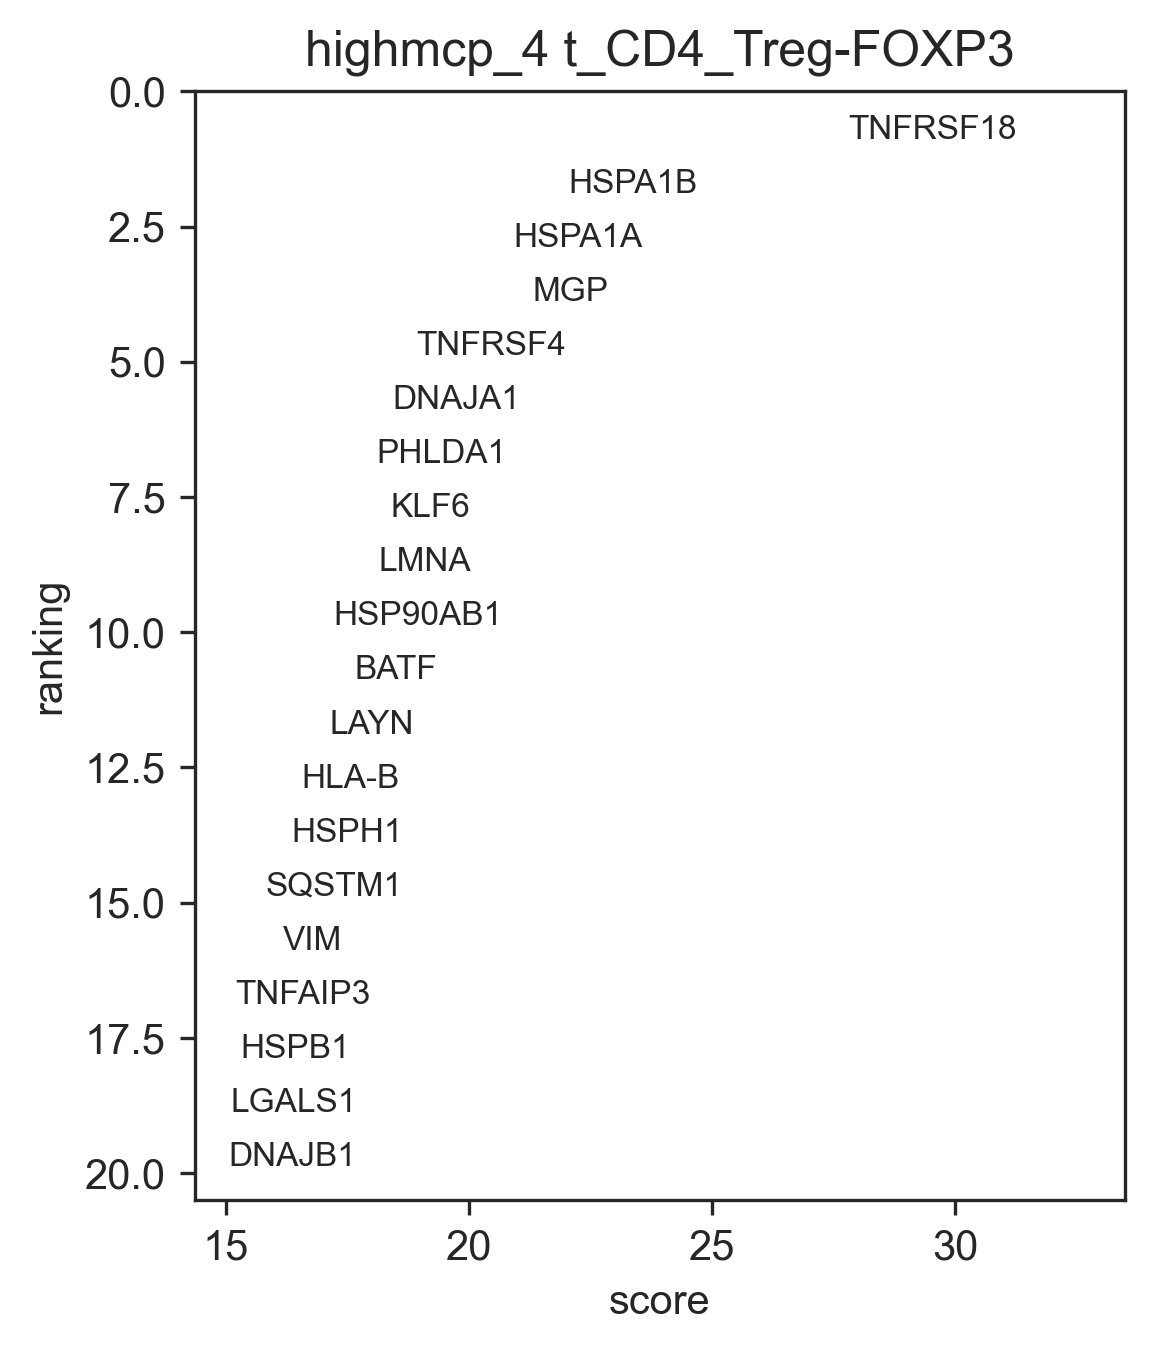

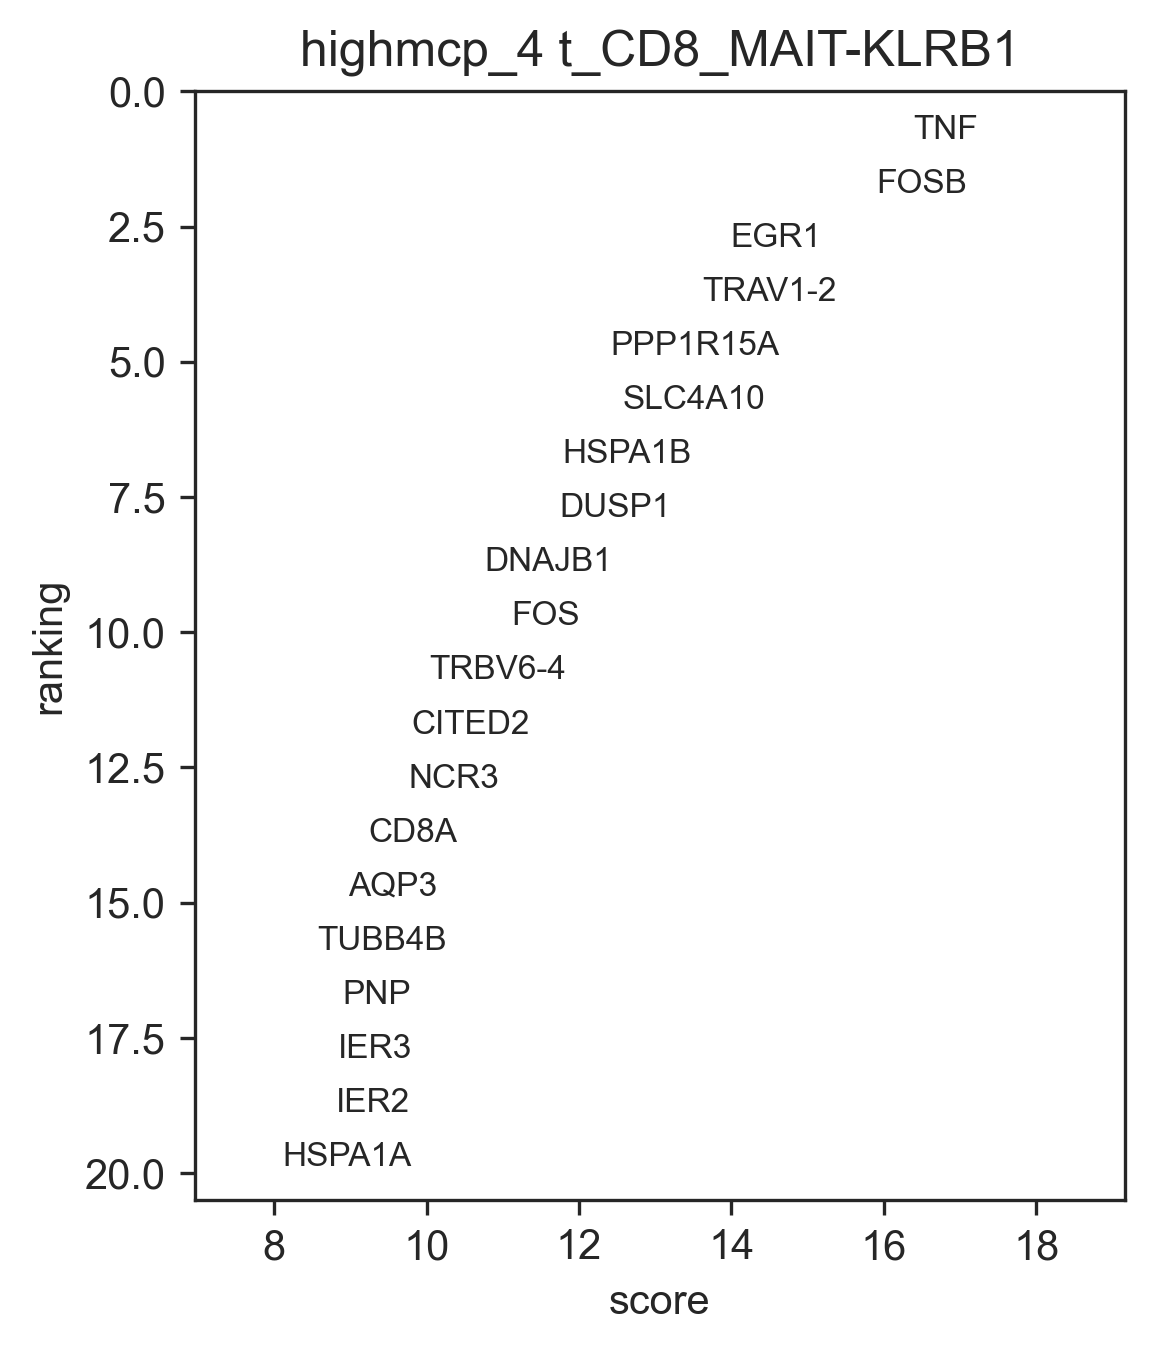

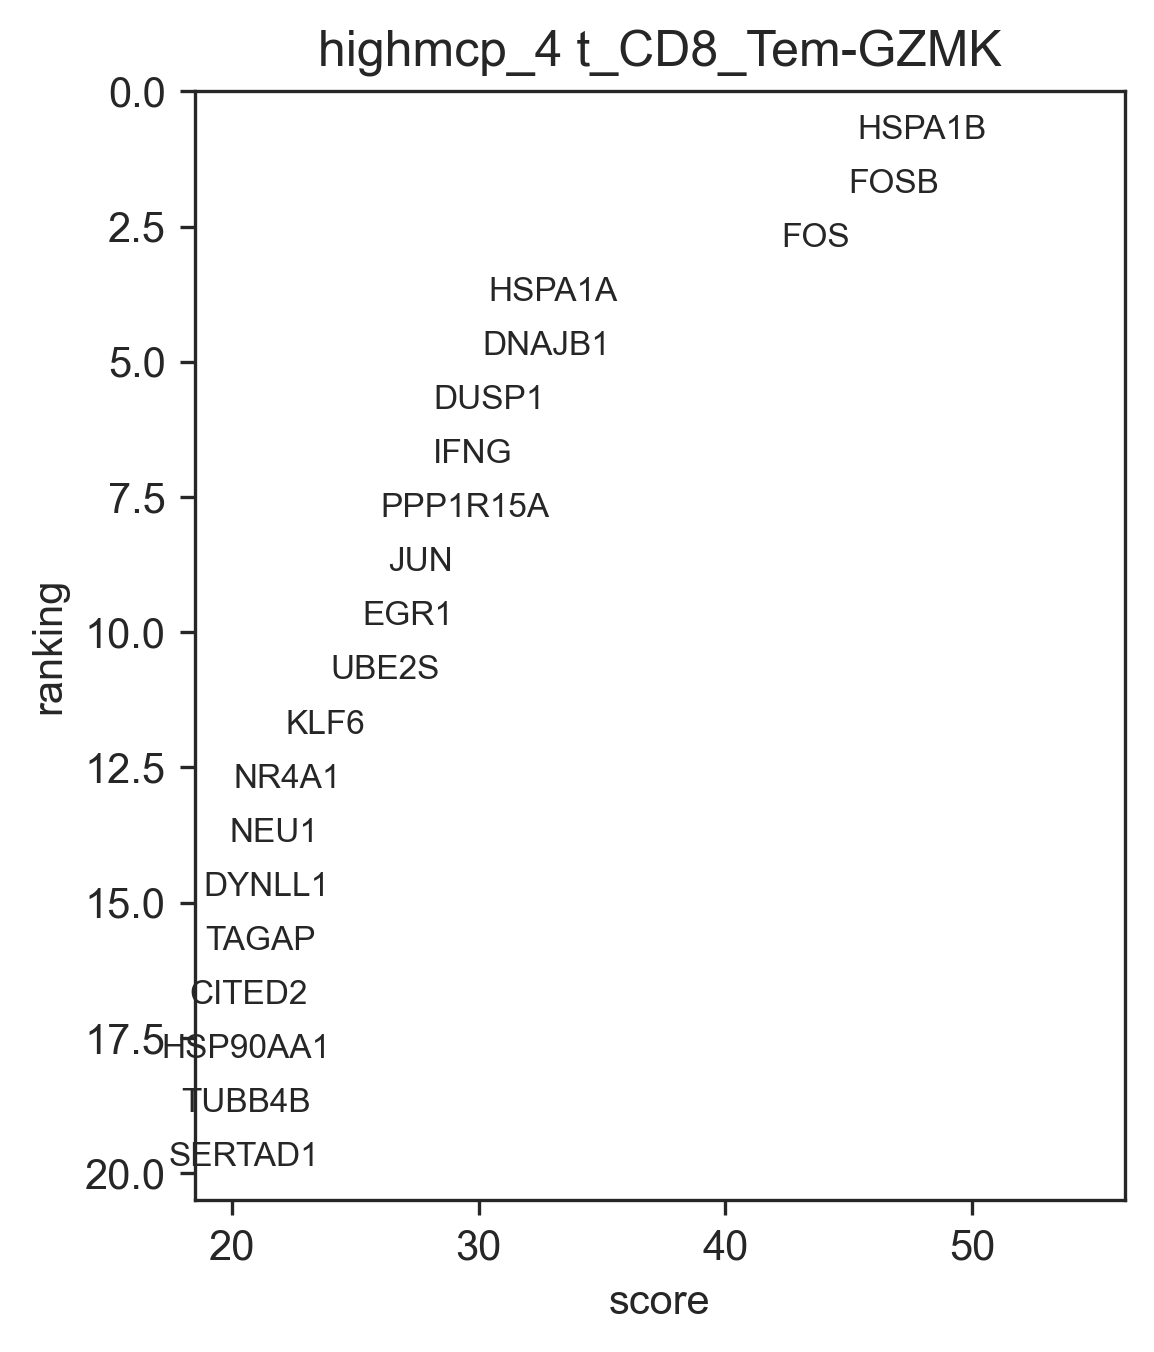

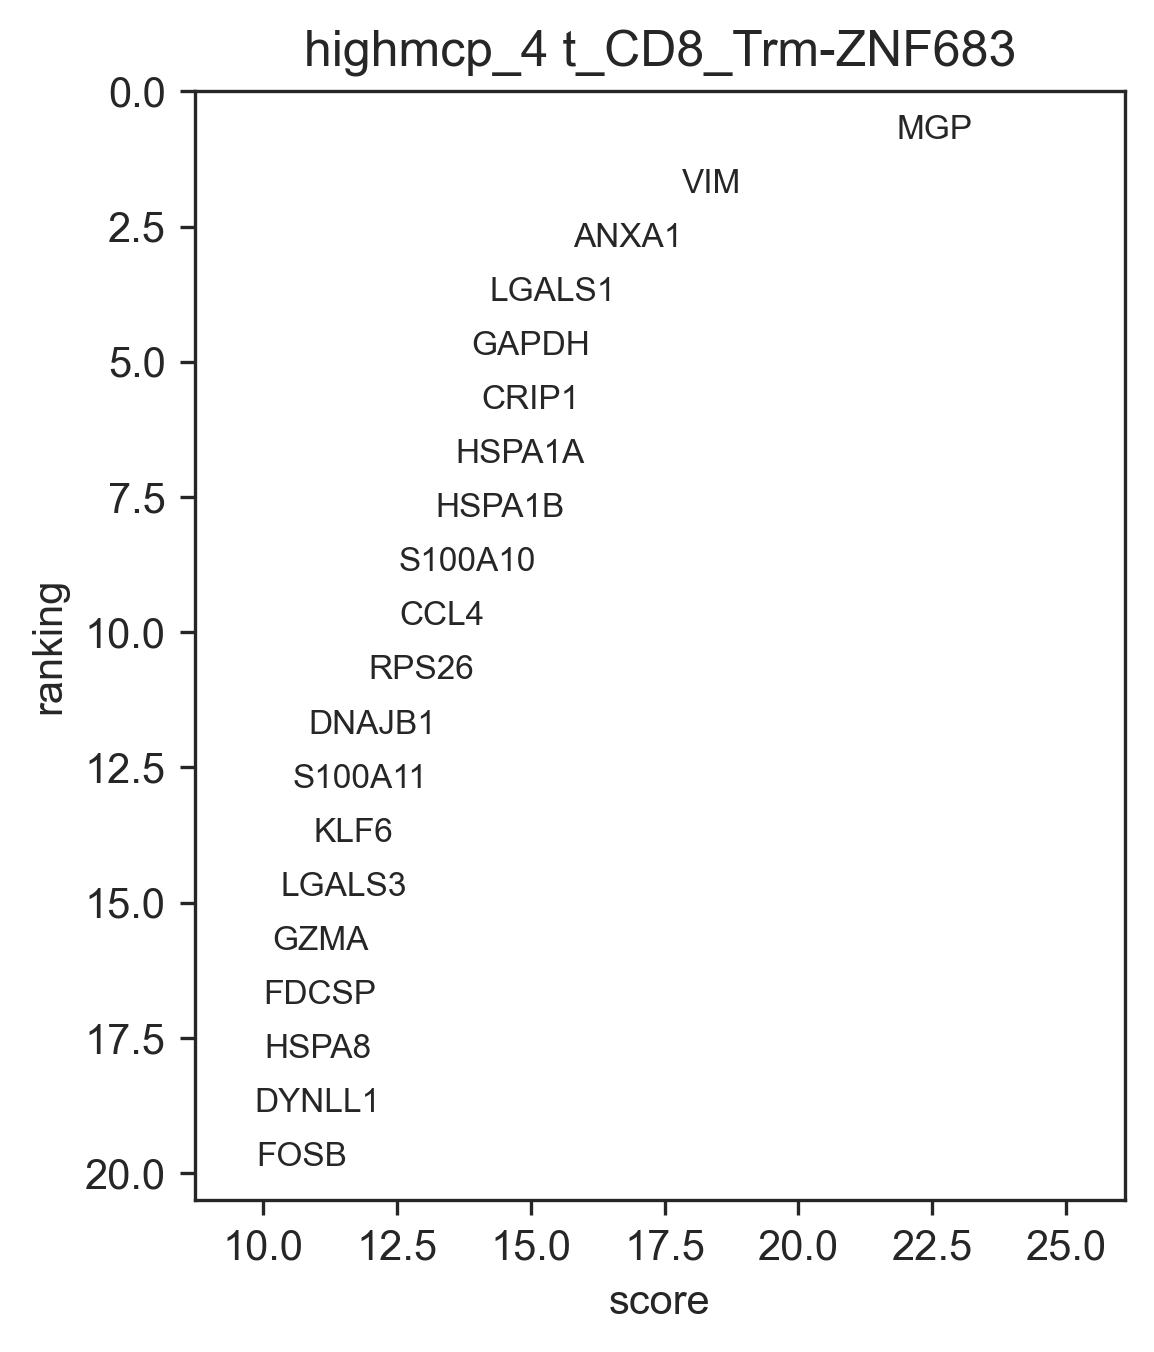

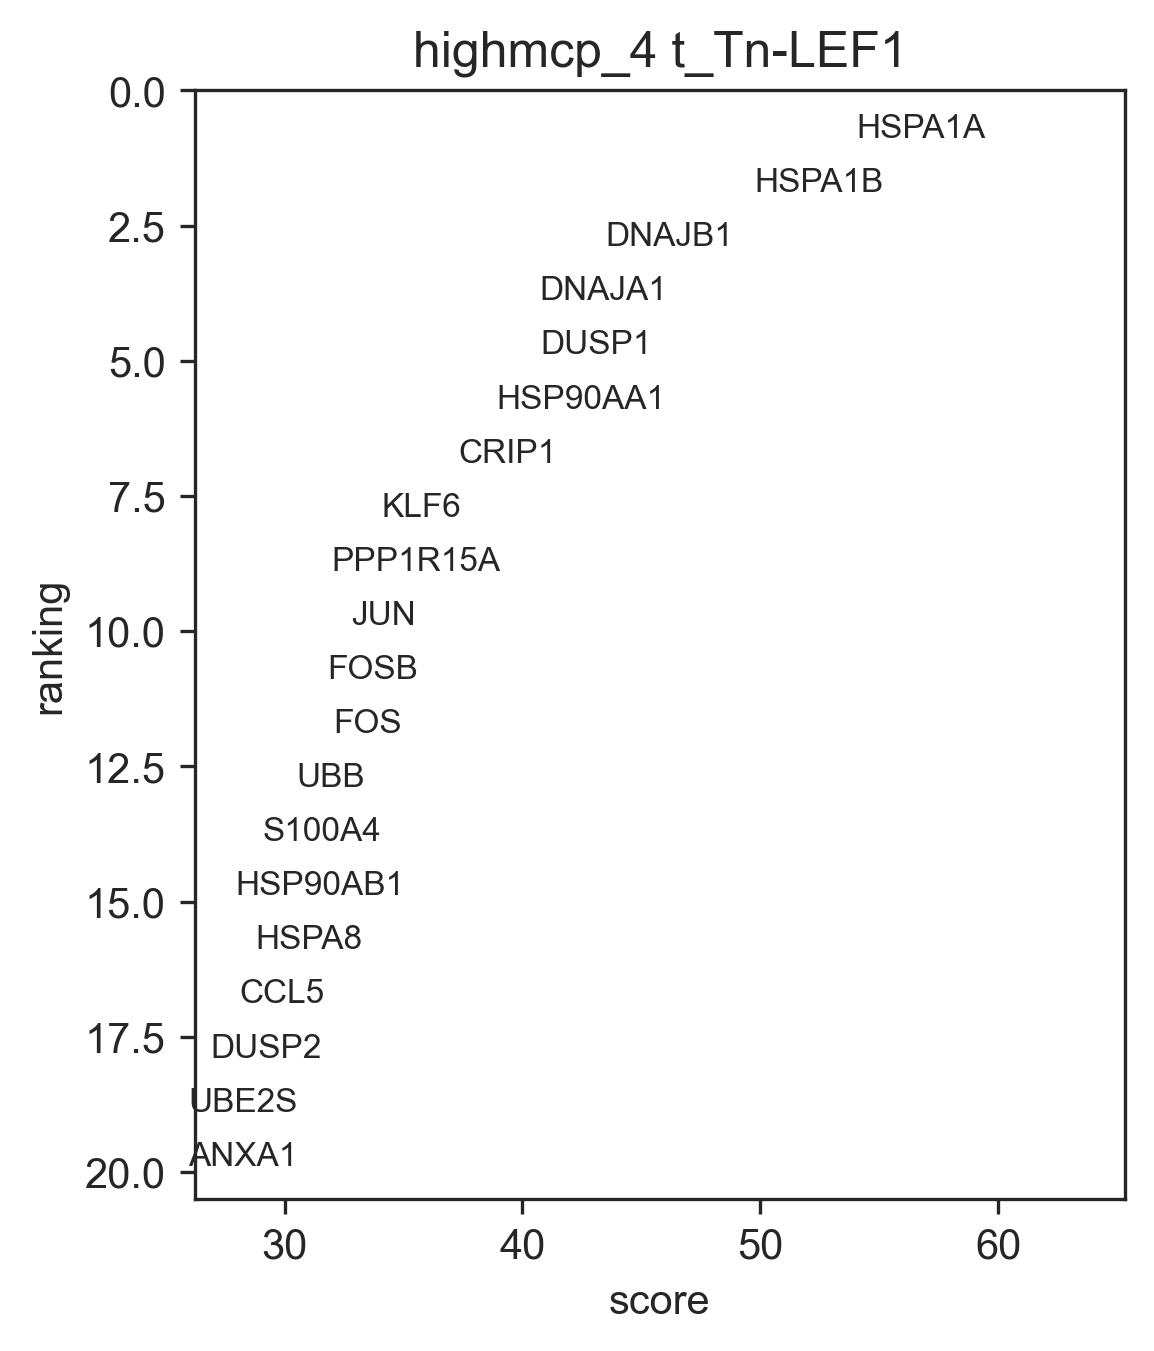

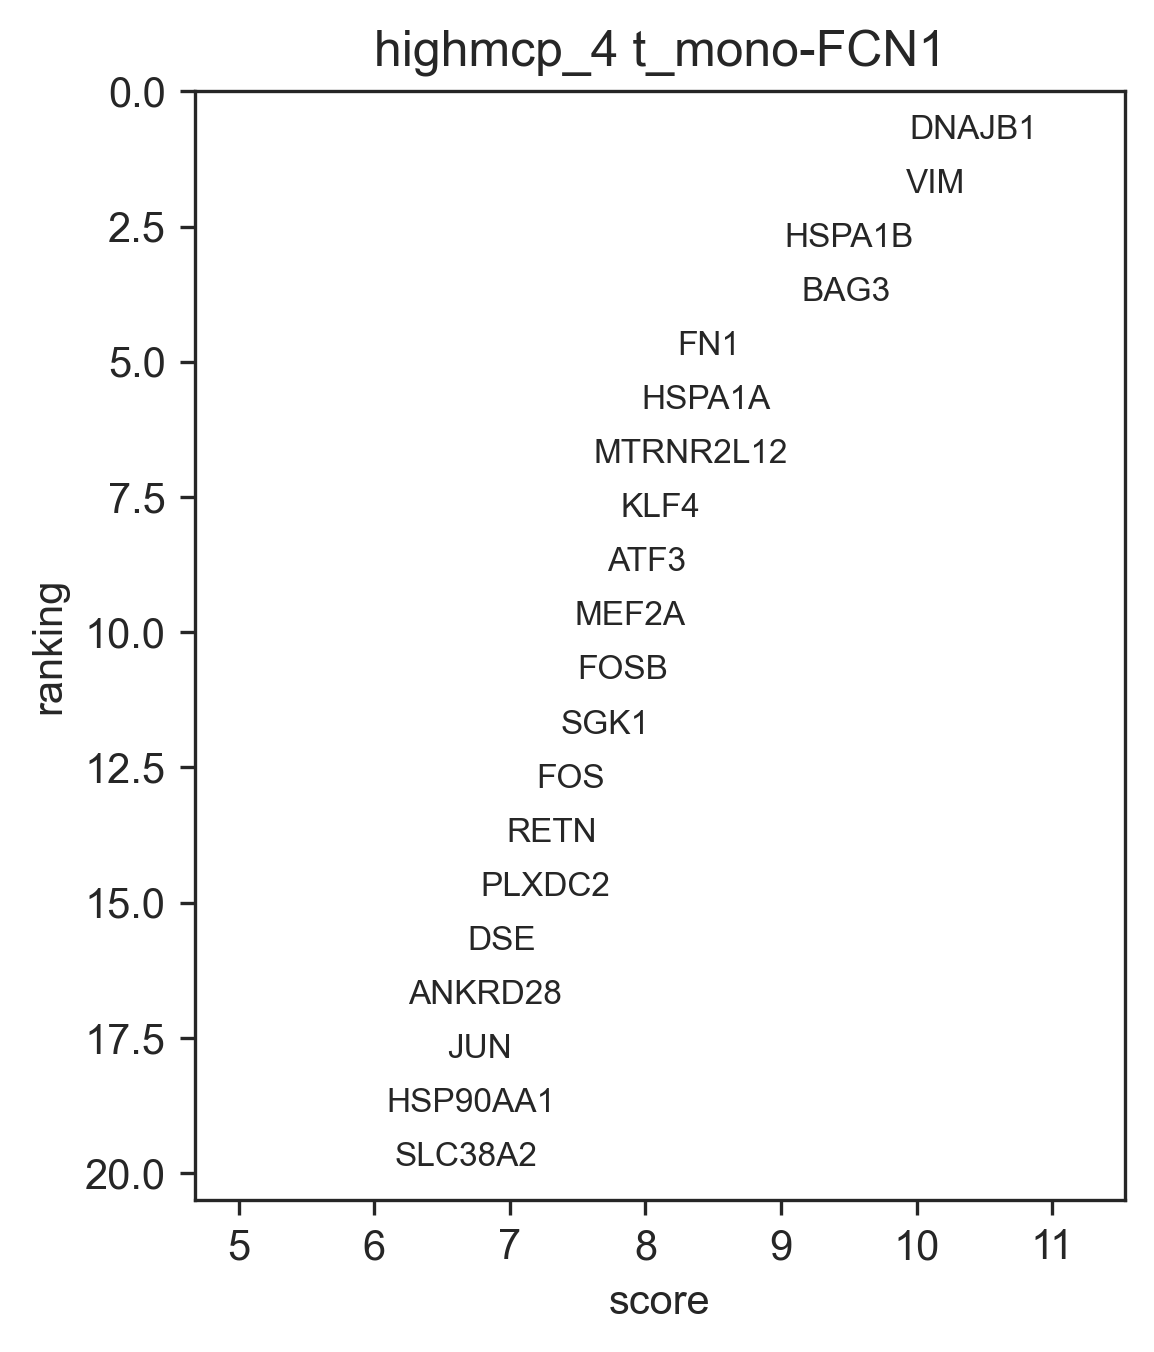

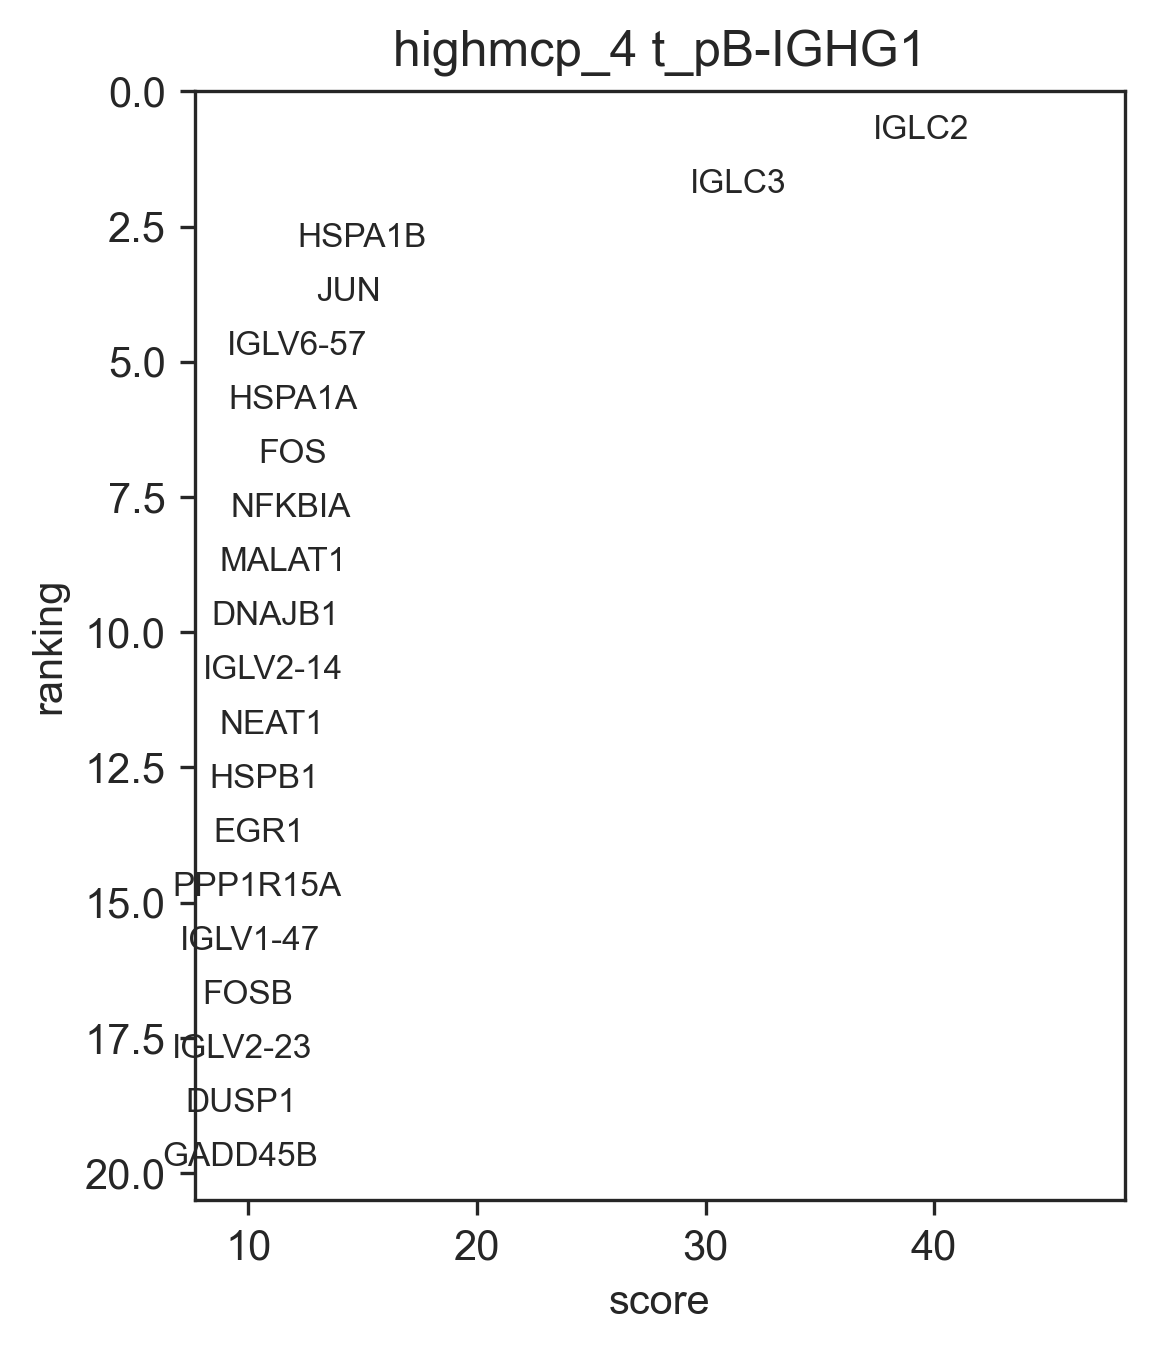

In [245]:
new_cts = get_genes_fixed(ct_subs['ct_subs_method2'], mcp="mcp_4", fraction = 0.1)

for ct in new_cts.keys():
    rank_genes_groups_vertical(new_cts[ct])
    plt.savefig("output/MCP4_rankgenes_%s.png" % ct, dpi=300, bbox_inches="tight")

In [252]:
new_cts['t_Bmem-CD27']

4000

In [255]:
new_cts['t_CD4_Tcm-LMNA'].uns['rank_genes_groups']

{'params': {'groupby': 'extrema',
  'reference': 'low mcp_4 t_CD4_Tcm-LMNA',
  'method': 't-test',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('HSPA1B',), ('HSPA1A',), ('FOSB',), ..., ('RPS13',),
            ('RPL19',), ('RPL32',)],
           dtype=[('highmcp_4 t_CD4_Tcm-LMNA', 'O')]),
 'scores': rec.array([( 39.06163 ,), ( 35.5037  ,), ( 31.540106,), ...,
            (-19.42159 ,), (-19.985939,), (-21.58217 ,)],
           dtype=[('highmcp_4 t_CD4_Tcm-LMNA', '<f4')]),
 'pvals': rec.array([(4.84657033e-170,), (1.35123755e-159,), (5.99272553e-131,),
            ..., (1.54603854e-065,), (6.37640375e-070,),
            (2.57786370e-079,)],
           dtype=[('highmcp_4 t_CD4_Tcm-LMNA', '<f8')]),
 'pvals_adj': rec.array([(1.07463004e-165,), (1.49804951e-155,), (4.42922344e-127,),
            ..., (2.63694712e-062,), (1.17820000e-066,),
            (9.52649529e-076,)],
           dtype=[('highmcp_4 t_CD4_Tcm-LMNA', '<f8')]),
 'logfoldch

In [264]:
list(rank_dfs['mcp_4']['t_CD4_Tcm-LMNA'].head(30)['names'])

['HSPA1B',
 'HSPA1A',
 'FOSB',
 'DNAJB1',
 'KLF6',
 'FOS',
 'DUSP1',
 'DNAJA1',
 'HSPH1',
 'PPP1R15A',
 'HSP90AB1',
 'HSP90AA1',
 'HSPA8',
 'NEU1',
 'NR4A1',
 'DYNLL1',
 'EGR1',
 'UBE2S',
 'CCL5',
 'JUN',
 'MYADM',
 'BAG3',
 'UBB',
 'GZMA',
 'VIM',
 'NEAT1',
 'UBC',
 'CRIP1',
 'LCP2',
 'SERTAD1']

In [265]:
list(rank_dfs['mcp_4']['t_Tn-LEF1'].head(30)['names'])

['HSPA1A',
 'HSPA1B',
 'DNAJB1',
 'DNAJA1',
 'DUSP1',
 'HSP90AA1',
 'CRIP1',
 'KLF6',
 'PPP1R15A',
 'JUN',
 'FOSB',
 'FOS',
 'UBB',
 'S100A4',
 'HSP90AB1',
 'HSPA8',
 'CCL5',
 'DUSP2',
 'UBE2S',
 'ANXA1',
 'MYADM',
 'UBC',
 'CLIC1',
 'HSPH1',
 'AHNAK',
 'DYNLL1',
 'GAPDH',
 'H3F3B',
 'GZMK',
 'LMNA']

{'t_Bmem-CD27': {'mcp_0_up': ['ACTG2',
   'AHNAK',
   'ANXA1',
   'ARID4B',
   'ATP5ME',
   'BGN',
   'BHLHE40',
   'BICDL2',
   'BIRC3',
   'CALML5',
   'CAVIN1',
   'CCR7',
   'CD163L1',
   'CD1C',
   'CD24',
   'CD82',
   'CDKN1A',
   'CLDN4',
   'CLU',
   'COL11A1',
   'CRABP2',
   'CRYAB',
   'CSRNP1',
   'CTTN',
   'DCN',
   'EEF1B2',
   'EIF4B',
   'ELL2',
   'FDCSP',
   'FN1',
   'FXYD3',
   'GNG11',
   'HLA-A',
   'HLA-B',
   'HNRNPU',
   'HSPA5',
   'IGFBP5',
   'IGHA1',
   'IGHV5-78',
   'ITGB1',
   'ITSN2',
   'KLK5',
   'KRT14',
   'KRT15',
   'KRT16',
   'KRT19',
   'KRT8',
   'KRT81',
   'LGALS1',
   'LINC00882',
   'LMNA',
   'MDK',
   'MGP',
   'MIA',
   'MIF',
   'MMP7',
   'MYL9',
   'MYLK',
   'NCL',
   'NEU1',
   'NR4A3',
   'NUPR1',
   'PARP15',
   'PERP',
   'PFN2',
   'PHACTR1',
   'PMP22',
   'PTPRC',
   'PYGL',
   'RAB25',
   'RAB8B',
   'RALGAPA1',
   'ROPN1',
   'RPL36A',
   'RPL37A',
   'RPLP0',
   'RPS2',
   'S100A1',
   'SAA1',
   'SH3BP4',
   'SLC24A3',


In [280]:
genes = []
for celltype in genes_dlg:
    for key in genes_dlg[celltype]:
        genes += genes_dlg[celltype][key]
#genes = list(set(genes))

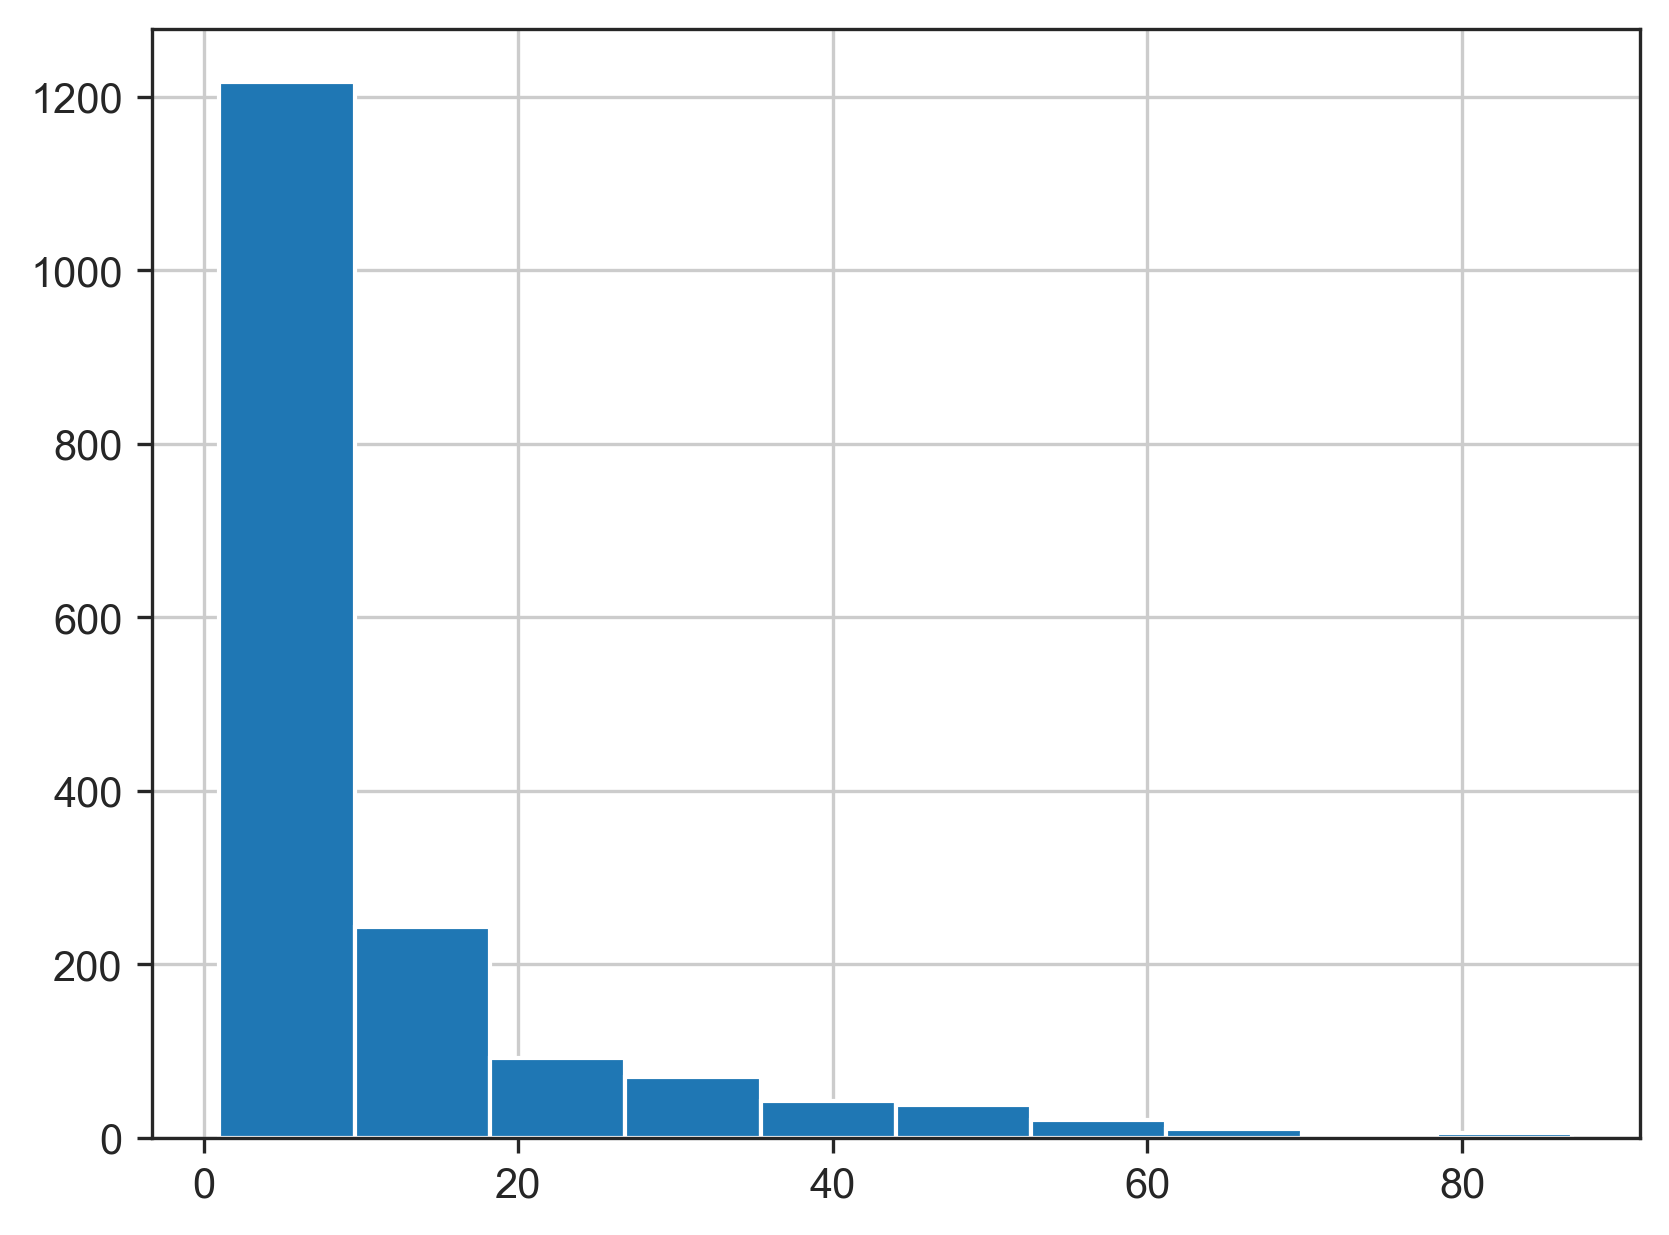

In [281]:
pd.Series(genes).value_counts().hist()
g1 = pd.Series(genes).value_counts()

In [282]:
genes = []
for celltype in genes_hilo:
    for key in genes_hilo[celltype]:
        genes += genes_hilo[celltype][key]
#genes = list(set(genes))

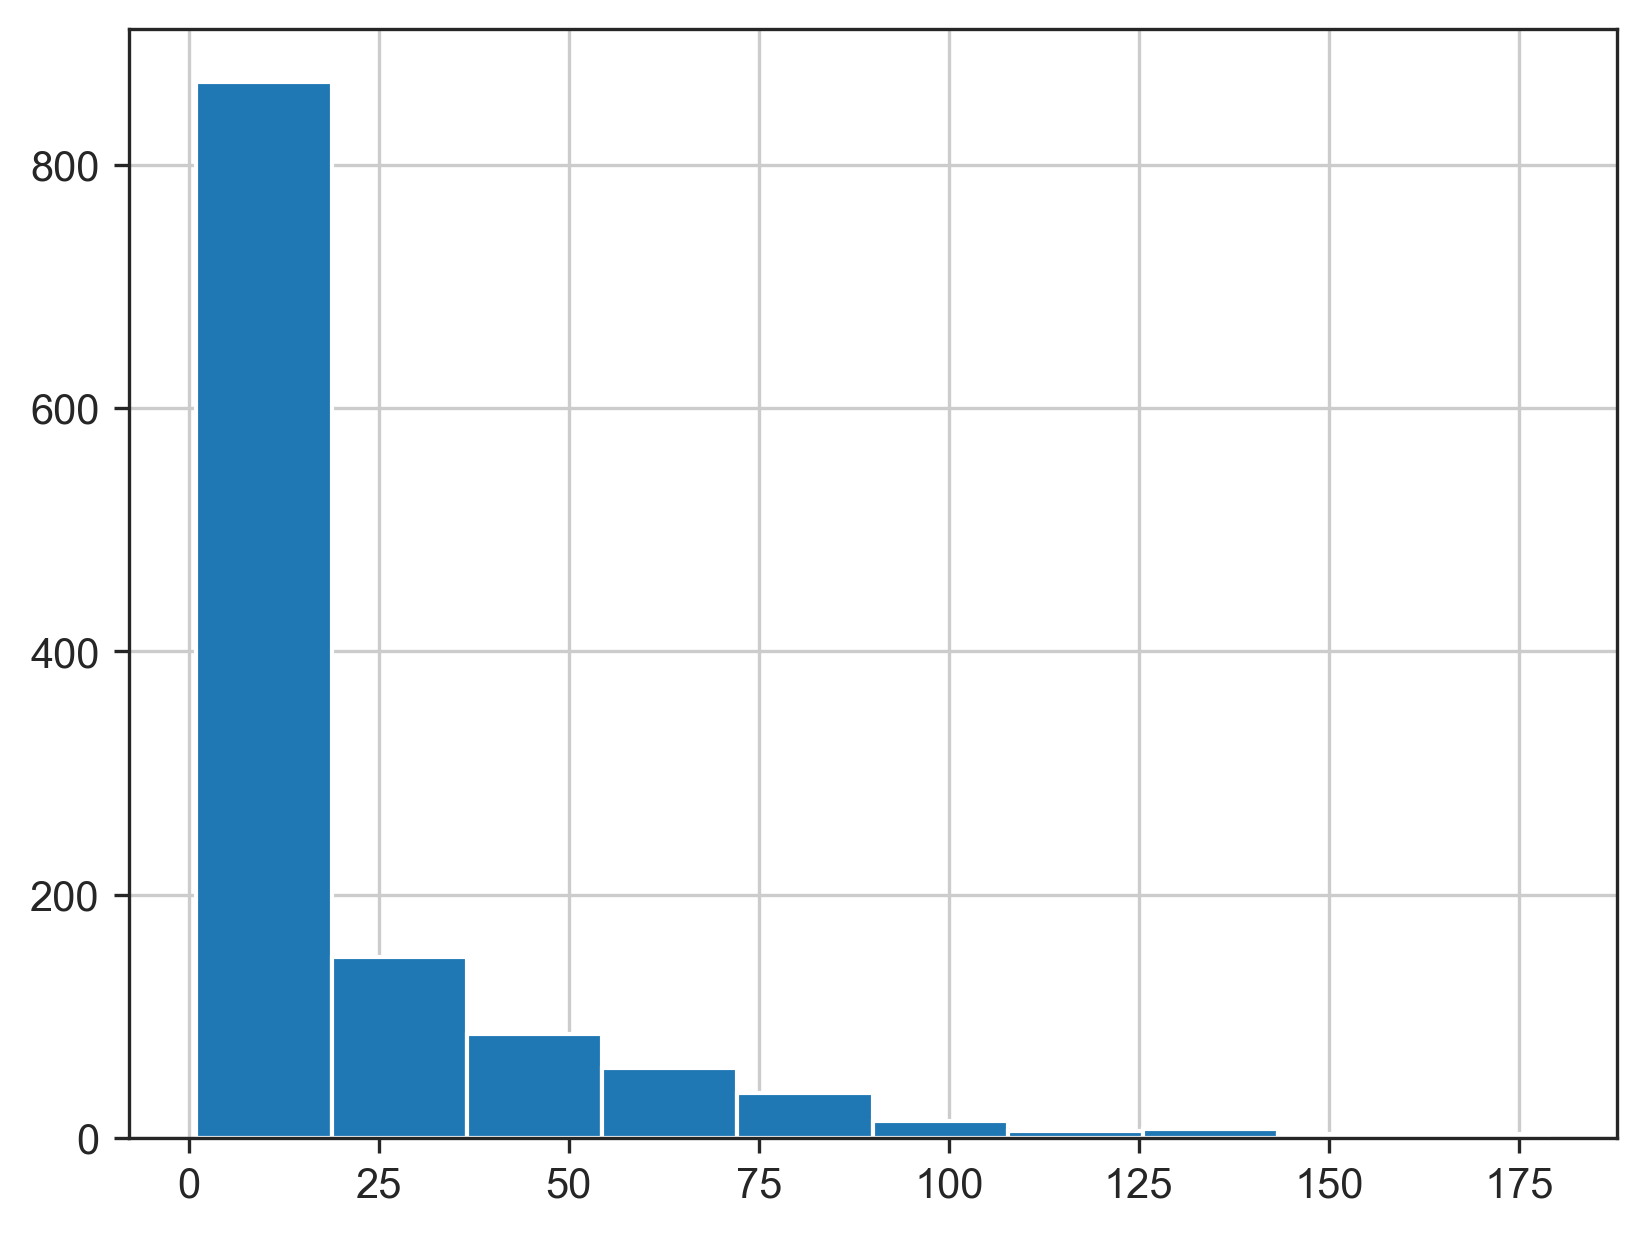

In [283]:
pd.Series(genes).value_counts().hist()
g2 = pd.Series(genes).value_counts()

In [287]:
(g1 > 1).sum()

1688

In [288]:
(g2 > 1).sum()

1181

In [293]:
rank_dfs['mcp_4']['t_Bmem-CD27'][rank_dfs['mcp_4']['t_Bmem-CD27']['names']=="IL7"]

names    scores  logfoldchanges     pvals  pvals_adj     celltype
1817   IL7  3.461444        1.333279  0.000555    0.00579  t_Bmem-CD27